# Модель LSTNet с возможностью подачи внешних регрессоров

In [2]:
import random as rnd
import functools as func
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [4]:
T = 2000  #   Количество точек в ряду
T_test = 100   # Количество точек на тест
x = np.arange(0,T)  
N = 100    #  Количество периодов самой частой синусоиды


In [3]:
rn = 20    #  Примерный период случайных скачков
A = 2     #   Амплитуда случайных скачков (амплитуда самих синусоид равна 1)
rand_l = [rnd.randrange(0,rn) for i in range(T*3//rn)]
rand_l_cumul = np.array(func.reduce(lambda x, y: x+[y+x[-1]], rand_l, [0]))
rand_shift = np.array([A*(2*rnd.random()-1) for i in range(T*3//rn)])   #  Ряд с величинами суммарного сдвига
rand_shift_diff = rand_shift[1:]-rand_shift[:-1]
rand_shift_diff +=[0]                                        #  Ряд с величинами мгновенных скачков
zp = np.array([rand_l_cumul[1:], rand_shift])
#print(rand_shift_diff)
#print(zp)

In [4]:
all_shifts = []                       #    Ряд с величинами суммарного сдвига, включая точки, где сдвиг не менялся
all_shifts_diff = []                  #    Ряд с изменениями сдвига, включая нулевые
n = 0
for i in range(T):
    if (i > rand_l_cumul[n]):
        n += 1
    all_shifts.append(rand_shift[n])
    all_shifts_diff.append(rand_shift_diff[n])

all_shifts_prev = np.array(all_shifts[1:]+[0])
all_shifts = np.array(all_shifts)
all_shifts_diff = np.array(all_shifts)
#print(all_shifts)

In [5]:
# Суммарный ряд данных, который мы будем учиться предсказывать
y =  np.sin(2*N*np.pi*x/T) + np.cos(0.5*N*np.pi*x/T) + (0.01*x) + all_shifts[x] # + np.random.normal(0, 0.1, size=T)

In [2]:
x = np.sin(np.pi)
y = x*2
all_shifts = x+x

In [8]:
ttsd = torch.tensor(all_shifts_diff)     #  Тензор с величинами скачков
ttsp = torch.tensor(all_shifts_prev)     #  Тензор с суммарным сдвигом
#ttsp = torch.zeros(all_shifts_prev.shape)
#tts = torch.tensor(all_shifts)
tt2=torch.tensor(y)                             #
#tt2 = torch.unsqueeze(torch.tensor(tt2), 1)
#tt2=tt2/(m2t)
#print(tt2.shape)
#print(m2t)
#tt2=tt2.transpose(0,1)
tt2 = torch.stack([tt2, tt2], 1)           #   Данные для предсказания (ряд повторяется два раза, чтобы обойти неизвестный баг)
tts2 = torch.stack([ttsp, ttsd], 1)        #   Общий тензор с внешними регрессорами (сдвигами и скачками)
print(tt2.shape)
print(tts2.shape)
tta = tt2.numpy()                                    #   Ряды данных для предсказания готовим для записи в файл, потому что так хочет лоадер (а вот регрессоры подадим отдельно)
tta[:,1] = tta[:,0]
np.savetxt("sin_regr_1.txt", tta, delimiter=',')              #   Собственно запись в файл

torch.Size([2000, 2])
torch.Size([2000, 2])


Модель из статьи  https://arxiv.org/pdf/1703.07015.pdf

In [9]:


class Model(nn.Module):
    def __init__(self, args, data, regr_size=0):    #  Добавился последний параметр с количеством рядов-гегрессоров
        super(Model, self).__init__()
        self.use_cuda = args.cuda
        self.P = args.window;
        self.rs = regr_size
        self.m = data.m + regr_size    #  Вот здесь изменение в чужом коде - надо учесть ряды-регрессоры
        self.hidR = args.hidRNN;
        self.hidC = args.hidCNN;
        self.hidS = args.hidSkip;
        self.Ck = args.CNN_kernel;
        self.skip = args.skip;
        self.pt = int((self.P - self.Ck)/self.skip)
        self.hw = args.highway_window
        self.conv1 = nn.Conv2d(1, self.hidC, kernel_size = (self.Ck, self.m));
        self.GRU1 = nn.GRU(self.hidC, self.hidR);
        self.dropout = nn.Dropout(p = args.dropout);
        if (self.skip > 0):
            self.GRUskip = nn.GRU(self.hidC, self.hidS);
            self.linear1 = nn.Linear(self.hidR + self.skip * self.hidS, self.m - self.rs);
        else:
            self.linear1 = nn.Linear(self.hidR, self.m - self.rs);
        if (self.hw > 0):
            self.highway = nn.Linear(self.hw, 1);
            self.last = nn.Linear(self.m, self.m - self.rs)
        self.output = None;
        if (args.output_fun == 'sigmoid'):
            self.output = F.sigmoid;
        if (args.output_fun == 'tanh'):
            self.output = F.tanh;
 
    def forward(self, x):
        batch_size = x.size(0);
        
        #CNN
        c = x.view(-1, 1, self.P, self.m);
        c = F.relu(self.conv1(c));
        c = self.dropout(c);
        c = torch.squeeze(c, 3);
        
        # RNN 
        r = c.permute(2, 0, 1).contiguous();
        _, r = self.GRU1(r);
        r = self.dropout(torch.squeeze(r,0));

        
        #skip-rnn
        
        if (self.skip > 0):
            s = c[:,:, int(-self.pt * self.skip):].contiguous();
            s = s.view(batch_size, self.hidC, self.pt, self.skip);
            s = s.permute(2,0,3,1).contiguous();
            s = s.view(self.pt, batch_size * self.skip, self.hidC);
            _, s = self.GRUskip(s);
            s = s.view(batch_size, self.skip * self.hidS);
            s = self.dropout(s);
            r = torch.cat((r,s),1);
        
        res = self.linear1(r);
        
        #highway
        if (self.hw > 0):
            z = x[:, -self.hw:, :];
            z = z.permute(0,2,1).contiguous().view(-1, self.hw);
            z = self.highway(z);
            z = z.view(-1,self.m);
            z = self.last(z)
            res = res + z;
            
        if (self.output):
            res = self.output(res);
        return res;
    
        
        

In [79]:


import math
import torch.optim

class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = torch.optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = torch.optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = torch.optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = torch.optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm

    # decay learning rate if val perf does not improve or we hit the start_decay_at limit
    def updateLearningRate(self, ppl, epoch):
        if self.start_decay_at is not None and epoch >= self.start_decay_at:
            self.start_decay = True
        if self.last_ppl is not None and ppl > self.last_ppl:
            self.start_decay = True

        if self.start_decay:
            self.lr = self.lr * self.lr_decay
            print("Decaying learning rate to %g" % self.lr)
        #only decay for one epoch
        self.start_decay = False

        self.last_ppl = ppl

        self._makeOptimizer()

In [80]:


import torch
import numpy as np;
from torch.autograd import Variable


def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))


#  Класс, который загружает данные и формирует батчи. В конструктор дополнительно подаем параметр regressors - тензор с рядами-регрессорами
class Data_utility(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, cuda, horizon, window, regressors, normalize = 2, def_scale = 1):
        self.cuda = cuda;
        self.P = window;
        self.h = horizon
        fin = open(file_name);
        self.rawdat = np.loadtxt(fin,delimiter=',');
        self.regr = regressors                                # Сохраняем сюда ряды-регрессоры
        self.dat = np.zeros(self.rawdat.shape);
        self.n, self.m = self.dat.shape;
        self.normalize = 2
        self.scale = np.ones(self.m)*def_scale;
        self._normalized(normalize);
        self._split(int(train * self.n), int((train+valid) * self.n), self.n);
        
        self.scale = torch.from_numpy(self.scale).float();
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.m);
            
        if self.cuda:
            self.scale = self.scale.cuda();
        self.scale = Variable(self.scale);
        
        self.rse = normal_std(tmp);
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)));
    
    def _normalized(self, normalize):
        #normalized by the maximum value of entire matrix.
       
        if (normalize == 0):
            self.dat = self.rawdat
            
        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat);
            
        #normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:,i]));
                self.dat[:,i] = self.rawdat[:,i] / np.max(np.abs(self.rawdat[:,i]));
            
        
    def _split(self, train, valid, test):
        
        train_set = range(self.P+self.h-1, train);
        valid_set = range(train, valid);
        test_set = range(valid, self.n);
        self.train = self._batchify(train_set, self.h);
        self.valid = self._batchify(valid_set, self.h);
        self.test = self._batchify(test_set, self.h);
        
        
    def _batchify(self, idx_set, horizon):
        
        n = len(idx_set);
        X = torch.zeros((n,self.P,self.m));
        XR = torch.zeros((n,self.P,self.m));      #   В этом тензоре будут регрессоры
        Y = torch.zeros((n,self.m));
        
        for i in range(n):
            end = idx_set[i] - self.h + 1;
            start = end - self.P;
            X[i,:,:] = torch.from_numpy(self.dat[start:end, :]);
            if (self.regr != None):
                XR[i,:,:] = self.regr[start:end, :];              #  Нарезаем ряды-регрессоры на такие же батчи, как и ряды исходных данных для прогноза
                     
            Y[i,:] = torch.from_numpy(self.dat[idx_set[i], :]);
            #Y[i,:] = self.regr[idx_set[i], :];
            
        if (self.regr != None):
            X = torch.cat([X, XR], dim=2)           #  Приклеиваем регрессоры к батчам исходных данных

        return [X, Y];

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        #print("len = " + str(length))
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            #print("end_idx = " + str(end_idx))
            excerpt = index[start_idx:end_idx]
            #print("start_idx = " + str(start_idx))
            #print(excerpt)
            #print(inputs.shape)
            #print(targets.shape)
            X = inputs[excerpt]; Y = targets[excerpt];
            if (self.cuda):
                X = X.cuda();
                Y = Y.cuda();  
            yield Variable(X), Variable(Y);
            start_idx += batch_size

In [81]:


import argparse
import math
import time
import sys

import torch
import torch.nn as nn

import numpy as np;
import importlib


def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval();
    total_loss = 0;
    total_loss_l1 = 0;
    n_samples = 0;
    predict = None;
    test = None;
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X);
        if predict is None:
            predict = output;
            test = Y;
        else:
            predict = torch.cat((predict,output));
            test = torch.cat((test, Y));
        
        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data.m);
    rse = math.sqrt(total_loss / n_samples)/data.rse
    rae = (total_loss_l1/n_samples)/data.rae
    
    predict = predict.data.cpu().numpy();
    Ytest = test.data.cpu().numpy();
    sigma_p = (predict).std(axis = 0);
    sigma_g = (Ytest).std(axis = 0);
    mean_p = predict.mean(axis = 0)
    mean_g = Ytest.mean(axis = 0)
    index = (sigma_g!=0);
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis = 0)/(sigma_p * sigma_g);
    correlation = (correlation[index]).mean();
    return rse, rae, correlation, predict, Ytest;

def train(data, X, Y, model, criterion, optim, batch_size):
    model.train();
    total_loss = 0;
    n_samples = 0;
    for X, Y in data.get_batches(X, Y, batch_size, True):
        model.zero_grad();
        output = model(X);
        scale = data.scale.expand(output.size(0), data.m)
        loss = criterion(output * scale, Y * scale);
        loss.backward();
        grad_norm = optim.step();
        total_loss += loss.item();
        n_samples += (output.size(0) * data.m);
    return total_loss / n_samples

sys.argv = "main --gpu 0 --horizon 24 --data data/electricity.txt --save save/elec.pt --output_fun Linear".split(" ")
    
parser = argparse.ArgumentParser(description='PyTorch Time series forecasting')
parser.add_argument('--data', type=str, required=True,
                    help='location of the data file')
parser.add_argument('--model', type=str, default='LSTNet',
                    help='')
parser.add_argument('--hidCNN', type=int, default=100,
                    help='number of CNN hidden units')
parser.add_argument('--hidRNN', type=int, default=100,
                    help='number of RNN hidden units')
parser.add_argument('--window', type=int, default=24 * 7,
                    help='window size')
parser.add_argument('--CNN_kernel', type=int, default=6,
                    help='the kernel size of the CNN layers')
parser.add_argument('--highway_window', type=int, default=24,
                    help='The window size of the highway component')
parser.add_argument('--clip', type=float, default=10.,
                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=100,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                    help='batch size')
parser.add_argument('--dropout', type=float, default=0.2,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--seed', type=int, default=54321,
                    help='random seed')
parser.add_argument('--gpu', type=int, default=None)
parser.add_argument('--log_interval', type=int, default=2000, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str,  default='model/model.pt',
                    help='path to save the final model')
parser.add_argument('--cuda', type=str, default=True)
parser.add_argument('--optim', type=str, default='adam')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--horizon', type=int, default=12)
parser.add_argument('--skip', type=float, default=24)
parser.add_argument('--hidSkip', type=int, default=5)
parser.add_argument('--L1Loss', type=bool, default=True)
parser.add_argument('--normalize', type=int, default=2)
parser.add_argument('--output_fun', type=str, default='sigmoid')
parser.add_argument('--calendar', type=int, default= snap_CA)

args = parser.parse_args()

args.data = 'sin_regr_1.txt'     #  Файл исходных данных (они сохраняются сюда после генерации, регрессоров не содержат)
args.save = 'sin_regr_1.pt'      #  Сюда сохраняется модель

args.epochs = 10000             #  Количество эпох обучения

In [82]:
calendar = pd.read_csv("calendar.csv")

In [83]:
 Создавая экземпляр класса с данными подаем туда тензор с регрессорами tts2

args.cuda = args.gpu is not None
if args.cuda:
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)

# Создаем экземпляр класса с данными подаем туда тензор с регрессорами tts2
Data = Data_utility(args.data, 0.6, 0.2, args.cuda, args.horizon, args.window,  tts2, args.normalize, def_scale=1)
print(Data.rse);

model = Model(args, Data, 2);

if args.cuda:
    model.cuda()
    
nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)


tensor(2.0068)
* number of parameters: 65182


In [84]:
 # определяем лоссы

if args.L1Loss:
    criterion = nn.L1Loss(size_average=False);
else:
    criterion = nn.MSELoss(size_average=False);
evaluateL2 = nn.MSELoss(size_average=False);
evaluateL1 = nn.L1Loss(size_average=False)
if args.cuda:
    criterion = criterion.cuda()
    evaluateL1 = evaluateL1.cuda();
    evaluateL2 = evaluateL2.cuda();
    



C:\Users\apugacheva\Anaconda3\envs\m5\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [85]:
# создание экземпляра оптимизатора

best_val = 10000000;
optim = Optim(
    model.parameters(), args.optim, args.lr, args.clip,
)

In [86]:
# запускаем обучение
    
'''--gpu 3 
   --data data/traffic.txt 
   --save save/traffic.pt 
   --hidSkip 10'''


# At any point you can hit Ctrl + C to break out of training early.
try:
    print('begin training');
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optim, args.batch_size)
        val_loss, val_rae, val_corr, _, _ = evaluate(Data, Data.valid[0], Data.valid[1], model, evaluateL2, evaluateL1, args.batch_size);
        print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr))
        # Save the model if the validation loss is the best we've seen so far.

        if val_loss < best_val:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val = val_loss
        if epoch % 5 == 0:
            test_acc, test_rae, test_corr, _, _  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
            print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')



begin training
| end of epoch   1 | time:  0.49s | train_loss 4.4675 | valid rse 1.7386 | valid rae 1.6817 | valid corr  0.0670
| end of epoch   2 | time:  0.20s | train_loss 2.9166 | valid rse 1.3849 | valid rae 1.3003 | valid corr  0.1444
| end of epoch   3 | time:  0.20s | train_loss 2.4575 | valid rse 1.1840 | valid rae 1.1334 | valid corr  0.1396
| end of epoch   4 | time:  0.19s | train_loss 2.0938 | valid rse 1.3463 | valid rae 1.3079 | valid corr  0.2005
| end of epoch   5 | time:  0.19s | train_loss 1.9440 | valid rse 1.1602 | valid rae 1.1132 | valid corr  0.2337
test rse 1.8656 | test rae 1.8934 | test corr 0.0946
| end of epoch   6 | time:  0.19s | train_loss 1.8149 | valid rse 1.0036 | valid rae 0.9675 | valid corr  0.2216
| end of epoch   7 | time:  0.19s | train_loss 1.7741 | valid rse 1.1635 | valid rae 1.1213 | valid corr  0.2859
| end of epoch   8 | time:  0.19s | train_loss 1.6105 | valid rse 0.9202 | valid rae 0.8888 | valid corr  0.2965
| end of epoch   9 | time:  

| end of epoch  68 | time:  0.19s | train_loss 0.7315 | valid rse 1.1554 | valid rae 1.1219 | valid corr  0.3657
| end of epoch  69 | time:  0.19s | train_loss 0.7230 | valid rse 1.2192 | valid rae 1.1913 | valid corr  0.4107
| end of epoch  70 | time:  0.19s | train_loss 0.7027 | valid rse 1.3451 | valid rae 1.3468 | valid corr  0.3553
test rse 3.1683 | test rae 3.4511 | test corr -0.2592
| end of epoch  71 | time:  0.20s | train_loss 0.7044 | valid rse 1.0413 | valid rae 0.9793 | valid corr  0.3960
| end of epoch  72 | time:  0.19s | train_loss 0.7490 | valid rse 1.2615 | valid rae 1.2479 | valid corr  0.3605
| end of epoch  73 | time:  0.19s | train_loss 0.7127 | valid rse 1.2603 | valid rae 1.2469 | valid corr  0.4075
| end of epoch  74 | time:  0.19s | train_loss 0.7027 | valid rse 0.9724 | valid rae 0.9347 | valid corr  0.3571
| end of epoch  75 | time:  0.19s | train_loss 0.6673 | valid rse 1.0180 | valid rae 0.9754 | valid corr  0.3873
test rse 2.5816 | test rae 2.6930 | test c

test rse 1.9125 | test rae 1.9579 | test corr 0.2256
| end of epoch 136 | time:  0.20s | train_loss 0.4276 | valid rse 0.9567 | valid rae 0.9233 | valid corr  0.3691
| end of epoch 137 | time:  0.19s | train_loss 0.4271 | valid rse 0.9854 | valid rae 0.9625 | valid corr  0.3958
| end of epoch 138 | time:  0.20s | train_loss 0.4168 | valid rse 1.0371 | valid rae 1.0420 | valid corr  0.3887
| end of epoch 139 | time:  0.19s | train_loss 0.4510 | valid rse 0.8699 | valid rae 0.8631 | valid corr  0.4085
| end of epoch 140 | time:  0.20s | train_loss 0.4433 | valid rse 0.8207 | valid rae 0.8144 | valid corr  0.3943
test rse 1.6337 | test rae 1.6634 | test corr 0.1879
| end of epoch 141 | time:  0.20s | train_loss 0.4422 | valid rse 0.9901 | valid rae 0.9796 | valid corr  0.3523
| end of epoch 142 | time:  0.20s | train_loss 0.4159 | valid rse 0.9175 | valid rae 0.9205 | valid corr  0.4114
| end of epoch 143 | time:  0.20s | train_loss 0.4014 | valid rse 0.9630 | valid rae 0.9609 | valid cor

| end of epoch 202 | time:  0.21s | train_loss 0.3667 | valid rse 0.8773 | valid rae 0.8819 | valid corr  0.3660
| end of epoch 203 | time:  0.21s | train_loss 0.3614 | valid rse 0.8337 | valid rae 0.8461 | valid corr  0.3881
| end of epoch 204 | time:  0.21s | train_loss 0.3522 | valid rse 0.8911 | valid rae 0.8927 | valid corr  0.3559
| end of epoch 205 | time:  0.21s | train_loss 0.3501 | valid rse 0.8581 | valid rae 0.8646 | valid corr  0.3676
test rse 1.5419 | test rae 1.5766 | test corr 0.3506
| end of epoch 206 | time:  0.21s | train_loss 0.3508 | valid rse 0.8805 | valid rae 0.8953 | valid corr  0.3904
| end of epoch 207 | time:  0.22s | train_loss 0.3534 | valid rse 0.8480 | valid rae 0.8606 | valid corr  0.3881
| end of epoch 208 | time:  0.22s | train_loss 0.3588 | valid rse 0.8721 | valid rae 0.8903 | valid corr  0.3643
| end of epoch 209 | time:  0.22s | train_loss 0.3640 | valid rse 0.9048 | valid rae 0.9172 | valid corr  0.3538
| end of epoch 210 | time:  0.20s | train_l

| end of epoch 270 | time:  0.20s | train_loss 0.3012 | valid rse 0.8225 | valid rae 0.8306 | valid corr  0.3933
test rse 1.3626 | test rae 1.4112 | test corr 0.4090
| end of epoch 271 | time:  0.21s | train_loss 0.3021 | valid rse 0.8761 | valid rae 0.8730 | valid corr  0.3520
| end of epoch 272 | time:  0.22s | train_loss 0.2926 | valid rse 0.7864 | valid rae 0.7870 | valid corr  0.3764
| end of epoch 273 | time:  0.22s | train_loss 0.3205 | valid rse 0.8071 | valid rae 0.8113 | valid corr  0.3800
| end of epoch 274 | time:  0.22s | train_loss 0.2909 | valid rse 0.8102 | valid rae 0.8089 | valid corr  0.3709
| end of epoch 275 | time:  0.22s | train_loss 0.3145 | valid rse 0.8597 | valid rae 0.8660 | valid corr  0.3905
test rse 1.4423 | test rae 1.4920 | test corr 0.4119
| end of epoch 276 | time:  0.22s | train_loss 0.3089 | valid rse 0.8471 | valid rae 0.8445 | valid corr  0.3546
| end of epoch 277 | time:  0.23s | train_loss 0.2945 | valid rse 0.7887 | valid rae 0.7924 | valid cor

| end of epoch 336 | time:  0.20s | train_loss 0.2724 | valid rse 0.8582 | valid rae 0.8643 | valid corr  0.3847
| end of epoch 337 | time:  0.20s | train_loss 0.2724 | valid rse 0.8267 | valid rae 0.8205 | valid corr  0.3671
| end of epoch 338 | time:  0.20s | train_loss 0.2775 | valid rse 0.8477 | valid rae 0.8501 | valid corr  0.3809
| end of epoch 339 | time:  0.21s | train_loss 0.2951 | valid rse 0.8702 | valid rae 0.8748 | valid corr  0.3511
| end of epoch 340 | time:  0.20s | train_loss 0.2814 | valid rse 0.7910 | valid rae 0.7849 | valid corr  0.3695
test rse 1.1237 | test rae 1.1687 | test corr 0.4268
| end of epoch 341 | time:  0.20s | train_loss 0.2817 | valid rse 0.8022 | valid rae 0.8007 | valid corr  0.3729
| end of epoch 342 | time:  0.20s | train_loss 0.2592 | valid rse 0.8423 | valid rae 0.8388 | valid corr  0.3827
| end of epoch 343 | time:  0.20s | train_loss 0.2736 | valid rse 0.8612 | valid rae 0.8609 | valid corr  0.3775
| end of epoch 344 | time:  0.21s | train_l

| end of epoch 404 | time:  0.20s | train_loss 0.2616 | valid rse 0.8265 | valid rae 0.8231 | valid corr  0.3679
| end of epoch 405 | time:  0.22s | train_loss 0.2766 | valid rse 0.8297 | valid rae 0.8206 | valid corr  0.3687
test rse 1.1769 | test rae 1.2237 | test corr 0.4474
| end of epoch 406 | time:  0.22s | train_loss 0.2642 | valid rse 0.8221 | valid rae 0.8118 | valid corr  0.3749
| end of epoch 407 | time:  0.22s | train_loss 0.2602 | valid rse 0.8662 | valid rae 0.8593 | valid corr  0.3630
| end of epoch 408 | time:  0.21s | train_loss 0.2586 | valid rse 0.8121 | valid rae 0.8059 | valid corr  0.3831
| end of epoch 409 | time:  0.21s | train_loss 0.2556 | valid rse 0.8311 | valid rae 0.8219 | valid corr  0.3606
| end of epoch 410 | time:  0.21s | train_loss 0.2566 | valid rse 0.7958 | valid rae 0.7858 | valid corr  0.4024
test rse 1.1378 | test rae 1.1842 | test corr 0.4400
| end of epoch 411 | time:  0.21s | train_loss 0.2569 | valid rse 0.8054 | valid rae 0.7998 | valid cor

| end of epoch 471 | time:  0.21s | train_loss 0.2695 | valid rse 0.8125 | valid rae 0.8032 | valid corr  0.4028
| end of epoch 472 | time:  0.26s | train_loss 0.2655 | valid rse 0.8264 | valid rae 0.8134 | valid corr  0.3794
| end of epoch 473 | time:  0.22s | train_loss 0.2327 | valid rse 0.8108 | valid rae 0.8033 | valid corr  0.3973
| end of epoch 474 | time:  0.21s | train_loss 0.2441 | valid rse 0.7974 | valid rae 0.7808 | valid corr  0.4020
| end of epoch 475 | time:  0.23s | train_loss 0.2412 | valid rse 0.7665 | valid rae 0.7309 | valid corr  0.4318
test rse 0.9618 | test rae 0.9905 | test corr 0.4599
| end of epoch 476 | time:  0.23s | train_loss 0.2570 | valid rse 0.7872 | valid rae 0.7626 | valid corr  0.4192
| end of epoch 477 | time:  0.22s | train_loss 0.2484 | valid rse 0.8071 | valid rae 0.7859 | valid corr  0.3962
| end of epoch 478 | time:  0.22s | train_loss 0.2448 | valid rse 0.7824 | valid rae 0.7694 | valid corr  0.4146
| end of epoch 479 | time:  0.21s | train_l

| end of epoch 538 | time:  0.22s | train_loss 0.2317 | valid rse 0.8043 | valid rae 0.8057 | valid corr  0.4141
| end of epoch 539 | time:  0.22s | train_loss 0.2449 | valid rse 0.7792 | valid rae 0.7662 | valid corr  0.4108
| end of epoch 540 | time:  0.21s | train_loss 0.2543 | valid rse 0.7764 | valid rae 0.7623 | valid corr  0.4112
test rse 0.9850 | test rae 1.0275 | test corr 0.4738
| end of epoch 541 | time:  0.21s | train_loss 0.2231 | valid rse 0.7872 | valid rae 0.7687 | valid corr  0.4019
| end of epoch 542 | time:  0.26s | train_loss 0.2233 | valid rse 0.7881 | valid rae 0.7789 | valid corr  0.3995
| end of epoch 543 | time:  0.23s | train_loss 0.2344 | valid rse 0.7736 | valid rae 0.7595 | valid corr  0.4187
| end of epoch 544 | time:  0.22s | train_loss 0.2316 | valid rse 0.7980 | valid rae 0.7782 | valid corr  0.4133
| end of epoch 545 | time:  0.21s | train_loss 0.2382 | valid rse 0.7844 | valid rae 0.7650 | valid corr  0.4166
test rse 1.0218 | test rae 1.0720 | test co

| end of epoch 605 | time:  0.21s | train_loss 0.2182 | valid rse 0.7962 | valid rae 0.7707 | valid corr  0.3990
test rse 0.9785 | test rae 1.0113 | test corr 0.4565
| end of epoch 606 | time:  0.21s | train_loss 0.2081 | valid rse 0.8016 | valid rae 0.7871 | valid corr  0.4058
| end of epoch 607 | time:  0.21s | train_loss 0.2178 | valid rse 0.7676 | valid rae 0.7636 | valid corr  0.4483
| end of epoch 608 | time:  0.21s | train_loss 0.2388 | valid rse 0.7977 | valid rae 0.7675 | valid corr  0.3971
| end of epoch 609 | time:  0.22s | train_loss 0.2139 | valid rse 0.7783 | valid rae 0.7580 | valid corr  0.4336
| end of epoch 610 | time:  0.22s | train_loss 0.2140 | valid rse 0.7800 | valid rae 0.7759 | valid corr  0.4365
test rse 1.0711 | test rae 1.1161 | test corr 0.4883
| end of epoch 611 | time:  0.21s | train_loss 0.2159 | valid rse 0.7849 | valid rae 0.7690 | valid corr  0.4237
| end of epoch 612 | time:  0.21s | train_loss 0.2044 | valid rse 0.7843 | valid rae 0.7528 | valid cor

| end of epoch 671 | time:  0.21s | train_loss 0.2183 | valid rse 0.8073 | valid rae 0.7768 | valid corr  0.3875
| end of epoch 672 | time:  0.24s | train_loss 0.2088 | valid rse 0.7891 | valid rae 0.7700 | valid corr  0.4125
| end of epoch 673 | time:  0.22s | train_loss 0.2057 | valid rse 0.7909 | valid rae 0.7722 | valid corr  0.4187
| end of epoch 674 | time:  0.22s | train_loss 0.2238 | valid rse 0.7927 | valid rae 0.7725 | valid corr  0.4151
| end of epoch 675 | time:  0.21s | train_loss 0.2173 | valid rse 0.7761 | valid rae 0.7588 | valid corr  0.4276
test rse 1.0256 | test rae 1.0572 | test corr 0.5121
| end of epoch 676 | time:  0.21s | train_loss 0.2110 | valid rse 0.8060 | valid rae 0.7916 | valid corr  0.4147
| end of epoch 677 | time:  0.22s | train_loss 0.2206 | valid rse 0.7846 | valid rae 0.7780 | valid corr  0.4173
| end of epoch 678 | time:  0.21s | train_loss 0.2095 | valid rse 0.7817 | valid rae 0.7569 | valid corr  0.4206
| end of epoch 679 | time:  0.21s | train_l

| end of epoch 738 | time:  0.20s | train_loss 0.2044 | valid rse 0.7765 | valid rae 0.7531 | valid corr  0.4342
| end of epoch 739 | time:  0.21s | train_loss 0.2067 | valid rse 0.8066 | valid rae 0.7851 | valid corr  0.4187
| end of epoch 740 | time:  0.21s | train_loss 0.2006 | valid rse 0.7873 | valid rae 0.7695 | valid corr  0.4292
test rse 1.0124 | test rae 1.0504 | test corr 0.5132
| end of epoch 741 | time:  0.21s | train_loss 0.1935 | valid rse 0.7982 | valid rae 0.7721 | valid corr  0.4019
| end of epoch 742 | time:  0.20s | train_loss 0.2082 | valid rse 0.7906 | valid rae 0.7721 | valid corr  0.4069
| end of epoch 743 | time:  0.20s | train_loss 0.2168 | valid rse 0.7981 | valid rae 0.7792 | valid corr  0.4247
| end of epoch 744 | time:  0.20s | train_loss 0.2156 | valid rse 0.7866 | valid rae 0.7682 | valid corr  0.4302
| end of epoch 745 | time:  0.21s | train_loss 0.2121 | valid rse 0.7891 | valid rae 0.7716 | valid corr  0.4230
test rse 0.9809 | test rae 1.0163 | test co

| end of epoch 805 | time:  0.20s | train_loss 0.2106 | valid rse 0.7632 | valid rae 0.7401 | valid corr  0.4440
test rse 0.9646 | test rae 0.9945 | test corr 0.5025
| end of epoch 806 | time:  0.21s | train_loss 0.2056 | valid rse 0.8060 | valid rae 0.7856 | valid corr  0.4237
| end of epoch 807 | time:  0.21s | train_loss 0.1969 | valid rse 0.8001 | valid rae 0.7862 | valid corr  0.4165
| end of epoch 808 | time:  0.20s | train_loss 0.1980 | valid rse 0.7636 | valid rae 0.7471 | valid corr  0.4417
| end of epoch 809 | time:  0.21s | train_loss 0.2074 | valid rse 0.7860 | valid rae 0.7706 | valid corr  0.4250
| end of epoch 810 | time:  0.21s | train_loss 0.1987 | valid rse 0.8014 | valid rae 0.7795 | valid corr  0.4121
test rse 1.0263 | test rae 1.0569 | test corr 0.5249
| end of epoch 811 | time:  0.21s | train_loss 0.1899 | valid rse 0.7865 | valid rae 0.7712 | valid corr  0.4251
| end of epoch 812 | time:  0.21s | train_loss 0.2112 | valid rse 0.8109 | valid rae 0.7941 | valid cor

| end of epoch 871 | time:  0.20s | train_loss 0.2038 | valid rse 0.8140 | valid rae 0.8006 | valid corr  0.4143
| end of epoch 872 | time:  0.21s | train_loss 0.2034 | valid rse 0.7845 | valid rae 0.7641 | valid corr  0.4302
| end of epoch 873 | time:  0.21s | train_loss 0.1924 | valid rse 0.7935 | valid rae 0.7777 | valid corr  0.4062
| end of epoch 874 | time:  0.21s | train_loss 0.1874 | valid rse 0.7974 | valid rae 0.7734 | valid corr  0.4257
| end of epoch 875 | time:  0.21s | train_loss 0.2149 | valid rse 0.7727 | valid rae 0.7609 | valid corr  0.4453
test rse 0.9740 | test rae 0.9914 | test corr 0.5508
| end of epoch 876 | time:  0.21s | train_loss 0.1965 | valid rse 0.7911 | valid rae 0.7855 | valid corr  0.4327
| end of epoch 877 | time:  0.21s | train_loss 0.2091 | valid rse 0.7901 | valid rae 0.7705 | valid corr  0.4282
| end of epoch 878 | time:  0.20s | train_loss 0.1809 | valid rse 0.7841 | valid rae 0.7635 | valid corr  0.4247
| end of epoch 879 | time:  0.20s | train_l

| end of epoch 939 | time:  0.20s | train_loss 0.1994 | valid rse 0.7609 | valid rae 0.7465 | valid corr  0.4484
| end of epoch 940 | time:  0.20s | train_loss 0.1838 | valid rse 0.7729 | valid rae 0.7586 | valid corr  0.4350
test rse 0.9445 | test rae 0.9666 | test corr 0.5220
| end of epoch 941 | time:  0.20s | train_loss 0.1904 | valid rse 0.7863 | valid rae 0.7675 | valid corr  0.4322
| end of epoch 942 | time:  0.21s | train_loss 0.1799 | valid rse 0.7891 | valid rae 0.7723 | valid corr  0.4354
| end of epoch 943 | time:  0.21s | train_loss 0.1918 | valid rse 0.7845 | valid rae 0.7660 | valid corr  0.4331
| end of epoch 944 | time:  0.21s | train_loss 0.1805 | valid rse 0.8084 | valid rae 0.7812 | valid corr  0.4081
| end of epoch 945 | time:  0.21s | train_loss 0.1936 | valid rse 0.7795 | valid rae 0.7691 | valid corr  0.4418
test rse 1.0300 | test rae 1.0449 | test corr 0.4916
| end of epoch 946 | time:  0.20s | train_loss 0.1915 | valid rse 0.7855 | valid rae 0.7631 | valid cor

| end of epoch 1006 | time:  0.21s | train_loss 0.1958 | valid rse 0.7609 | valid rae 0.7581 | valid corr  0.4592
| end of epoch 1007 | time:  0.20s | train_loss 0.1846 | valid rse 0.7664 | valid rae 0.7622 | valid corr  0.4504
| end of epoch 1008 | time:  0.21s | train_loss 0.1830 | valid rse 0.7701 | valid rae 0.7656 | valid corr  0.4334
| end of epoch 1009 | time:  0.21s | train_loss 0.1831 | valid rse 0.7694 | valid rae 0.7592 | valid corr  0.4491
| end of epoch 1010 | time:  0.20s | train_loss 0.1735 | valid rse 0.7640 | valid rae 0.7574 | valid corr  0.4436
test rse 0.9717 | test rae 0.9959 | test corr 0.5197
| end of epoch 1011 | time:  0.21s | train_loss 0.1860 | valid rse 0.7612 | valid rae 0.7568 | valid corr  0.4556
| end of epoch 1012 | time:  0.20s | train_loss 0.1846 | valid rse 0.7674 | valid rae 0.7530 | valid corr  0.4415
| end of epoch 1013 | time:  0.21s | train_loss 0.1809 | valid rse 0.7918 | valid rae 0.7701 | valid corr  0.4180
| end of epoch 1014 | time:  0.20s 

| end of epoch 1072 | time:  0.21s | train_loss 0.1607 | valid rse 0.7776 | valid rae 0.7606 | valid corr  0.4339
| end of epoch 1073 | time:  0.20s | train_loss 0.1802 | valid rse 0.7693 | valid rae 0.7594 | valid corr  0.4475
| end of epoch 1074 | time:  0.21s | train_loss 0.1806 | valid rse 0.7772 | valid rae 0.7704 | valid corr  0.4489
| end of epoch 1075 | time:  0.21s | train_loss 0.1747 | valid rse 0.7870 | valid rae 0.7584 | valid corr  0.4216
test rse 0.9135 | test rae 0.9232 | test corr 0.5696
| end of epoch 1076 | time:  0.21s | train_loss 0.1765 | valid rse 0.7667 | valid rae 0.7410 | valid corr  0.4385
| end of epoch 1077 | time:  0.21s | train_loss 0.1768 | valid rse 0.7808 | valid rae 0.7614 | valid corr  0.4298
| end of epoch 1078 | time:  0.21s | train_loss 0.1701 | valid rse 0.7915 | valid rae 0.7701 | valid corr  0.4296
| end of epoch 1079 | time:  0.20s | train_loss 0.1812 | valid rse 0.7708 | valid rae 0.7689 | valid corr  0.4421
| end of epoch 1080 | time:  0.20s 

| end of epoch 1138 | time:  0.21s | train_loss 0.1750 | valid rse 0.7638 | valid rae 0.7492 | valid corr  0.4560
| end of epoch 1139 | time:  0.21s | train_loss 0.1776 | valid rse 0.7734 | valid rae 0.7574 | valid corr  0.4365
| end of epoch 1140 | time:  0.21s | train_loss 0.1735 | valid rse 0.7713 | valid rae 0.7782 | valid corr  0.4406
test rse 0.9986 | test rae 1.0250 | test corr 0.4889
| end of epoch 1141 | time:  0.20s | train_loss 0.1778 | valid rse 0.7761 | valid rae 0.7652 | valid corr  0.4372
| end of epoch 1142 | time:  0.20s | train_loss 0.1919 | valid rse 0.7829 | valid rae 0.7732 | valid corr  0.4367
| end of epoch 1143 | time:  0.21s | train_loss 0.1748 | valid rse 0.7817 | valid rae 0.7781 | valid corr  0.4600
| end of epoch 1144 | time:  0.21s | train_loss 0.1975 | valid rse 0.7825 | valid rae 0.7707 | valid corr  0.4269
| end of epoch 1145 | time:  0.20s | train_loss 0.1807 | valid rse 0.7868 | valid rae 0.7675 | valid corr  0.4310
test rse 0.9912 | test rae 0.9949 |

| end of epoch 1204 | time:  0.21s | train_loss 0.1844 | valid rse 0.7719 | valid rae 0.7669 | valid corr  0.4234
| end of epoch 1205 | time:  0.21s | train_loss 0.1870 | valid rse 0.7669 | valid rae 0.7650 | valid corr  0.4296
test rse 0.9352 | test rae 0.9415 | test corr 0.5090
| end of epoch 1206 | time:  0.20s | train_loss 0.1667 | valid rse 0.7689 | valid rae 0.7712 | valid corr  0.4239
| end of epoch 1207 | time:  0.20s | train_loss 0.1745 | valid rse 0.7624 | valid rae 0.7603 | valid corr  0.4395
| end of epoch 1208 | time:  0.20s | train_loss 0.1847 | valid rse 0.7648 | valid rae 0.7648 | valid corr  0.4455
| end of epoch 1209 | time:  0.21s | train_loss 0.1790 | valid rse 0.7694 | valid rae 0.7653 | valid corr  0.4385
| end of epoch 1210 | time:  0.21s | train_loss 0.1697 | valid rse 0.7727 | valid rae 0.7520 | valid corr  0.4401
test rse 0.9225 | test rae 0.9161 | test corr 0.4836
| end of epoch 1211 | time:  0.20s | train_loss 0.1758 | valid rse 0.7845 | valid rae 0.7713 | v

| end of epoch 1270 | time:  0.21s | train_loss 0.1783 | valid rse 0.7430 | valid rae 0.7399 | valid corr  0.4611
test rse 0.9478 | test rae 0.9450 | test corr 0.4897
| end of epoch 1271 | time:  0.21s | train_loss 0.1695 | valid rse 0.7504 | valid rae 0.7430 | valid corr  0.4570
| end of epoch 1272 | time:  0.21s | train_loss 0.1686 | valid rse 0.7431 | valid rae 0.7476 | valid corr  0.4516
| end of epoch 1273 | time:  0.21s | train_loss 0.1712 | valid rse 0.7717 | valid rae 0.7669 | valid corr  0.4363
| end of epoch 1274 | time:  0.21s | train_loss 0.1800 | valid rse 0.7422 | valid rae 0.7348 | valid corr  0.4591
| end of epoch 1275 | time:  0.21s | train_loss 0.1756 | valid rse 0.7615 | valid rae 0.7565 | valid corr  0.4334
test rse 0.9431 | test rae 0.9525 | test corr 0.5045
| end of epoch 1276 | time:  0.20s | train_loss 0.1789 | valid rse 0.7789 | valid rae 0.7778 | valid corr  0.4288
| end of epoch 1277 | time:  0.21s | train_loss 0.1797 | valid rse 0.7739 | valid rae 0.7743 | v

| end of epoch 1336 | time:  0.21s | train_loss 0.1680 | valid rse 0.7695 | valid rae 0.7591 | valid corr  0.4315
| end of epoch 1337 | time:  0.20s | train_loss 0.1703 | valid rse 0.7610 | valid rae 0.7592 | valid corr  0.4441
| end of epoch 1338 | time:  0.21s | train_loss 0.1598 | valid rse 0.7614 | valid rae 0.7585 | valid corr  0.4451
| end of epoch 1339 | time:  0.21s | train_loss 0.1567 | valid rse 0.7734 | valid rae 0.7705 | valid corr  0.4355
| end of epoch 1340 | time:  0.21s | train_loss 0.1575 | valid rse 0.7714 | valid rae 0.7700 | valid corr  0.4400
test rse 0.9680 | test rae 0.9818 | test corr 0.5242
| end of epoch 1341 | time:  0.20s | train_loss 0.1811 | valid rse 0.7610 | valid rae 0.7628 | valid corr  0.4433
| end of epoch 1342 | time:  0.21s | train_loss 0.1832 | valid rse 0.7493 | valid rae 0.7496 | valid corr  0.4528
| end of epoch 1343 | time:  0.22s | train_loss 0.1722 | valid rse 0.7512 | valid rae 0.7449 | valid corr  0.4598
| end of epoch 1344 | time:  0.22s 

| end of epoch 1402 | time:  0.21s | train_loss 0.1786 | valid rse 0.7437 | valid rae 0.7359 | valid corr  0.4566
| end of epoch 1403 | time:  0.22s | train_loss 0.1603 | valid rse 0.7568 | valid rae 0.7540 | valid corr  0.4499
| end of epoch 1404 | time:  0.21s | train_loss 0.1622 | valid rse 0.7262 | valid rae 0.7253 | valid corr  0.4693
| end of epoch 1405 | time:  0.22s | train_loss 0.1654 | valid rse 0.7604 | valid rae 0.7672 | valid corr  0.4476
test rse 1.0276 | test rae 1.0558 | test corr 0.5014
| end of epoch 1406 | time:  0.22s | train_loss 0.1777 | valid rse 0.7790 | valid rae 0.7574 | valid corr  0.4407
| end of epoch 1407 | time:  0.21s | train_loss 0.1904 | valid rse 0.7447 | valid rae 0.7434 | valid corr  0.4596
| end of epoch 1408 | time:  0.23s | train_loss 0.1537 | valid rse 0.7419 | valid rae 0.7407 | valid corr  0.4660
| end of epoch 1409 | time:  0.23s | train_loss 0.1604 | valid rse 0.7467 | valid rae 0.7498 | valid corr  0.4527
| end of epoch 1410 | time:  0.22s 

| end of epoch 1468 | time:  0.22s | train_loss 0.1714 | valid rse 0.7590 | valid rae 0.7561 | valid corr  0.4514
| end of epoch 1469 | time:  0.22s | train_loss 0.1592 | valid rse 0.7542 | valid rae 0.7467 | valid corr  0.4493
| end of epoch 1470 | time:  0.24s | train_loss 0.1605 | valid rse 0.7456 | valid rae 0.7414 | valid corr  0.4526
test rse 0.9522 | test rae 0.9587 | test corr 0.5289
| end of epoch 1471 | time:  0.22s | train_loss 0.1656 | valid rse 0.7718 | valid rae 0.7664 | valid corr  0.4322
| end of epoch 1472 | time:  0.22s | train_loss 0.1704 | valid rse 0.7663 | valid rae 0.7677 | valid corr  0.4325
| end of epoch 1473 | time:  0.22s | train_loss 0.1522 | valid rse 0.7551 | valid rae 0.7498 | valid corr  0.4366
| end of epoch 1474 | time:  0.21s | train_loss 0.1524 | valid rse 0.7627 | valid rae 0.7696 | valid corr  0.4236
| end of epoch 1475 | time:  0.22s | train_loss 0.1569 | valid rse 0.7457 | valid rae 0.7532 | valid corr  0.4446
test rse 0.9698 | test rae 0.9880 |

| end of epoch 1534 | time:  0.22s | train_loss 0.1895 | valid rse 0.7858 | valid rae 0.7744 | valid corr  0.4188
| end of epoch 1535 | time:  0.22s | train_loss 0.1954 | valid rse 0.7727 | valid rae 0.7720 | valid corr  0.4100
test rse 1.0304 | test rae 1.0660 | test corr 0.4944
| end of epoch 1536 | time:  0.23s | train_loss 0.2000 | valid rse 0.8159 | valid rae 0.8097 | valid corr  0.3612
| end of epoch 1537 | time:  0.23s | train_loss 0.1857 | valid rse 0.7846 | valid rae 0.7704 | valid corr  0.3967
| end of epoch 1538 | time:  0.23s | train_loss 0.1830 | valid rse 0.7819 | valid rae 0.7695 | valid corr  0.4064
| end of epoch 1539 | time:  0.23s | train_loss 0.1756 | valid rse 0.7709 | valid rae 0.7740 | valid corr  0.4351
| end of epoch 1540 | time:  0.21s | train_loss 0.1841 | valid rse 0.7738 | valid rae 0.7692 | valid corr  0.4214
test rse 0.9872 | test rae 1.0083 | test corr 0.4706
| end of epoch 1541 | time:  0.22s | train_loss 0.1652 | valid rse 0.7612 | valid rae 0.7491 | v

| end of epoch 1600 | time:  0.22s | train_loss 0.1522 | valid rse 0.7651 | valid rae 0.7692 | valid corr  0.4335
test rse 0.9564 | test rae 0.9730 | test corr 0.4605
| end of epoch 1601 | time:  0.22s | train_loss 0.1649 | valid rse 0.7620 | valid rae 0.7619 | valid corr  0.4271
| end of epoch 1602 | time:  0.22s | train_loss 0.1456 | valid rse 0.7460 | valid rae 0.7505 | valid corr  0.4470
| end of epoch 1603 | time:  0.21s | train_loss 0.1450 | valid rse 0.7616 | valid rae 0.7634 | valid corr  0.4236
| end of epoch 1604 | time:  0.22s | train_loss 0.1697 | valid rse 0.7538 | valid rae 0.7548 | valid corr  0.4313
| end of epoch 1605 | time:  0.21s | train_loss 0.1479 | valid rse 0.7671 | valid rae 0.7664 | valid corr  0.4254
test rse 0.9719 | test rae 0.9854 | test corr 0.4563
| end of epoch 1606 | time:  0.21s | train_loss 0.1604 | valid rse 0.7669 | valid rae 0.7611 | valid corr  0.4282
| end of epoch 1607 | time:  0.21s | train_loss 0.1672 | valid rse 0.7822 | valid rae 0.7735 | v

| end of epoch 1666 | time:  0.22s | train_loss 0.1491 | valid rse 0.7650 | valid rae 0.7539 | valid corr  0.4363
| end of epoch 1667 | time:  0.22s | train_loss 0.1482 | valid rse 0.7582 | valid rae 0.7533 | valid corr  0.4392
| end of epoch 1668 | time:  0.21s | train_loss 0.1420 | valid rse 0.7568 | valid rae 0.7543 | valid corr  0.4354
| end of epoch 1669 | time:  0.22s | train_loss 0.1469 | valid rse 0.7702 | valid rae 0.7716 | valid corr  0.4227
| end of epoch 1670 | time:  0.21s | train_loss 0.1436 | valid rse 0.7498 | valid rae 0.7419 | valid corr  0.4294
test rse 0.9572 | test rae 0.9660 | test corr 0.4973
| end of epoch 1671 | time:  0.21s | train_loss 0.1556 | valid rse 0.7430 | valid rae 0.7386 | valid corr  0.4518
| end of epoch 1672 | time:  0.21s | train_loss 0.1650 | valid rse 0.7703 | valid rae 0.7478 | valid corr  0.4267
| end of epoch 1673 | time:  0.22s | train_loss 0.1412 | valid rse 0.7495 | valid rae 0.7451 | valid corr  0.4509
| end of epoch 1674 | time:  0.21s 

| end of epoch 1732 | time:  0.21s | train_loss 0.1625 | valid rse 0.7568 | valid rae 0.7344 | valid corr  0.4474
| end of epoch 1733 | time:  0.21s | train_loss 0.1460 | valid rse 0.7706 | valid rae 0.7605 | valid corr  0.4324
| end of epoch 1734 | time:  0.21s | train_loss 0.1620 | valid rse 0.7536 | valid rae 0.7400 | valid corr  0.4460
| end of epoch 1735 | time:  0.20s | train_loss 0.1475 | valid rse 0.7410 | valid rae 0.7279 | valid corr  0.4527
test rse 0.9567 | test rae 0.9588 | test corr 0.4661
| end of epoch 1736 | time:  0.20s | train_loss 0.1517 | valid rse 0.7412 | valid rae 0.7283 | valid corr  0.4583
| end of epoch 1737 | time:  0.21s | train_loss 0.1417 | valid rse 0.7474 | valid rae 0.7379 | valid corr  0.4491
| end of epoch 1738 | time:  0.21s | train_loss 0.1622 | valid rse 0.7362 | valid rae 0.7300 | valid corr  0.4736
| end of epoch 1739 | time:  0.22s | train_loss 0.1285 | valid rse 0.7459 | valid rae 0.7349 | valid corr  0.4576
| end of epoch 1740 | time:  0.22s 

| end of epoch 1798 | time:  0.21s | train_loss 0.1573 | valid rse 0.7613 | valid rae 0.7482 | valid corr  0.4323
| end of epoch 1799 | time:  0.21s | train_loss 0.1747 | valid rse 0.7768 | valid rae 0.7521 | valid corr  0.4437
| end of epoch 1800 | time:  0.22s | train_loss 0.1627 | valid rse 0.7511 | valid rae 0.7356 | valid corr  0.4511
test rse 0.9785 | test rae 0.9930 | test corr 0.4634
| end of epoch 1801 | time:  0.21s | train_loss 0.1506 | valid rse 0.7531 | valid rae 0.7441 | valid corr  0.4438
| end of epoch 1802 | time:  0.21s | train_loss 0.1422 | valid rse 0.7638 | valid rae 0.7584 | valid corr  0.4356
| end of epoch 1803 | time:  0.22s | train_loss 0.1508 | valid rse 0.7665 | valid rae 0.7559 | valid corr  0.4359
| end of epoch 1804 | time:  0.21s | train_loss 0.1357 | valid rse 0.7777 | valid rae 0.7603 | valid corr  0.4187
| end of epoch 1805 | time:  0.23s | train_loss 0.1413 | valid rse 0.7719 | valid rae 0.7569 | valid corr  0.4318
test rse 0.9856 | test rae 1.0004 |

| end of epoch 1864 | time:  0.22s | train_loss 0.1535 | valid rse 0.7492 | valid rae 0.7491 | valid corr  0.4555
| end of epoch 1865 | time:  0.24s | train_loss 0.1535 | valid rse 0.7627 | valid rae 0.7554 | valid corr  0.4450
test rse 1.0088 | test rae 1.0244 | test corr 0.4681
| end of epoch 1866 | time:  0.22s | train_loss 0.1393 | valid rse 0.7534 | valid rae 0.7560 | valid corr  0.4519
| end of epoch 1867 | time:  0.21s | train_loss 0.1416 | valid rse 0.7336 | valid rae 0.7370 | valid corr  0.4754
| end of epoch 1868 | time:  0.21s | train_loss 0.1444 | valid rse 0.7618 | valid rae 0.7436 | valid corr  0.4375
| end of epoch 1869 | time:  0.22s | train_loss 0.1530 | valid rse 0.7649 | valid rae 0.7487 | valid corr  0.4305
| end of epoch 1870 | time:  0.21s | train_loss 0.1462 | valid rse 0.7580 | valid rae 0.7423 | valid corr  0.4352
test rse 0.9852 | test rae 0.9957 | test corr 0.4556
| end of epoch 1871 | time:  0.21s | train_loss 0.1474 | valid rse 0.7506 | valid rae 0.7409 | v

| end of epoch 1930 | time:  0.23s | train_loss 0.1500 | valid rse 0.7773 | valid rae 0.7631 | valid corr  0.4224
test rse 1.0100 | test rae 1.0278 | test corr 0.4525
| end of epoch 1931 | time:  0.21s | train_loss 0.1417 | valid rse 0.7360 | valid rae 0.7431 | valid corr  0.4676
| end of epoch 1932 | time:  0.23s | train_loss 0.1394 | valid rse 0.7610 | valid rae 0.7348 | valid corr  0.4334
| end of epoch 1933 | time:  0.21s | train_loss 0.1374 | valid rse 0.7829 | valid rae 0.7694 | valid corr  0.4161
| end of epoch 1934 | time:  0.22s | train_loss 0.1522 | valid rse 0.7541 | valid rae 0.7380 | valid corr  0.4473
| end of epoch 1935 | time:  0.22s | train_loss 0.1518 | valid rse 0.7432 | valid rae 0.7340 | valid corr  0.4615
test rse 0.9839 | test rae 1.0028 | test corr 0.4790
| end of epoch 1936 | time:  0.23s | train_loss 0.1415 | valid rse 0.7397 | valid rae 0.7294 | valid corr  0.4611
| end of epoch 1937 | time:  0.22s | train_loss 0.1430 | valid rse 0.7468 | valid rae 0.7385 | v

| end of epoch 1996 | time:  0.22s | train_loss 0.1403 | valid rse 0.7447 | valid rae 0.7448 | valid corr  0.4637
| end of epoch 1997 | time:  0.22s | train_loss 0.1364 | valid rse 0.7220 | valid rae 0.7173 | valid corr  0.4788
| end of epoch 1998 | time:  0.20s | train_loss 0.1331 | valid rse 0.7138 | valid rae 0.7036 | valid corr  0.4949
| end of epoch 1999 | time:  0.20s | train_loss 0.1253 | valid rse 0.7454 | valid rae 0.7452 | valid corr  0.4575
| end of epoch 2000 | time:  0.24s | train_loss 0.1388 | valid rse 0.7496 | valid rae 0.7458 | valid corr  0.4493
test rse 0.9855 | test rae 0.9992 | test corr 0.4439
| end of epoch 2001 | time:  0.22s | train_loss 0.1449 | valid rse 0.7540 | valid rae 0.7466 | valid corr  0.4290
| end of epoch 2002 | time:  0.23s | train_loss 0.1513 | valid rse 0.7558 | valid rae 0.7461 | valid corr  0.4466
| end of epoch 2003 | time:  0.22s | train_loss 0.1332 | valid rse 0.7583 | valid rae 0.7529 | valid corr  0.4473
| end of epoch 2004 | time:  0.22s 

| end of epoch 2062 | time:  0.21s | train_loss 0.1378 | valid rse 0.7632 | valid rae 0.7549 | valid corr  0.4314
| end of epoch 2063 | time:  0.21s | train_loss 0.1544 | valid rse 0.7834 | valid rae 0.7628 | valid corr  0.4235
| end of epoch 2064 | time:  0.22s | train_loss 0.1313 | valid rse 0.7518 | valid rae 0.7524 | valid corr  0.4415
| end of epoch 2065 | time:  0.21s | train_loss 0.1491 | valid rse 0.7566 | valid rae 0.7459 | valid corr  0.4251
test rse 0.9892 | test rae 1.0070 | test corr 0.4702
| end of epoch 2066 | time:  0.21s | train_loss 0.1364 | valid rse 0.7349 | valid rae 0.7303 | valid corr  0.4870
| end of epoch 2067 | time:  0.22s | train_loss 0.1386 | valid rse 0.7653 | valid rae 0.7662 | valid corr  0.4650
| end of epoch 2068 | time:  0.22s | train_loss 0.1526 | valid rse 0.7812 | valid rae 0.7709 | valid corr  0.4275
| end of epoch 2069 | time:  0.22s | train_loss 0.1393 | valid rse 0.7283 | valid rae 0.7315 | valid corr  0.4678
| end of epoch 2070 | time:  0.22s 

| end of epoch 2128 | time:  0.21s | train_loss 0.1272 | valid rse 0.7602 | valid rae 0.7609 | valid corr  0.4287
| end of epoch 2129 | time:  0.21s | train_loss 0.1478 | valid rse 0.7604 | valid rae 0.7502 | valid corr  0.4433
| end of epoch 2130 | time:  0.22s | train_loss 0.1311 | valid rse 0.7798 | valid rae 0.7626 | valid corr  0.4176
test rse 0.9965 | test rae 1.0078 | test corr 0.4824
| end of epoch 2131 | time:  0.21s | train_loss 0.1318 | valid rse 0.7629 | valid rae 0.7458 | valid corr  0.4289
| end of epoch 2132 | time:  0.22s | train_loss 0.1337 | valid rse 0.7555 | valid rae 0.7614 | valid corr  0.4431
| end of epoch 2133 | time:  0.21s | train_loss 0.1353 | valid rse 0.7514 | valid rae 0.7513 | valid corr  0.4421
| end of epoch 2134 | time:  0.21s | train_loss 0.1360 | valid rse 0.7586 | valid rae 0.7511 | valid corr  0.4362
| end of epoch 2135 | time:  0.21s | train_loss 0.1460 | valid rse 0.7655 | valid rae 0.7509 | valid corr  0.4351
test rse 1.0197 | test rae 1.0298 |

| end of epoch 2194 | time:  0.22s | train_loss 0.1419 | valid rse 0.7445 | valid rae 0.7479 | valid corr  0.4595
| end of epoch 2195 | time:  0.22s | train_loss 0.1537 | valid rse 0.7654 | valid rae 0.7632 | valid corr  0.4332
test rse 1.0209 | test rae 1.0401 | test corr 0.4352
| end of epoch 2196 | time:  0.22s | train_loss 0.1398 | valid rse 0.7558 | valid rae 0.7463 | valid corr  0.4512
| end of epoch 2197 | time:  0.22s | train_loss 0.1385 | valid rse 0.7636 | valid rae 0.7450 | valid corr  0.4476
| end of epoch 2198 | time:  0.21s | train_loss 0.1319 | valid rse 0.7736 | valid rae 0.7525 | valid corr  0.4318
| end of epoch 2199 | time:  0.22s | train_loss 0.1434 | valid rse 0.7527 | valid rae 0.7289 | valid corr  0.4363
| end of epoch 2200 | time:  0.22s | train_loss 0.1431 | valid rse 0.7432 | valid rae 0.7240 | valid corr  0.4516
test rse 0.9736 | test rae 0.9814 | test corr 0.4598
| end of epoch 2201 | time:  0.22s | train_loss 0.1371 | valid rse 0.7568 | valid rae 0.7498 | v

| end of epoch 2260 | time:  0.24s | train_loss 0.1440 | valid rse 0.7765 | valid rae 0.7602 | valid corr  0.4228
test rse 0.9420 | test rae 0.9537 | test corr 0.5082
| end of epoch 2261 | time:  0.25s | train_loss 0.1308 | valid rse 0.7601 | valid rae 0.7447 | valid corr  0.4385
| end of epoch 2262 | time:  0.24s | train_loss 0.1348 | valid rse 0.7523 | valid rae 0.7383 | valid corr  0.4497
| end of epoch 2263 | time:  0.26s | train_loss 0.1348 | valid rse 0.7739 | valid rae 0.7505 | valid corr  0.4176
| end of epoch 2264 | time:  0.25s | train_loss 0.1372 | valid rse 0.7636 | valid rae 0.7434 | valid corr  0.4233
| end of epoch 2265 | time:  0.24s | train_loss 0.1321 | valid rse 0.7725 | valid rae 0.7472 | valid corr  0.4161
test rse 0.9587 | test rae 0.9634 | test corr 0.4615
| end of epoch 2266 | time:  0.26s | train_loss 0.1426 | valid rse 0.7931 | valid rae 0.7739 | valid corr  0.3787
| end of epoch 2267 | time:  0.26s | train_loss 0.1440 | valid rse 0.7797 | valid rae 0.7558 | v

| end of epoch 2326 | time:  0.22s | train_loss 0.1415 | valid rse 0.7164 | valid rae 0.7010 | valid corr  0.4790
| end of epoch 2327 | time:  0.21s | train_loss 0.1446 | valid rse 0.7520 | valid rae 0.7160 | valid corr  0.4450
| end of epoch 2328 | time:  0.20s | train_loss 0.1273 | valid rse 0.7598 | valid rae 0.7427 | valid corr  0.4390
| end of epoch 2329 | time:  0.20s | train_loss 0.1363 | valid rse 0.7356 | valid rae 0.7322 | valid corr  0.4637
| end of epoch 2330 | time:  0.21s | train_loss 0.1363 | valid rse 0.7006 | valid rae 0.6942 | valid corr  0.5157
test rse 1.0220 | test rae 1.0216 | test corr 0.4383
| end of epoch 2331 | time:  0.22s | train_loss 0.1323 | valid rse 0.6911 | valid rae 0.6577 | valid corr  0.5272
| end of epoch 2332 | time:  0.21s | train_loss 0.1256 | valid rse 0.7340 | valid rae 0.7124 | valid corr  0.4620
| end of epoch 2333 | time:  0.22s | train_loss 0.1318 | valid rse 0.7380 | valid rae 0.7230 | valid corr  0.4710
| end of epoch 2334 | time:  0.22s 

| end of epoch 2392 | time:  0.22s | train_loss 0.1569 | valid rse 0.7631 | valid rae 0.7516 | valid corr  0.4443
| end of epoch 2393 | time:  0.21s | train_loss 0.3797 | valid rse 0.7463 | valid rae 0.7204 | valid corr  0.4175
| end of epoch 2394 | time:  0.22s | train_loss 0.3545 | valid rse 0.7792 | valid rae 0.7486 | valid corr  0.4232
| end of epoch 2395 | time:  0.21s | train_loss 0.2316 | valid rse 0.7894 | valid rae 0.7974 | valid corr  0.4081
test rse 1.0860 | test rae 1.1097 | test corr 0.3415
| end of epoch 2396 | time:  0.22s | train_loss 0.2013 | valid rse 0.8279 | valid rae 0.7634 | valid corr  0.4290
| end of epoch 2397 | time:  0.21s | train_loss 0.1877 | valid rse 0.8257 | valid rae 0.8171 | valid corr  0.3756
| end of epoch 2398 | time:  0.21s | train_loss 0.1857 | valid rse 0.7862 | valid rae 0.7551 | valid corr  0.3904
| end of epoch 2399 | time:  0.21s | train_loss 0.1758 | valid rse 0.8274 | valid rae 0.8193 | valid corr  0.3745
| end of epoch 2400 | time:  0.22s 

| end of epoch 2458 | time:  0.23s | train_loss 0.2199 | valid rse 0.7572 | valid rae 0.7617 | valid corr  0.4512
| end of epoch 2459 | time:  0.22s | train_loss 0.2387 | valid rse 0.7628 | valid rae 0.7555 | valid corr  0.4344
| end of epoch 2460 | time:  0.23s | train_loss 0.2328 | valid rse 0.7430 | valid rae 0.7419 | valid corr  0.4564
test rse 1.0336 | test rae 1.0623 | test corr 0.5182
| end of epoch 2461 | time:  0.22s | train_loss 0.2201 | valid rse 0.7288 | valid rae 0.7224 | valid corr  0.4850
| end of epoch 2462 | time:  0.21s | train_loss 0.2266 | valid rse 0.7475 | valid rae 0.7328 | valid corr  0.4407
| end of epoch 2463 | time:  0.21s | train_loss 0.2266 | valid rse 0.7564 | valid rae 0.7744 | valid corr  0.4589
| end of epoch 2464 | time:  0.22s | train_loss 0.2101 | valid rse 0.7336 | valid rae 0.7283 | valid corr  0.4672
| end of epoch 2465 | time:  0.22s | train_loss 0.2023 | valid rse 0.7438 | valid rae 0.7415 | valid corr  0.4575
test rse 1.0604 | test rae 1.0879 |

| end of epoch 2524 | time:  0.22s | train_loss 0.1566 | valid rse 0.7092 | valid rae 0.6720 | valid corr  0.5171
| end of epoch 2525 | time:  0.23s | train_loss 0.1521 | valid rse 0.7576 | valid rae 0.7314 | valid corr  0.4647
test rse 1.0371 | test rae 1.0515 | test corr 0.5632
| end of epoch 2526 | time:  0.23s | train_loss 0.1664 | valid rse 0.7618 | valid rae 0.7175 | valid corr  0.4605
| end of epoch 2527 | time:  0.23s | train_loss 0.1553 | valid rse 0.7359 | valid rae 0.6979 | valid corr  0.4731
| end of epoch 2528 | time:  0.23s | train_loss 0.1561 | valid rse 0.7400 | valid rae 0.6996 | valid corr  0.4698
| end of epoch 2529 | time:  0.23s | train_loss 0.1642 | valid rse 0.7733 | valid rae 0.7500 | valid corr  0.4249
| end of epoch 2530 | time:  0.23s | train_loss 0.1539 | valid rse 0.7504 | valid rae 0.7222 | valid corr  0.4651
test rse 1.0211 | test rae 1.0418 | test corr 0.5512
| end of epoch 2531 | time:  0.22s | train_loss 0.1534 | valid rse 0.7114 | valid rae 0.6719 | v

| end of epoch 2590 | time:  0.22s | train_loss 0.1519 | valid rse 0.7540 | valid rae 0.7362 | valid corr  0.4536
test rse 0.9365 | test rae 0.9523 | test corr 0.5540
| end of epoch 2591 | time:  0.21s | train_loss 0.1565 | valid rse 0.7709 | valid rae 0.7551 | valid corr  0.4426
| end of epoch 2592 | time:  0.22s | train_loss 0.1471 | valid rse 0.7598 | valid rae 0.7457 | valid corr  0.4572
| end of epoch 2593 | time:  0.21s | train_loss 0.1425 | valid rse 0.7727 | valid rae 0.7537 | valid corr  0.4357
| end of epoch 2594 | time:  0.21s | train_loss 0.1522 | valid rse 0.7623 | valid rae 0.7366 | valid corr  0.4519
| end of epoch 2595 | time:  0.22s | train_loss 0.1596 | valid rse 0.7642 | valid rae 0.7378 | valid corr  0.4497
test rse 0.9091 | test rae 0.9121 | test corr 0.5535
| end of epoch 2596 | time:  0.22s | train_loss 0.1432 | valid rse 0.7507 | valid rae 0.7338 | valid corr  0.4661
| end of epoch 2597 | time:  0.21s | train_loss 0.1363 | valid rse 0.7396 | valid rae 0.7152 | v

| end of epoch 2656 | time:  0.23s | train_loss 0.1577 | valid rse 0.7547 | valid rae 0.7374 | valid corr  0.4622
| end of epoch 2657 | time:  0.22s | train_loss 0.1409 | valid rse 0.7466 | valid rae 0.7263 | valid corr  0.4600
| end of epoch 2658 | time:  0.21s | train_loss 0.1491 | valid rse 0.7321 | valid rae 0.7198 | valid corr  0.4743
| end of epoch 2659 | time:  0.21s | train_loss 0.1452 | valid rse 0.7542 | valid rae 0.7324 | valid corr  0.4584
| end of epoch 2660 | time:  0.21s | train_loss 0.1339 | valid rse 0.7606 | valid rae 0.7403 | valid corr  0.4495
test rse 0.9616 | test rae 0.9765 | test corr 0.5420
| end of epoch 2661 | time:  0.21s | train_loss 0.1328 | valid rse 0.7662 | valid rae 0.7449 | valid corr  0.4440
| end of epoch 2662 | time:  0.21s | train_loss 0.1477 | valid rse 0.7462 | valid rae 0.7235 | valid corr  0.4604
| end of epoch 2663 | time:  0.21s | train_loss 0.1439 | valid rse 0.7419 | valid rae 0.7225 | valid corr  0.4665
| end of epoch 2664 | time:  0.21s 

| end of epoch 2722 | time:  0.22s | train_loss 0.1384 | valid rse 0.7484 | valid rae 0.7283 | valid corr  0.4628
| end of epoch 2723 | time:  0.21s | train_loss 0.1485 | valid rse 0.7318 | valid rae 0.7211 | valid corr  0.4851
| end of epoch 2724 | time:  0.21s | train_loss 0.1393 | valid rse 0.7196 | valid rae 0.6999 | valid corr  0.4982
| end of epoch 2725 | time:  0.21s | train_loss 0.1388 | valid rse 0.7128 | valid rae 0.6868 | valid corr  0.4990
test rse 0.9547 | test rae 0.9679 | test corr 0.5834
| end of epoch 2726 | time:  0.21s | train_loss 0.1381 | valid rse 0.7455 | valid rae 0.7307 | valid corr  0.4592
| end of epoch 2727 | time:  0.21s | train_loss 0.1357 | valid rse 0.7402 | valid rae 0.7170 | valid corr  0.4627
| end of epoch 2728 | time:  0.21s | train_loss 0.1431 | valid rse 0.7408 | valid rae 0.7140 | valid corr  0.4630
| end of epoch 2729 | time:  0.21s | train_loss 0.1427 | valid rse 0.7333 | valid rae 0.7040 | valid corr  0.4643
| end of epoch 2730 | time:  0.21s 

| end of epoch 2788 | time:  0.21s | train_loss 0.1404 | valid rse 0.6832 | valid rae 0.6631 | valid corr  0.5519
| end of epoch 2789 | time:  0.21s | train_loss 0.1359 | valid rse 0.7278 | valid rae 0.6832 | valid corr  0.4879
| end of epoch 2790 | time:  0.21s | train_loss 0.1357 | valid rse 0.7211 | valid rae 0.6776 | valid corr  0.5042
test rse 0.9633 | test rae 0.9867 | test corr 0.4954
| end of epoch 2791 | time:  0.22s | train_loss 0.1532 | valid rse 0.7311 | valid rae 0.6932 | valid corr  0.4870
| end of epoch 2792 | time:  0.21s | train_loss 0.1477 | valid rse 0.7415 | valid rae 0.7091 | valid corr  0.4609
| end of epoch 2793 | time:  0.22s | train_loss 0.1464 | valid rse 0.7456 | valid rae 0.7084 | valid corr  0.4805
| end of epoch 2794 | time:  0.22s | train_loss 0.1298 | valid rse 0.7998 | valid rae 0.7662 | valid corr  0.3999
| end of epoch 2795 | time:  0.21s | train_loss 0.1342 | valid rse 0.8264 | valid rae 0.7957 | valid corr  0.3818
test rse 0.9351 | test rae 0.9341 |

| end of epoch 2854 | time:  0.21s | train_loss 0.1285 | valid rse 0.7569 | valid rae 0.7352 | valid corr  0.4383
| end of epoch 2855 | time:  0.21s | train_loss 0.1392 | valid rse 0.7326 | valid rae 0.6883 | valid corr  0.4834
test rse 0.9476 | test rae 0.9466 | test corr 0.5078
| end of epoch 2856 | time:  0.21s | train_loss 0.1407 | valid rse 0.7407 | valid rae 0.7098 | valid corr  0.4615
| end of epoch 2857 | time:  0.20s | train_loss 0.1323 | valid rse 0.7547 | valid rae 0.7249 | valid corr  0.4603
| end of epoch 2858 | time:  0.21s | train_loss 0.1416 | valid rse 0.7577 | valid rae 0.7395 | valid corr  0.4368
| end of epoch 2859 | time:  0.21s | train_loss 0.1425 | valid rse 0.7588 | valid rae 0.7450 | valid corr  0.4365
| end of epoch 2860 | time:  0.21s | train_loss 0.1373 | valid rse 0.7734 | valid rae 0.7591 | valid corr  0.4192
test rse 0.9978 | test rae 1.0210 | test corr 0.4921
| end of epoch 2861 | time:  0.21s | train_loss 0.1379 | valid rse 0.7608 | valid rae 0.7484 | v

test rse 0.9522 | test rae 0.9620 | test corr 0.5347
| end of epoch 2921 | time:  0.21s | train_loss 0.1335 | valid rse 0.7657 | valid rae 0.7357 | valid corr  0.4303
| end of epoch 2922 | time:  0.21s | train_loss 0.1323 | valid rse 0.7785 | valid rae 0.7580 | valid corr  0.4135
| end of epoch 2923 | time:  0.21s | train_loss 0.1248 | valid rse 0.7584 | valid rae 0.7441 | valid corr  0.4356
| end of epoch 2924 | time:  0.21s | train_loss 0.1337 | valid rse 0.7441 | valid rae 0.7264 | valid corr  0.4622
| end of epoch 2925 | time:  0.21s | train_loss 0.1403 | valid rse 0.7417 | valid rae 0.7177 | valid corr  0.4526
test rse 0.9662 | test rae 0.9827 | test corr 0.5129
| end of epoch 2926 | time:  0.21s | train_loss 0.1426 | valid rse 0.7495 | valid rae 0.7352 | valid corr  0.4527
| end of epoch 2927 | time:  0.21s | train_loss 0.1302 | valid rse 0.7708 | valid rae 0.7576 | valid corr  0.4214
| end of epoch 2928 | time:  0.20s | train_loss 0.1281 | valid rse 0.7510 | valid rae 0.7131 | v

| end of epoch 2987 | time:  0.22s | train_loss 0.1340 | valid rse 0.7673 | valid rae 0.7453 | valid corr  0.4239
| end of epoch 2988 | time:  0.22s | train_loss 0.1362 | valid rse 0.7650 | valid rae 0.7554 | valid corr  0.4263
| end of epoch 2989 | time:  0.22s | train_loss 0.1328 | valid rse 0.7530 | valid rae 0.7458 | valid corr  0.4506
| end of epoch 2990 | time:  0.22s | train_loss 0.1482 | valid rse 0.7609 | valid rae 0.7456 | valid corr  0.4364
test rse 0.9624 | test rae 0.9711 | test corr 0.4723
| end of epoch 2991 | time:  0.22s | train_loss 0.1321 | valid rse 0.7620 | valid rae 0.7498 | valid corr  0.4324
| end of epoch 2992 | time:  0.23s | train_loss 0.1259 | valid rse 0.7596 | valid rae 0.7456 | valid corr  0.4472
| end of epoch 2993 | time:  0.22s | train_loss 0.1302 | valid rse 0.7750 | valid rae 0.7576 | valid corr  0.4342
| end of epoch 2994 | time:  0.23s | train_loss 0.1505 | valid rse 0.7223 | valid rae 0.7167 | valid corr  0.4792
| end of epoch 2995 | time:  0.24s 

| end of epoch 3053 | time:  0.20s | train_loss 0.1282 | valid rse 0.7697 | valid rae 0.7590 | valid corr  0.4216
| end of epoch 3054 | time:  0.20s | train_loss 0.1366 | valid rse 0.7523 | valid rae 0.7470 | valid corr  0.4426
| end of epoch 3055 | time:  0.21s | train_loss 0.1222 | valid rse 0.7635 | valid rae 0.7509 | valid corr  0.4331
test rse 0.9466 | test rae 0.9550 | test corr 0.5281
| end of epoch 3056 | time:  0.21s | train_loss 0.1359 | valid rse 0.7571 | valid rae 0.7544 | valid corr  0.4307
| end of epoch 3057 | time:  0.21s | train_loss 0.1297 | valid rse 0.7145 | valid rae 0.7098 | valid corr  0.4859
| end of epoch 3058 | time:  0.21s | train_loss 0.1223 | valid rse 0.7489 | valid rae 0.7406 | valid corr  0.4540
| end of epoch 3059 | time:  0.20s | train_loss 0.1385 | valid rse 0.7323 | valid rae 0.7285 | valid corr  0.4665
| end of epoch 3060 | time:  0.21s | train_loss 0.1287 | valid rse 0.7090 | valid rae 0.7066 | valid corr  0.5024
test rse 0.9566 | test rae 0.9671 |

| end of epoch 3119 | time:  0.24s | train_loss 0.1309 | valid rse 0.7532 | valid rae 0.7475 | valid corr  0.4409
| end of epoch 3120 | time:  0.22s | train_loss 0.1288 | valid rse 0.7516 | valid rae 0.7421 | valid corr  0.4450
test rse 0.9356 | test rae 0.9422 | test corr 0.5423
| end of epoch 3121 | time:  0.23s | train_loss 0.1396 | valid rse 0.7559 | valid rae 0.7456 | valid corr  0.4371
| end of epoch 3122 | time:  0.23s | train_loss 0.1255 | valid rse 0.7694 | valid rae 0.7612 | valid corr  0.4255
| end of epoch 3123 | time:  0.22s | train_loss 0.1268 | valid rse 0.7661 | valid rae 0.7530 | valid corr  0.4295
| end of epoch 3124 | time:  0.22s | train_loss 0.1248 | valid rse 0.7634 | valid rae 0.7525 | valid corr  0.4376
| end of epoch 3125 | time:  0.21s | train_loss 0.1275 | valid rse 0.7667 | valid rae 0.7565 | valid corr  0.4303
test rse 0.9516 | test rae 0.9585 | test corr 0.5315
| end of epoch 3126 | time:  0.22s | train_loss 0.1361 | valid rse 0.7643 | valid rae 0.7510 | v

test rse 0.9731 | test rae 0.9931 | test corr 0.5328
| end of epoch 3186 | time:  0.21s | train_loss 0.1283 | valid rse 0.7542 | valid rae 0.7260 | valid corr  0.4334
| end of epoch 3187 | time:  0.22s | train_loss 0.1395 | valid rse 0.7388 | valid rae 0.7054 | valid corr  0.4527
| end of epoch 3188 | time:  0.21s | train_loss 0.1298 | valid rse 0.7474 | valid rae 0.7261 | valid corr  0.4415
| end of epoch 3189 | time:  0.20s | train_loss 0.1337 | valid rse 0.7705 | valid rae 0.7603 | valid corr  0.4270
| end of epoch 3190 | time:  0.21s | train_loss 0.1239 | valid rse 0.7695 | valid rae 0.7495 | valid corr  0.4257
test rse 0.9880 | test rae 1.0043 | test corr 0.5069
| end of epoch 3191 | time:  0.21s | train_loss 0.1331 | valid rse 0.7543 | valid rae 0.7376 | valid corr  0.4318
| end of epoch 3192 | time:  0.21s | train_loss 0.1175 | valid rse 0.7649 | valid rae 0.7496 | valid corr  0.4237
| end of epoch 3193 | time:  0.20s | train_loss 0.1198 | valid rse 0.7702 | valid rae 0.7503 | v

| end of epoch 3253 | time:  0.21s | train_loss 0.1286 | valid rse 0.7718 | valid rae 0.7569 | valid corr  0.4223
| end of epoch 3254 | time:  0.21s | train_loss 0.1220 | valid rse 0.7662 | valid rae 0.7523 | valid corr  0.4313
| end of epoch 3255 | time:  0.21s | train_loss 0.1387 | valid rse 0.7584 | valid rae 0.7402 | valid corr  0.4389
test rse 0.9737 | test rae 0.9947 | test corr 0.5114
| end of epoch 3256 | time:  0.21s | train_loss 0.1284 | valid rse 0.7589 | valid rae 0.7459 | valid corr  0.4411
| end of epoch 3257 | time:  0.21s | train_loss 0.1175 | valid rse 0.7631 | valid rae 0.7501 | valid corr  0.4409
| end of epoch 3258 | time:  0.21s | train_loss 0.1373 | valid rse 0.7628 | valid rae 0.7534 | valid corr  0.4375
| end of epoch 3259 | time:  0.21s | train_loss 0.1380 | valid rse 0.7726 | valid rae 0.7550 | valid corr  0.4266
| end of epoch 3260 | time:  0.21s | train_loss 0.1276 | valid rse 0.7919 | valid rae 0.7736 | valid corr  0.3954
test rse 0.9520 | test rae 0.9583 |

| end of epoch 3319 | time:  0.22s | train_loss 0.1285 | valid rse 0.7331 | valid rae 0.6990 | valid corr  0.4646
| end of epoch 3320 | time:  0.21s | train_loss 0.1280 | valid rse 0.7307 | valid rae 0.6875 | valid corr  0.4677
test rse 1.0042 | test rae 1.0409 | test corr 0.4916
| end of epoch 3321 | time:  0.22s | train_loss 0.1401 | valid rse 0.7943 | valid rae 0.7702 | valid corr  0.3807
| end of epoch 3322 | time:  0.21s | train_loss 0.1367 | valid rse 0.7954 | valid rae 0.7745 | valid corr  0.3834
| end of epoch 3323 | time:  0.23s | train_loss 0.1331 | valid rse 0.7958 | valid rae 0.7774 | valid corr  0.3900
| end of epoch 3324 | time:  0.24s | train_loss 0.1342 | valid rse 0.7857 | valid rae 0.7614 | valid corr  0.3971
| end of epoch 3325 | time:  0.23s | train_loss 0.1229 | valid rse 0.7912 | valid rae 0.7713 | valid corr  0.3938
test rse 0.9892 | test rae 1.0095 | test corr 0.4878
| end of epoch 3326 | time:  0.22s | train_loss 0.1211 | valid rse 0.7918 | valid rae 0.7762 | v

| end of epoch 3385 | time:  0.25s | train_loss 0.1273 | valid rse 0.7713 | valid rae 0.7639 | valid corr  0.4230
test rse 1.0919 | test rae 1.1196 | test corr 0.4587
| end of epoch 3386 | time:  0.24s | train_loss 0.1251 | valid rse 0.7560 | valid rae 0.7488 | valid corr  0.4383
| end of epoch 3387 | time:  0.25s | train_loss 0.1206 | valid rse 0.7467 | valid rae 0.7397 | valid corr  0.4518
| end of epoch 3388 | time:  0.24s | train_loss 0.1295 | valid rse 0.7561 | valid rae 0.7475 | valid corr  0.4336
| end of epoch 3389 | time:  0.24s | train_loss 0.1404 | valid rse 0.7840 | valid rae 0.7699 | valid corr  0.4097
| end of epoch 3390 | time:  0.22s | train_loss 0.1289 | valid rse 0.7655 | valid rae 0.7589 | valid corr  0.4249
test rse 1.0379 | test rae 1.0574 | test corr 0.4402
| end of epoch 3391 | time:  0.27s | train_loss 0.1318 | valid rse 0.7643 | valid rae 0.7642 | valid corr  0.4278
| end of epoch 3392 | time:  0.24s | train_loss 0.1394 | valid rse 0.7566 | valid rae 0.7500 | v

| end of epoch 3451 | time:  0.22s | train_loss 0.1289 | valid rse 0.7973 | valid rae 0.7743 | valid corr  0.4036
| end of epoch 3452 | time:  0.22s | train_loss 0.1342 | valid rse 0.7877 | valid rae 0.7705 | valid corr  0.4207
| end of epoch 3453 | time:  0.21s | train_loss 0.1313 | valid rse 0.7813 | valid rae 0.7619 | valid corr  0.4204
| end of epoch 3454 | time:  0.21s | train_loss 0.1425 | valid rse 0.7910 | valid rae 0.7663 | valid corr  0.4062
| end of epoch 3455 | time:  0.21s | train_loss 0.1246 | valid rse 0.7711 | valid rae 0.7698 | valid corr  0.4073
test rse 1.0555 | test rae 1.0856 | test corr 0.4827
| end of epoch 3456 | time:  0.21s | train_loss 0.1216 | valid rse 0.7994 | valid rae 0.7819 | valid corr  0.3811
| end of epoch 3457 | time:  0.21s | train_loss 0.1288 | valid rse 0.7863 | valid rae 0.7833 | valid corr  0.4043
| end of epoch 3458 | time:  0.22s | train_loss 0.1299 | valid rse 0.7935 | valid rae 0.7803 | valid corr  0.3899
| end of epoch 3459 | time:  0.23s 

| end of epoch 3517 | time:  0.21s | train_loss 0.1432 | valid rse 0.7249 | valid rae 0.7121 | valid corr  0.4670
| end of epoch 3518 | time:  0.22s | train_loss 0.1248 | valid rse 0.7507 | valid rae 0.7448 | valid corr  0.4281
| end of epoch 3519 | time:  0.21s | train_loss 0.1208 | valid rse 0.7045 | valid rae 0.7047 | valid corr  0.4943
| end of epoch 3520 | time:  0.21s | train_loss 0.1292 | valid rse 0.7336 | valid rae 0.7182 | valid corr  0.4668
test rse 0.9546 | test rae 0.9682 | test corr 0.4900
| end of epoch 3521 | time:  0.21s | train_loss 0.1393 | valid rse 0.7402 | valid rae 0.7338 | valid corr  0.4550
| end of epoch 3522 | time:  0.22s | train_loss 0.1322 | valid rse 0.7327 | valid rae 0.7380 | valid corr  0.4666
| end of epoch 3523 | time:  0.24s | train_loss 0.1331 | valid rse 0.7218 | valid rae 0.7162 | valid corr  0.4762
| end of epoch 3524 | time:  0.23s | train_loss 0.1207 | valid rse 0.7439 | valid rae 0.7404 | valid corr  0.4467
| end of epoch 3525 | time:  0.22s 

| end of epoch 3583 | time:  0.21s | train_loss 0.1231 | valid rse 0.7600 | valid rae 0.7497 | valid corr  0.4411
| end of epoch 3584 | time:  0.21s | train_loss 0.1228 | valid rse 0.7487 | valid rae 0.7402 | valid corr  0.4568
| end of epoch 3585 | time:  0.21s | train_loss 0.1149 | valid rse 0.7386 | valid rae 0.7307 | valid corr  0.4645
test rse 1.0128 | test rae 1.0321 | test corr 0.4657
| end of epoch 3586 | time:  0.21s | train_loss 0.1280 | valid rse 0.7578 | valid rae 0.7517 | valid corr  0.4440
| end of epoch 3587 | time:  0.21s | train_loss 0.1387 | valid rse 0.7698 | valid rae 0.7588 | valid corr  0.4317
| end of epoch 3588 | time:  0.22s | train_loss 0.1206 | valid rse 0.7690 | valid rae 0.7570 | valid corr  0.4302
| end of epoch 3589 | time:  0.20s | train_loss 0.1428 | valid rse 0.7615 | valid rae 0.7517 | valid corr  0.4295
| end of epoch 3590 | time:  0.20s | train_loss 0.1385 | valid rse 0.7743 | valid rae 0.7689 | valid corr  0.4210
test rse 0.9991 | test rae 1.0182 |

| end of epoch 3649 | time:  0.22s | train_loss 0.1245 | valid rse 0.7500 | valid rae 0.7440 | valid corr  0.4518
| end of epoch 3650 | time:  0.21s | train_loss 0.1241 | valid rse 0.7587 | valid rae 0.7484 | valid corr  0.4422
test rse 0.9713 | test rae 0.9909 | test corr 0.5064
| end of epoch 3651 | time:  0.20s | train_loss 0.1248 | valid rse 0.7650 | valid rae 0.7642 | valid corr  0.4317
| end of epoch 3652 | time:  0.20s | train_loss 0.1384 | valid rse 0.7458 | valid rae 0.7423 | valid corr  0.4539
| end of epoch 3653 | time:  0.22s | train_loss 0.1268 | valid rse 0.7589 | valid rae 0.7538 | valid corr  0.4424
| end of epoch 3654 | time:  0.21s | train_loss 0.1226 | valid rse 0.7809 | valid rae 0.7769 | valid corr  0.4219
| end of epoch 3655 | time:  0.22s | train_loss 0.1299 | valid rse 0.7703 | valid rae 0.7627 | valid corr  0.4278
test rse 0.9742 | test rae 0.9949 | test corr 0.4853
| end of epoch 3656 | time:  0.21s | train_loss 0.1148 | valid rse 0.7810 | valid rae 0.7631 | v

| end of epoch 3715 | time:  0.21s | train_loss 0.1965 | valid rse 0.7677 | valid rae 0.7688 | valid corr  0.3940
test rse 1.1776 | test rae 1.2367 | test corr 0.3281
| end of epoch 3716 | time:  0.21s | train_loss 0.1829 | valid rse 0.7723 | valid rae 0.7694 | valid corr  0.3863
| end of epoch 3717 | time:  0.22s | train_loss 0.1898 | valid rse 0.7726 | valid rae 0.7714 | valid corr  0.4031
| end of epoch 3718 | time:  0.21s | train_loss 0.1891 | valid rse 0.7717 | valid rae 0.7814 | valid corr  0.3999
| end of epoch 3719 | time:  0.21s | train_loss 0.1929 | valid rse 0.7554 | valid rae 0.7397 | valid corr  0.4124
| end of epoch 3720 | time:  0.23s | train_loss 0.2887 | valid rse 0.7581 | valid rae 0.7207 | valid corr  0.4157
test rse 1.0326 | test rae 1.0518 | test corr 0.3482
| end of epoch 3721 | time:  0.22s | train_loss 0.2331 | valid rse 0.7568 | valid rae 0.7306 | valid corr  0.4111
| end of epoch 3722 | time:  0.21s | train_loss 0.2092 | valid rse 0.7441 | valid rae 0.7320 | v

| end of epoch 3781 | time:  0.23s | train_loss 0.1188 | valid rse 0.7158 | valid rae 0.6978 | valid corr  0.4867
| end of epoch 3782 | time:  0.26s | train_loss 0.1304 | valid rse 0.7097 | valid rae 0.6859 | valid corr  0.4990
| end of epoch 3783 | time:  0.22s | train_loss 0.1351 | valid rse 0.7230 | valid rae 0.7082 | valid corr  0.4784
| end of epoch 3784 | time:  0.22s | train_loss 0.1287 | valid rse 0.7191 | valid rae 0.7010 | valid corr  0.4773
| end of epoch 3785 | time:  0.21s | train_loss 0.1208 | valid rse 0.7195 | valid rae 0.7014 | valid corr  0.4769
test rse 1.0478 | test rae 1.0880 | test corr 0.4111
| end of epoch 3786 | time:  0.22s | train_loss 0.1181 | valid rse 0.7071 | valid rae 0.6824 | valid corr  0.4952
| end of epoch 3787 | time:  0.21s | train_loss 0.1161 | valid rse 0.7193 | valid rae 0.6963 | valid corr  0.4844
| end of epoch 3788 | time:  0.22s | train_loss 0.1252 | valid rse 0.7170 | valid rae 0.6935 | valid corr  0.4903
| end of epoch 3789 | time:  0.21s 

| end of epoch 3847 | time:  0.22s | train_loss 0.1219 | valid rse 0.7442 | valid rae 0.7321 | valid corr  0.4614
| end of epoch 3848 | time:  0.22s | train_loss 0.1217 | valid rse 0.7347 | valid rae 0.7220 | valid corr  0.4724
| end of epoch 3849 | time:  0.23s | train_loss 0.1306 | valid rse 0.7385 | valid rae 0.7257 | valid corr  0.4640
| end of epoch 3850 | time:  0.23s | train_loss 0.1193 | valid rse 0.7327 | valid rae 0.7194 | valid corr  0.4840
test rse 1.0633 | test rae 1.1051 | test corr 0.3709
| end of epoch 3851 | time:  0.25s | train_loss 0.1313 | valid rse 0.7436 | valid rae 0.7321 | valid corr  0.4588
| end of epoch 3852 | time:  0.23s | train_loss 0.1185 | valid rse 0.7367 | valid rae 0.7285 | valid corr  0.4643
| end of epoch 3853 | time:  0.23s | train_loss 0.1195 | valid rse 0.7379 | valid rae 0.7266 | valid corr  0.4656
| end of epoch 3854 | time:  0.23s | train_loss 0.1245 | valid rse 0.7350 | valid rae 0.7230 | valid corr  0.4775
| end of epoch 3855 | time:  0.24s 

| end of epoch 3913 | time:  0.22s | train_loss 0.1297 | valid rse 0.7338 | valid rae 0.7246 | valid corr  0.4791
| end of epoch 3914 | time:  0.22s | train_loss 0.1326 | valid rse 0.7418 | valid rae 0.7234 | valid corr  0.4811
| end of epoch 3915 | time:  0.21s | train_loss 0.1147 | valid rse 0.7400 | valid rae 0.7285 | valid corr  0.4770
test rse 0.9195 | test rae 0.9228 | test corr 0.4860
| end of epoch 3916 | time:  0.22s | train_loss 0.1302 | valid rse 0.7211 | valid rae 0.7028 | valid corr  0.5027
| end of epoch 3917 | time:  0.22s | train_loss 0.1292 | valid rse 0.7249 | valid rae 0.7045 | valid corr  0.4988
| end of epoch 3918 | time:  0.22s | train_loss 0.1316 | valid rse 0.7211 | valid rae 0.7030 | valid corr  0.4958
| end of epoch 3919 | time:  0.22s | train_loss 0.1363 | valid rse 0.7212 | valid rae 0.7072 | valid corr  0.4908
| end of epoch 3920 | time:  0.22s | train_loss 0.1200 | valid rse 0.7249 | valid rae 0.7113 | valid corr  0.4890
test rse 0.9178 | test rae 0.9252 |

| end of epoch 3979 | time:  0.23s | train_loss 0.1238 | valid rse 0.7675 | valid rae 0.7463 | valid corr  0.4622
| end of epoch 3980 | time:  0.21s | train_loss 0.1224 | valid rse 0.7588 | valid rae 0.7479 | valid corr  0.4540
test rse 0.9166 | test rae 0.9159 | test corr 0.4935
| end of epoch 3981 | time:  0.22s | train_loss 0.1260 | valid rse 0.7566 | valid rae 0.7546 | valid corr  0.4429
| end of epoch 3982 | time:  0.23s | train_loss 0.1733 | valid rse 0.7534 | valid rae 0.7488 | valid corr  0.4368
| end of epoch 3983 | time:  0.21s | train_loss 0.1413 | valid rse 0.7579 | valid rae 0.7578 | valid corr  0.4312
| end of epoch 3984 | time:  0.21s | train_loss 0.1310 | valid rse 0.7533 | valid rae 0.7419 | valid corr  0.4578
| end of epoch 3985 | time:  0.21s | train_loss 0.1201 | valid rse 0.7437 | valid rae 0.7322 | valid corr  0.4634
test rse 1.0268 | test rae 1.0348 | test corr 0.3532
| end of epoch 3986 | time:  0.21s | train_loss 0.1197 | valid rse 0.7375 | valid rae 0.7360 | v

| end of epoch 4045 | time:  0.22s | train_loss 0.1259 | valid rse 0.7630 | valid rae 0.7418 | valid corr  0.4564
test rse 0.8891 | test rae 0.8800 | test corr 0.5123
| end of epoch 4046 | time:  0.24s | train_loss 0.1235 | valid rse 0.7712 | valid rae 0.7536 | valid corr  0.4414
| end of epoch 4047 | time:  0.24s | train_loss 0.1156 | valid rse 0.7587 | valid rae 0.7462 | valid corr  0.4549
| end of epoch 4048 | time:  0.23s | train_loss 0.1207 | valid rse 0.7526 | valid rae 0.7410 | valid corr  0.4735
| end of epoch 4049 | time:  0.22s | train_loss 0.1301 | valid rse 0.7421 | valid rae 0.7331 | valid corr  0.4791
| end of epoch 4050 | time:  0.21s | train_loss 0.1232 | valid rse 0.7164 | valid rae 0.7135 | valid corr  0.4971
test rse 0.9070 | test rae 0.9129 | test corr 0.5121
| end of epoch 4051 | time:  0.22s | train_loss 0.1239 | valid rse 0.7386 | valid rae 0.7398 | valid corr  0.4681
| end of epoch 4052 | time:  0.22s | train_loss 0.1307 | valid rse 0.7217 | valid rae 0.7130 | v

| end of epoch 4111 | time:  0.21s | train_loss 0.1230 | valid rse 0.7564 | valid rae 0.7435 | valid corr  0.4581
| end of epoch 4112 | time:  0.21s | train_loss 0.1193 | valid rse 0.7845 | valid rae 0.7650 | valid corr  0.4385
| end of epoch 4113 | time:  0.21s | train_loss 0.1257 | valid rse 0.7684 | valid rae 0.7510 | valid corr  0.4433
| end of epoch 4114 | time:  0.21s | train_loss 0.1164 | valid rse 0.7700 | valid rae 0.7537 | valid corr  0.4409
| end of epoch 4115 | time:  0.22s | train_loss 0.1134 | valid rse 0.7722 | valid rae 0.7596 | valid corr  0.4328
test rse 0.9579 | test rae 0.9654 | test corr 0.4692
| end of epoch 4116 | time:  0.21s | train_loss 0.1272 | valid rse 0.7721 | valid rae 0.7691 | valid corr  0.4174
| end of epoch 4117 | time:  0.21s | train_loss 0.1214 | valid rse 0.7767 | valid rae 0.7608 | valid corr  0.4251
| end of epoch 4118 | time:  0.22s | train_loss 0.1173 | valid rse 0.7739 | valid rae 0.7561 | valid corr  0.4330
| end of epoch 4119 | time:  0.21s 

| end of epoch 4177 | time:  0.22s | train_loss 0.1243 | valid rse 0.7680 | valid rae 0.7446 | valid corr  0.4498
| end of epoch 4178 | time:  0.21s | train_loss 0.1288 | valid rse 0.7558 | valid rae 0.7479 | valid corr  0.4493
| end of epoch 4179 | time:  0.22s | train_loss 0.1341 | valid rse 0.7526 | valid rae 0.7449 | valid corr  0.4556
| end of epoch 4180 | time:  0.23s | train_loss 0.1288 | valid rse 0.7672 | valid rae 0.7619 | valid corr  0.4343
test rse 0.9773 | test rae 0.9909 | test corr 0.4385
| end of epoch 4181 | time:  0.22s | train_loss 0.1204 | valid rse 0.7686 | valid rae 0.7598 | valid corr  0.4374
| end of epoch 4182 | time:  0.21s | train_loss 0.1160 | valid rse 0.7717 | valid rae 0.7663 | valid corr  0.4252
| end of epoch 4183 | time:  0.22s | train_loss 0.1277 | valid rse 0.8018 | valid rae 0.7983 | valid corr  0.3930
| end of epoch 4184 | time:  0.21s | train_loss 0.1283 | valid rse 0.7934 | valid rae 0.7855 | valid corr  0.3985
| end of epoch 4185 | time:  0.22s 

| end of epoch 4243 | time:  0.21s | train_loss 0.1197 | valid rse 0.7889 | valid rae 0.7714 | valid corr  0.4336
| end of epoch 4244 | time:  0.20s | train_loss 0.1188 | valid rse 0.7790 | valid rae 0.7630 | valid corr  0.4385
| end of epoch 4245 | time:  0.22s | train_loss 0.1168 | valid rse 0.7763 | valid rae 0.7648 | valid corr  0.4280
test rse 0.9806 | test rae 0.9847 | test corr 0.4494
| end of epoch 4246 | time:  0.22s | train_loss 0.1217 | valid rse 0.7778 | valid rae 0.7600 | valid corr  0.4336
| end of epoch 4247 | time:  0.22s | train_loss 0.1327 | valid rse 0.7583 | valid rae 0.7493 | valid corr  0.4492
| end of epoch 4248 | time:  0.21s | train_loss 0.1119 | valid rse 0.7647 | valid rae 0.7559 | valid corr  0.4430
| end of epoch 4249 | time:  0.21s | train_loss 0.1068 | valid rse 0.7654 | valid rae 0.7639 | valid corr  0.4428
| end of epoch 4250 | time:  0.20s | train_loss 0.1380 | valid rse 0.7855 | valid rae 0.7643 | valid corr  0.4336
test rse 0.9187 | test rae 0.8985 |

| end of epoch 4309 | time:  0.22s | train_loss 0.1244 | valid rse 0.7906 | valid rae 0.7804 | valid corr  0.4208
| end of epoch 4310 | time:  0.22s | train_loss 0.1176 | valid rse 0.7870 | valid rae 0.7765 | valid corr  0.4205
test rse 0.9717 | test rae 0.9699 | test corr 0.4645
| end of epoch 4311 | time:  0.21s | train_loss 0.1096 | valid rse 0.7954 | valid rae 0.7834 | valid corr  0.4089
| end of epoch 4312 | time:  0.21s | train_loss 0.1219 | valid rse 0.7856 | valid rae 0.7749 | valid corr  0.4194
| end of epoch 4313 | time:  0.21s | train_loss 0.1288 | valid rse 0.7663 | valid rae 0.7583 | valid corr  0.4349
| end of epoch 4314 | time:  0.22s | train_loss 0.1212 | valid rse 0.7612 | valid rae 0.7487 | valid corr  0.4430
| end of epoch 4315 | time:  0.22s | train_loss 0.1203 | valid rse 0.7579 | valid rae 0.7464 | valid corr  0.4549
test rse 0.9630 | test rae 0.9636 | test corr 0.4621
| end of epoch 4316 | time:  0.22s | train_loss 0.1282 | valid rse 0.7558 | valid rae 0.7544 | v

| end of epoch 4375 | time:  0.21s | train_loss 0.1206 | valid rse 0.7692 | valid rae 0.7624 | valid corr  0.4326
test rse 1.0004 | test rae 1.0184 | test corr 0.4526
| end of epoch 4376 | time:  0.21s | train_loss 0.1297 | valid rse 0.7632 | valid rae 0.7536 | valid corr  0.4421
| end of epoch 4377 | time:  0.22s | train_loss 0.1103 | valid rse 0.7765 | valid rae 0.7666 | valid corr  0.4285
| end of epoch 4378 | time:  0.22s | train_loss 0.1249 | valid rse 0.7693 | valid rae 0.7536 | valid corr  0.4427
| end of epoch 4379 | time:  0.22s | train_loss 0.1223 | valid rse 0.7716 | valid rae 0.7649 | valid corr  0.4335
| end of epoch 4380 | time:  0.21s | train_loss 0.1132 | valid rse 0.7610 | valid rae 0.7526 | valid corr  0.4463
test rse 0.9818 | test rae 0.9870 | test corr 0.4343
| end of epoch 4381 | time:  0.21s | train_loss 0.1162 | valid rse 0.7659 | valid rae 0.7554 | valid corr  0.4482
| end of epoch 4382 | time:  0.28s | train_loss 0.1277 | valid rse 0.7688 | valid rae 0.7591 | v

| end of epoch 4441 | time:  0.24s | train_loss 0.1075 | valid rse 0.7459 | valid rae 0.7494 | valid corr  0.4519
| end of epoch 4442 | time:  0.22s | train_loss 0.1271 | valid rse 0.7494 | valid rae 0.7455 | valid corr  0.4539
| end of epoch 4443 | time:  0.21s | train_loss 0.1141 | valid rse 0.7442 | valid rae 0.7381 | valid corr  0.4585
| end of epoch 4444 | time:  0.21s | train_loss 0.1176 | valid rse 0.7457 | valid rae 0.7383 | valid corr  0.4510
| end of epoch 4445 | time:  0.22s | train_loss 0.1197 | valid rse 0.7602 | valid rae 0.7513 | valid corr  0.4374
test rse 1.0045 | test rae 1.0143 | test corr 0.4348
| end of epoch 4446 | time:  0.21s | train_loss 0.1233 | valid rse 0.7597 | valid rae 0.7527 | valid corr  0.4441
| end of epoch 4447 | time:  0.22s | train_loss 0.1217 | valid rse 0.7532 | valid rae 0.7518 | valid corr  0.4401
| end of epoch 4448 | time:  0.22s | train_loss 0.1217 | valid rse 0.7315 | valid rae 0.7219 | valid corr  0.4776
| end of epoch 4449 | time:  0.23s 

| end of epoch 4507 | time:  0.21s | train_loss 0.1371 | valid rse 0.7428 | valid rae 0.7416 | valid corr  0.4489
| end of epoch 4508 | time:  0.21s | train_loss 0.1294 | valid rse 0.7673 | valid rae 0.7567 | valid corr  0.4248
| end of epoch 4509 | time:  0.21s | train_loss 0.1214 | valid rse 0.8070 | valid rae 0.7878 | valid corr  0.3839
| end of epoch 4510 | time:  0.21s | train_loss 0.1291 | valid rse 0.7113 | valid rae 0.6894 | valid corr  0.5017
test rse 0.9698 | test rae 0.9703 | test corr 0.4467
| end of epoch 4511 | time:  0.21s | train_loss 0.1197 | valid rse 0.7495 | valid rae 0.7351 | valid corr  0.4533
| end of epoch 4512 | time:  0.21s | train_loss 0.1256 | valid rse 0.7564 | valid rae 0.7538 | valid corr  0.4439
| end of epoch 4513 | time:  0.21s | train_loss 0.1245 | valid rse 0.7499 | valid rae 0.7483 | valid corr  0.4478
| end of epoch 4514 | time:  0.21s | train_loss 0.1126 | valid rse 0.7592 | valid rae 0.7531 | valid corr  0.4348
| end of epoch 4515 | time:  0.21s 

| end of epoch 4573 | time:  0.22s | train_loss 0.1213 | valid rse 0.7442 | valid rae 0.7424 | valid corr  0.4600
| end of epoch 4574 | time:  0.21s | train_loss 0.1220 | valid rse 0.7425 | valid rae 0.7297 | valid corr  0.4606
| end of epoch 4575 | time:  0.22s | train_loss 0.1206 | valid rse 0.7484 | valid rae 0.7383 | valid corr  0.4541
test rse 0.9730 | test rae 0.9834 | test corr 0.4778
| end of epoch 4576 | time:  0.21s | train_loss 0.1239 | valid rse 0.7560 | valid rae 0.7373 | valid corr  0.4583
| end of epoch 4577 | time:  0.20s | train_loss 0.1164 | valid rse 0.7534 | valid rae 0.7388 | valid corr  0.4514
| end of epoch 4578 | time:  0.22s | train_loss 0.1244 | valid rse 0.7569 | valid rae 0.7473 | valid corr  0.4392
| end of epoch 4579 | time:  0.20s | train_loss 0.1148 | valid rse 0.7431 | valid rae 0.7418 | valid corr  0.4472
| end of epoch 4580 | time:  0.21s | train_loss 0.1156 | valid rse 0.7488 | valid rae 0.7413 | valid corr  0.4408
test rse 1.0168 | test rae 1.0322 |

| end of epoch 4640 | time:  0.22s | train_loss 0.1162 | valid rse 0.8765 | valid rae 0.8520 | valid corr  0.2990
test rse 1.0132 | test rae 1.0076 | test corr 0.5142
| end of epoch 4641 | time:  0.21s | train_loss 0.1164 | valid rse 0.7709 | valid rae 0.7560 | valid corr  0.4192
| end of epoch 4642 | time:  0.21s | train_loss 0.1263 | valid rse 0.8106 | valid rae 0.7996 | valid corr  0.3758
| end of epoch 4643 | time:  0.21s | train_loss 0.1208 | valid rse 0.7974 | valid rae 0.7844 | valid corr  0.3868
| end of epoch 4644 | time:  0.20s | train_loss 0.1157 | valid rse 0.7650 | valid rae 0.7535 | valid corr  0.4394
| end of epoch 4645 | time:  0.21s | train_loss 0.1095 | valid rse 0.7517 | valid rae 0.7426 | valid corr  0.4630
test rse 0.9959 | test rae 1.0050 | test corr 0.4243
| end of epoch 4646 | time:  0.20s | train_loss 0.1151 | valid rse 0.7470 | valid rae 0.7082 | valid corr  0.4613
| end of epoch 4647 | time:  0.20s | train_loss 0.1201 | valid rse 0.7616 | valid rae 0.7096 | v

| end of epoch 4706 | time:  0.21s | train_loss 0.1297 | valid rse 0.7522 | valid rae 0.7145 | valid corr  0.4683
| end of epoch 4707 | time:  0.21s | train_loss 0.1239 | valid rse 0.7542 | valid rae 0.7105 | valid corr  0.4698
| end of epoch 4708 | time:  0.21s | train_loss 0.1357 | valid rse 0.7832 | valid rae 0.7623 | valid corr  0.4156
| end of epoch 4709 | time:  0.21s | train_loss 0.1465 | valid rse 0.7598 | valid rae 0.7246 | valid corr  0.4258
| end of epoch 4710 | time:  0.20s | train_loss 0.1306 | valid rse 0.7128 | valid rae 0.6963 | valid corr  0.4897
test rse 1.0982 | test rae 1.0953 | test corr 0.4246
| end of epoch 4711 | time:  0.20s | train_loss 0.1418 | valid rse 0.7394 | valid rae 0.7403 | valid corr  0.4533
| end of epoch 4712 | time:  0.20s | train_loss 0.1226 | valid rse 0.7111 | valid rae 0.7111 | valid corr  0.4958
| end of epoch 4713 | time:  0.21s | train_loss 0.1214 | valid rse 0.7177 | valid rae 0.7077 | valid corr  0.4840
| end of epoch 4714 | time:  0.21s 

| end of epoch 4773 | time:  0.20s | train_loss 0.1181 | valid rse 0.7152 | valid rae 0.6959 | valid corr  0.4849
| end of epoch 4774 | time:  0.20s | train_loss 0.1315 | valid rse 0.6964 | valid rae 0.6825 | valid corr  0.5051
| end of epoch 4775 | time:  0.21s | train_loss 0.1285 | valid rse 0.7129 | valid rae 0.7023 | valid corr  0.4971
test rse 1.0060 | test rae 1.0195 | test corr 0.4614
| end of epoch 4776 | time:  0.21s | train_loss 0.1147 | valid rse 0.7166 | valid rae 0.7006 | valid corr  0.5005
| end of epoch 4777 | time:  0.20s | train_loss 0.1108 | valid rse 0.6971 | valid rae 0.6825 | valid corr  0.5221
| end of epoch 4778 | time:  0.21s | train_loss 0.1098 | valid rse 0.7199 | valid rae 0.7052 | valid corr  0.4806
| end of epoch 4779 | time:  0.20s | train_loss 0.1167 | valid rse 0.7366 | valid rae 0.7173 | valid corr  0.4592
| end of epoch 4780 | time:  0.21s | train_loss 0.1271 | valid rse 0.7316 | valid rae 0.7139 | valid corr  0.4705
test rse 1.0146 | test rae 1.0282 |

| end of epoch 4839 | time:  0.22s | train_loss 0.1165 | valid rse 0.7832 | valid rae 0.7617 | valid corr  0.4283
| end of epoch 4840 | time:  0.22s | train_loss 0.1194 | valid rse 0.7732 | valid rae 0.7535 | valid corr  0.4299
test rse 1.0288 | test rae 1.0481 | test corr 0.4971
| end of epoch 4841 | time:  0.21s | train_loss 0.1273 | valid rse 0.7874 | valid rae 0.7603 | valid corr  0.4313
| end of epoch 4842 | time:  0.21s | train_loss 0.1150 | valid rse 0.7307 | valid rae 0.6971 | valid corr  0.4922
| end of epoch 4843 | time:  0.21s | train_loss 0.1127 | valid rse 0.7572 | valid rae 0.7296 | valid corr  0.4414
| end of epoch 4844 | time:  0.22s | train_loss 0.1163 | valid rse 0.7589 | valid rae 0.7213 | valid corr  0.4595
| end of epoch 4845 | time:  0.23s | train_loss 0.1296 | valid rse 0.7579 | valid rae 0.7173 | valid corr  0.4653
test rse 0.9905 | test rae 1.0012 | test corr 0.4873
| end of epoch 4846 | time:  0.22s | train_loss 0.1128 | valid rse 0.7705 | valid rae 0.7384 | v

| end of epoch 4905 | time:  0.21s | train_loss 0.1121 | valid rse 0.7102 | valid rae 0.6865 | valid corr  0.5041
test rse 0.9648 | test rae 0.9650 | test corr 0.4536
| end of epoch 4906 | time:  0.21s | train_loss 0.1170 | valid rse 0.6910 | valid rae 0.6835 | valid corr  0.5231
| end of epoch 4907 | time:  0.20s | train_loss 0.1087 | valid rse 0.7192 | valid rae 0.7078 | valid corr  0.4966
| end of epoch 4908 | time:  0.20s | train_loss 0.1165 | valid rse 0.6993 | valid rae 0.6879 | valid corr  0.5226
| end of epoch 4909 | time:  0.20s | train_loss 0.1163 | valid rse 0.6931 | valid rae 0.6812 | valid corr  0.5296
| end of epoch 4910 | time:  0.21s | train_loss 0.1351 | valid rse 0.7323 | valid rae 0.7137 | valid corr  0.4800
test rse 1.0099 | test rae 1.0397 | test corr 0.4911
| end of epoch 4911 | time:  0.21s | train_loss 0.1309 | valid rse 0.7656 | valid rae 0.7416 | valid corr  0.4546
| end of epoch 4912 | time:  0.21s | train_loss 0.1350 | valid rse 0.7485 | valid rae 0.7363 | v

test rse 1.0290 | test rae 1.0542 | test corr 0.4954
| end of epoch 4971 | time:  0.21s | train_loss 0.1238 | valid rse 0.7137 | valid rae 0.6975 | valid corr  0.5008
| end of epoch 4972 | time:  0.21s | train_loss 0.1159 | valid rse 0.7150 | valid rae 0.7041 | valid corr  0.5033
| end of epoch 4973 | time:  0.21s | train_loss 0.1128 | valid rse 0.7226 | valid rae 0.7178 | valid corr  0.4891
| end of epoch 4974 | time:  0.21s | train_loss 0.1151 | valid rse 0.7007 | valid rae 0.6906 | valid corr  0.5178
| end of epoch 4975 | time:  0.21s | train_loss 0.1136 | valid rse 0.6921 | valid rae 0.6852 | valid corr  0.5200
test rse 1.0230 | test rae 1.0525 | test corr 0.4566
| end of epoch 4976 | time:  0.20s | train_loss 0.1211 | valid rse 0.6810 | valid rae 0.6640 | valid corr  0.5373
| end of epoch 4977 | time:  0.20s | train_loss 0.1220 | valid rse 0.7208 | valid rae 0.6943 | valid corr  0.4974
| end of epoch 4978 | time:  0.20s | train_loss 0.1171 | valid rse 0.7528 | valid rae 0.7407 | v

| end of epoch 5037 | time:  0.24s | train_loss 0.1182 | valid rse 0.7125 | valid rae 0.7089 | valid corr  0.5000
| end of epoch 5038 | time:  0.21s | train_loss 0.1209 | valid rse 0.7228 | valid rae 0.7225 | valid corr  0.4818
| end of epoch 5039 | time:  0.22s | train_loss 0.1096 | valid rse 0.7336 | valid rae 0.7280 | valid corr  0.4815
| end of epoch 5040 | time:  0.21s | train_loss 0.1168 | valid rse 0.7244 | valid rae 0.7281 | valid corr  0.4730
test rse 1.0962 | test rae 1.1303 | test corr 0.4416
| end of epoch 5041 | time:  0.22s | train_loss 0.1305 | valid rse 0.7268 | valid rae 0.7189 | valid corr  0.4798
| end of epoch 5042 | time:  0.21s | train_loss 0.1206 | valid rse 0.7200 | valid rae 0.7060 | valid corr  0.4916
| end of epoch 5043 | time:  0.21s | train_loss 0.1140 | valid rse 0.7109 | valid rae 0.7056 | valid corr  0.4983
| end of epoch 5044 | time:  0.21s | train_loss 0.1209 | valid rse 0.7235 | valid rae 0.7227 | valid corr  0.4785
| end of epoch 5045 | time:  0.22s 

| end of epoch 5103 | time:  0.21s | train_loss 0.1096 | valid rse 0.7044 | valid rae 0.6996 | valid corr  0.4990
| end of epoch 5104 | time:  0.21s | train_loss 0.1174 | valid rse 0.7870 | valid rae 0.7641 | valid corr  0.4158
| end of epoch 5105 | time:  0.20s | train_loss 0.1269 | valid rse 0.9004 | valid rae 0.8665 | valid corr  0.2320
test rse 1.1251 | test rae 1.1579 | test corr 0.4224
| end of epoch 5106 | time:  0.21s | train_loss 0.1594 | valid rse 0.8670 | valid rae 0.8509 | valid corr  0.3422
| end of epoch 5107 | time:  0.21s | train_loss 0.1615 | valid rse 0.8385 | valid rae 0.8119 | valid corr  0.3535
| end of epoch 5108 | time:  0.21s | train_loss 0.1532 | valid rse 0.7900 | valid rae 0.7917 | valid corr  0.4458
| end of epoch 5109 | time:  0.22s | train_loss 0.1397 | valid rse 0.7529 | valid rae 0.7533 | valid corr  0.4946
| end of epoch 5110 | time:  0.21s | train_loss 0.1352 | valid rse 0.6917 | valid rae 0.6604 | valid corr  0.5437
test rse 0.9800 | test rae 0.9685 |

| end of epoch 5170 | time:  0.21s | train_loss 0.1281 | valid rse 0.7440 | valid rae 0.7136 | valid corr  0.5026
test rse 0.9835 | test rae 1.0074 | test corr 0.4198
| end of epoch 5171 | time:  0.21s | train_loss 0.1147 | valid rse 0.7477 | valid rae 0.7375 | valid corr  0.4798
| end of epoch 5172 | time:  0.21s | train_loss 0.1098 | valid rse 0.7689 | valid rae 0.7454 | valid corr  0.4434
| end of epoch 5173 | time:  0.21s | train_loss 0.1128 | valid rse 0.8012 | valid rae 0.7826 | valid corr  0.4226
| end of epoch 5174 | time:  0.21s | train_loss 0.1095 | valid rse 0.7921 | valid rae 0.7686 | valid corr  0.4273
| end of epoch 5175 | time:  0.22s | train_loss 0.1092 | valid rse 0.8013 | valid rae 0.7783 | valid corr  0.4159
test rse 0.9551 | test rae 0.9640 | test corr 0.5025
| end of epoch 5176 | time:  0.21s | train_loss 0.1090 | valid rse 0.7953 | valid rae 0.7690 | valid corr  0.4183
| end of epoch 5177 | time:  0.21s | train_loss 0.1097 | valid rse 0.7609 | valid rae 0.7292 | v

| end of epoch 5236 | time:  0.22s | train_loss 0.1240 | valid rse 0.7802 | valid rae 0.7582 | valid corr  0.4294
| end of epoch 5237 | time:  0.21s | train_loss 0.1139 | valid rse 0.7881 | valid rae 0.7584 | valid corr  0.4298
| end of epoch 5238 | time:  0.21s | train_loss 0.1219 | valid rse 0.8057 | valid rae 0.8005 | valid corr  0.3868
| end of epoch 5239 | time:  0.22s | train_loss 0.1189 | valid rse 0.7923 | valid rae 0.7781 | valid corr  0.4037
| end of epoch 5240 | time:  0.21s | train_loss 0.1140 | valid rse 0.7361 | valid rae 0.7168 | valid corr  0.4591
test rse 0.9719 | test rae 0.9796 | test corr 0.4937
| end of epoch 5241 | time:  0.21s | train_loss 0.1142 | valid rse 0.7856 | valid rae 0.7706 | valid corr  0.3995
| end of epoch 5242 | time:  0.20s | train_loss 0.1208 | valid rse 0.8363 | valid rae 0.8163 | valid corr  0.3523
| end of epoch 5243 | time:  0.21s | train_loss 0.1151 | valid rse 0.8198 | valid rae 0.8034 | valid corr  0.3613
| end of epoch 5244 | time:  0.20s 

| end of epoch 5302 | time:  0.20s | train_loss 0.1006 | valid rse 0.7801 | valid rae 0.7741 | valid corr  0.4136
| end of epoch 5303 | time:  0.22s | train_loss 0.1188 | valid rse 0.8121 | valid rae 0.7909 | valid corr  0.3934
| end of epoch 5304 | time:  0.22s | train_loss 0.1218 | valid rse 0.8026 | valid rae 0.7851 | valid corr  0.3935
| end of epoch 5305 | time:  0.22s | train_loss 0.1156 | valid rse 0.7873 | valid rae 0.7784 | valid corr  0.3998
test rse 0.9936 | test rae 1.0113 | test corr 0.5200
| end of epoch 5306 | time:  0.23s | train_loss 0.1291 | valid rse 0.7931 | valid rae 0.7751 | valid corr  0.4004
| end of epoch 5307 | time:  0.23s | train_loss 0.1194 | valid rse 0.7801 | valid rae 0.7722 | valid corr  0.4151
| end of epoch 5308 | time:  0.25s | train_loss 0.1122 | valid rse 0.7632 | valid rae 0.7578 | valid corr  0.4319
| end of epoch 5309 | time:  0.23s | train_loss 0.1119 | valid rse 0.7593 | valid rae 0.7581 | valid corr  0.4266
| end of epoch 5310 | time:  0.22s 

| end of epoch 5368 | time:  0.21s | train_loss 0.1226 | valid rse 0.7737 | valid rae 0.7657 | valid corr  0.4254
| end of epoch 5369 | time:  0.21s | train_loss 0.1291 | valid rse 0.7877 | valid rae 0.7678 | valid corr  0.4256
| end of epoch 5370 | time:  0.21s | train_loss 0.1218 | valid rse 0.7665 | valid rae 0.7592 | valid corr  0.4403
test rse 1.0280 | test rae 1.0479 | test corr 0.4876
| end of epoch 5371 | time:  0.21s | train_loss 0.1073 | valid rse 0.7943 | valid rae 0.7750 | valid corr  0.4134
| end of epoch 5372 | time:  0.21s | train_loss 0.1076 | valid rse 0.7899 | valid rae 0.7697 | valid corr  0.4188
| end of epoch 5373 | time:  0.20s | train_loss 0.1223 | valid rse 0.7666 | valid rae 0.7510 | valid corr  0.4470
| end of epoch 5374 | time:  0.21s | train_loss 0.1164 | valid rse 0.7948 | valid rae 0.7796 | valid corr  0.4091
| end of epoch 5375 | time:  0.21s | train_loss 0.1224 | valid rse 0.8370 | valid rae 0.8120 | valid corr  0.3572
test rse 0.9870 | test rae 1.0065 |

| end of epoch 5434 | time:  0.22s | train_loss 0.1193 | valid rse 0.7577 | valid rae 0.7563 | valid corr  0.4553
| end of epoch 5435 | time:  0.22s | train_loss 0.1111 | valid rse 0.7672 | valid rae 0.7551 | valid corr  0.4470
test rse 0.9804 | test rae 0.9862 | test corr 0.4581
| end of epoch 5436 | time:  0.21s | train_loss 0.1143 | valid rse 0.7668 | valid rae 0.7612 | valid corr  0.4323
| end of epoch 5437 | time:  0.21s | train_loss 0.1145 | valid rse 0.7941 | valid rae 0.7708 | valid corr  0.4061
| end of epoch 5438 | time:  0.22s | train_loss 0.1110 | valid rse 0.7865 | valid rae 0.7678 | valid corr  0.4010
| end of epoch 5439 | time:  0.22s | train_loss 0.1131 | valid rse 0.7934 | valid rae 0.7791 | valid corr  0.4122
| end of epoch 5440 | time:  0.22s | train_loss 0.1203 | valid rse 0.7937 | valid rae 0.7746 | valid corr  0.4090
test rse 0.9534 | test rae 0.9559 | test corr 0.4844
| end of epoch 5441 | time:  0.22s | train_loss 0.1157 | valid rse 0.8088 | valid rae 0.7775 | v

| end of epoch 5500 | time:  0.22s | train_loss 0.1070 | valid rse 0.7564 | valid rae 0.7561 | valid corr  0.4431
test rse 1.0431 | test rae 1.0727 | test corr 0.4725
| end of epoch 5501 | time:  0.21s | train_loss 0.1111 | valid rse 0.7705 | valid rae 0.7542 | valid corr  0.4300
| end of epoch 5502 | time:  0.21s | train_loss 0.1281 | valid rse 0.7376 | valid rae 0.7442 | valid corr  0.4585
| end of epoch 5503 | time:  0.22s | train_loss 0.2255 | valid rse 0.7699 | valid rae 0.7591 | valid corr  0.4457
| end of epoch 5504 | time:  0.21s | train_loss 0.1903 | valid rse 0.7719 | valid rae 0.7702 | valid corr  0.4032
| end of epoch 5505 | time:  0.21s | train_loss 0.1765 | valid rse 0.7801 | valid rae 0.7851 | valid corr  0.3858
test rse 1.1799 | test rae 1.2330 | test corr 0.3990
| end of epoch 5506 | time:  0.22s | train_loss 0.1653 | valid rse 0.7819 | valid rae 0.7833 | valid corr  0.4327
| end of epoch 5507 | time:  0.22s | train_loss 0.1633 | valid rse 0.7945 | valid rae 0.7943 | v

| end of epoch 5566 | time:  0.22s | train_loss 0.1202 | valid rse 0.7973 | valid rae 0.7835 | valid corr  0.4028
| end of epoch 5567 | time:  0.21s | train_loss 0.1258 | valid rse 0.7647 | valid rae 0.7638 | valid corr  0.4309
| end of epoch 5568 | time:  0.21s | train_loss 0.1308 | valid rse 0.7859 | valid rae 0.7745 | valid corr  0.4144
| end of epoch 5569 | time:  0.21s | train_loss 0.1094 | valid rse 0.7933 | valid rae 0.7839 | valid corr  0.4058
| end of epoch 5570 | time:  0.21s | train_loss 0.1081 | valid rse 0.8030 | valid rae 0.7808 | valid corr  0.3885
test rse 1.0038 | test rae 1.0495 | test corr 0.4929
| end of epoch 5571 | time:  0.20s | train_loss 0.1203 | valid rse 0.7929 | valid rae 0.7738 | valid corr  0.3958
| end of epoch 5572 | time:  0.21s | train_loss 0.1120 | valid rse 0.7868 | valid rae 0.7723 | valid corr  0.3998
| end of epoch 5573 | time:  0.21s | train_loss 0.1068 | valid rse 0.7832 | valid rae 0.7755 | valid corr  0.4168
| end of epoch 5574 | time:  0.21s 

| end of epoch 5633 | time:  0.21s | train_loss 0.3275 | valid rse 0.8385 | valid rae 0.8081 | valid corr  0.3495
| end of epoch 5634 | time:  0.21s | train_loss 0.2649 | valid rse 0.8189 | valid rae 0.7839 | valid corr  0.3794
| end of epoch 5635 | time:  0.21s | train_loss 0.2200 | valid rse 0.7846 | valid rae 0.7700 | valid corr  0.3981
test rse 1.0439 | test rae 1.0616 | test corr 0.5374
| end of epoch 5636 | time:  0.21s | train_loss 0.2181 | valid rse 0.8295 | valid rae 0.8155 | valid corr  0.3524
| end of epoch 5637 | time:  0.20s | train_loss 0.2050 | valid rse 0.8404 | valid rae 0.8145 | valid corr  0.3351
| end of epoch 5638 | time:  0.21s | train_loss 0.1705 | valid rse 0.8510 | valid rae 0.8160 | valid corr  0.3340
| end of epoch 5639 | time:  0.21s | train_loss 0.1639 | valid rse 0.8401 | valid rae 0.7977 | valid corr  0.3599
| end of epoch 5640 | time:  0.20s | train_loss 0.1453 | valid rse 0.8318 | valid rae 0.7909 | valid corr  0.3561
test rse 0.9583 | test rae 0.9763 |

| end of epoch 5699 | time:  0.22s | train_loss 0.1178 | valid rse 0.7328 | valid rae 0.6997 | valid corr  0.5018
| end of epoch 5700 | time:  0.21s | train_loss 0.1301 | valid rse 0.7440 | valid rae 0.7083 | valid corr  0.5028
test rse 0.9029 | test rae 0.8833 | test corr 0.4965
| end of epoch 5701 | time:  0.21s | train_loss 0.1228 | valid rse 0.6873 | valid rae 0.6695 | valid corr  0.5518
| end of epoch 5702 | time:  0.21s | train_loss 0.1223 | valid rse 0.6911 | valid rae 0.6676 | valid corr  0.5434
| end of epoch 5703 | time:  0.22s | train_loss 0.1239 | valid rse 0.7212 | valid rae 0.7042 | valid corr  0.5118
| end of epoch 5704 | time:  0.21s | train_loss 0.1186 | valid rse 0.7265 | valid rae 0.7142 | valid corr  0.5085
| end of epoch 5705 | time:  0.21s | train_loss 0.1190 | valid rse 0.7146 | valid rae 0.6991 | valid corr  0.5222
test rse 1.0153 | test rae 1.0362 | test corr 0.4119
| end of epoch 5706 | time:  0.21s | train_loss 0.1089 | valid rse 0.7134 | valid rae 0.6930 | v

| end of epoch 5765 | time:  0.23s | train_loss 0.1355 | valid rse 0.8308 | valid rae 0.8094 | valid corr  0.3686
test rse 0.8710 | test rae 0.8638 | test corr 0.6024
| end of epoch 5766 | time:  0.21s | train_loss 0.1217 | valid rse 0.8327 | valid rae 0.8040 | valid corr  0.3702
| end of epoch 5767 | time:  0.22s | train_loss 0.1366 | valid rse 0.8255 | valid rae 0.8007 | valid corr  0.3809
| end of epoch 5768 | time:  0.22s | train_loss 0.1204 | valid rse 0.8207 | valid rae 0.7961 | valid corr  0.3748
| end of epoch 5769 | time:  0.21s | train_loss 0.1094 | valid rse 0.8220 | valid rae 0.7996 | valid corr  0.3756
| end of epoch 5770 | time:  0.21s | train_loss 0.1268 | valid rse 0.8251 | valid rae 0.7983 | valid corr  0.3847
test rse 0.7845 | test rae 0.7658 | test corr 0.6484
| end of epoch 5771 | time:  0.21s | train_loss 0.1209 | valid rse 0.8203 | valid rae 0.7924 | valid corr  0.3904
| end of epoch 5772 | time:  0.22s | train_loss 0.1181 | valid rse 0.8093 | valid rae 0.7843 | v

| end of epoch 5831 | time:  0.22s | train_loss 0.1383 | valid rse 0.8095 | valid rae 0.7770 | valid corr  0.4082
| end of epoch 5832 | time:  0.21s | train_loss 0.1319 | valid rse 0.7917 | valid rae 0.7681 | valid corr  0.4220
| end of epoch 5833 | time:  0.21s | train_loss 0.1383 | valid rse 0.7914 | valid rae 0.7756 | valid corr  0.4090
| end of epoch 5834 | time:  0.21s | train_loss 0.1248 | valid rse 0.7786 | valid rae 0.7698 | valid corr  0.4116
| end of epoch 5835 | time:  0.22s | train_loss 0.1425 | valid rse 0.7995 | valid rae 0.7869 | valid corr  0.4096
test rse 0.9433 | test rae 0.9528 | test corr 0.4916
| end of epoch 5836 | time:  0.22s | train_loss 0.1475 | valid rse 0.7390 | valid rae 0.7294 | valid corr  0.4910
| end of epoch 5837 | time:  0.22s | train_loss 0.1362 | valid rse 0.8539 | valid rae 0.8389 | valid corr  0.3434
| end of epoch 5838 | time:  0.22s | train_loss 0.1434 | valid rse 0.9155 | valid rae 0.8860 | valid corr  0.2590
| end of epoch 5839 | time:  0.21s 

| end of epoch 5897 | time:  0.21s | train_loss 0.1366 | valid rse 0.8635 | valid rae 0.8258 | valid corr  0.3117
| end of epoch 5898 | time:  0.21s | train_loss 0.1170 | valid rse 0.8676 | valid rae 0.8385 | valid corr  0.3013
| end of epoch 5899 | time:  0.22s | train_loss 0.1180 | valid rse 0.8813 | valid rae 0.8516 | valid corr  0.2996
| end of epoch 5900 | time:  0.21s | train_loss 0.1180 | valid rse 0.8753 | valid rae 0.8452 | valid corr  0.3028
test rse 0.8435 | test rae 0.8411 | test corr 0.5890
| end of epoch 5901 | time:  0.21s | train_loss 0.1172 | valid rse 0.8724 | valid rae 0.8391 | valid corr  0.2889
| end of epoch 5902 | time:  0.22s | train_loss 0.1215 | valid rse 0.8956 | valid rae 0.8604 | valid corr  0.2663
| end of epoch 5903 | time:  0.21s | train_loss 0.1263 | valid rse 0.9013 | valid rae 0.8694 | valid corr  0.2618
| end of epoch 5904 | time:  0.21s | train_loss 0.1032 | valid rse 0.8741 | valid rae 0.8502 | valid corr  0.2982
| end of epoch 5905 | time:  0.22s 

| end of epoch 5963 | time:  0.22s | train_loss 0.1164 | valid rse 0.8499 | valid rae 0.8229 | valid corr  0.3366
| end of epoch 5964 | time:  0.22s | train_loss 0.1210 | valid rse 0.8315 | valid rae 0.8006 | valid corr  0.3528
| end of epoch 5965 | time:  0.22s | train_loss 0.1187 | valid rse 0.8374 | valid rae 0.8036 | valid corr  0.3511
test rse 0.8646 | test rae 0.8546 | test corr 0.5812
| end of epoch 5966 | time:  0.21s | train_loss 0.1054 | valid rse 0.8374 | valid rae 0.8100 | valid corr  0.3532
| end of epoch 5967 | time:  0.21s | train_loss 0.1217 | valid rse 0.8507 | valid rae 0.8330 | valid corr  0.3495
| end of epoch 5968 | time:  0.22s | train_loss 0.1224 | valid rse 0.8398 | valid rae 0.8184 | valid corr  0.3555
| end of epoch 5969 | time:  0.22s | train_loss 0.1115 | valid rse 0.8302 | valid rae 0.8053 | valid corr  0.3533
| end of epoch 5970 | time:  0.22s | train_loss 0.1145 | valid rse 0.8368 | valid rae 0.8139 | valid corr  0.3582
test rse 0.8760 | test rae 0.8705 |

| end of epoch 6030 | time:  0.21s | train_loss 0.1161 | valid rse 0.8377 | valid rae 0.8186 | valid corr  0.3565
test rse 0.8811 | test rae 0.8810 | test corr 0.5856
| end of epoch 6031 | time:  0.22s | train_loss 0.1045 | valid rse 0.8454 | valid rae 0.8253 | valid corr  0.3546
| end of epoch 6032 | time:  0.20s | train_loss 0.1215 | valid rse 0.8609 | valid rae 0.8419 | valid corr  0.3485
| end of epoch 6033 | time:  0.21s | train_loss 0.1134 | valid rse 0.8412 | valid rae 0.8125 | valid corr  0.3496
| end of epoch 6034 | time:  0.23s | train_loss 0.1078 | valid rse 0.8549 | valid rae 0.8344 | valid corr  0.3507
| end of epoch 6035 | time:  0.21s | train_loss 0.1104 | valid rse 0.8383 | valid rae 0.8202 | valid corr  0.3629
test rse 0.8849 | test rae 0.8831 | test corr 0.5773
| end of epoch 6036 | time:  0.21s | train_loss 0.1003 | valid rse 0.8331 | valid rae 0.8159 | valid corr  0.3677
| end of epoch 6037 | time:  0.22s | train_loss 0.1250 | valid rse 0.8417 | valid rae 0.8289 | v

| end of epoch 6096 | time:  0.25s | train_loss 0.1170 | valid rse 0.8569 | valid rae 0.8312 | valid corr  0.3469
| end of epoch 6097 | time:  0.24s | train_loss 0.1127 | valid rse 0.8365 | valid rae 0.8018 | valid corr  0.3592
| end of epoch 6098 | time:  0.22s | train_loss 0.1042 | valid rse 0.8381 | valid rae 0.8117 | valid corr  0.3531
| end of epoch 6099 | time:  0.20s | train_loss 0.1087 | valid rse 0.8344 | valid rae 0.8027 | valid corr  0.3654
| end of epoch 6100 | time:  0.21s | train_loss 0.1162 | valid rse 0.8375 | valid rae 0.8058 | valid corr  0.3595
test rse 0.8158 | test rae 0.8207 | test corr 0.6162
| end of epoch 6101 | time:  0.20s | train_loss 0.1095 | valid rse 0.8353 | valid rae 0.8036 | valid corr  0.3536
| end of epoch 6102 | time:  0.21s | train_loss 0.1185 | valid rse 0.8385 | valid rae 0.8077 | valid corr  0.3505
| end of epoch 6103 | time:  0.21s | train_loss 0.1115 | valid rse 0.8461 | valid rae 0.8086 | valid corr  0.3577
| end of epoch 6104 | time:  0.21s 

| end of epoch 6162 | time:  0.22s | train_loss 0.2135 | valid rse 0.7922 | valid rae 0.7939 | valid corr  0.3685
| end of epoch 6163 | time:  0.25s | train_loss 0.2143 | valid rse 0.7765 | valid rae 0.7539 | valid corr  0.4153
| end of epoch 6164 | time:  0.23s | train_loss 0.1657 | valid rse 0.8013 | valid rae 0.7758 | valid corr  0.3924
| end of epoch 6165 | time:  0.22s | train_loss 0.1481 | valid rse 0.8204 | valid rae 0.7825 | valid corr  0.3768
test rse 0.8356 | test rae 0.8068 | test corr 0.5773
| end of epoch 6166 | time:  0.21s | train_loss 0.1402 | valid rse 0.7969 | valid rae 0.7644 | valid corr  0.4052
| end of epoch 6167 | time:  0.22s | train_loss 0.1309 | valid rse 0.7965 | valid rae 0.7525 | valid corr  0.4025
| end of epoch 6168 | time:  0.21s | train_loss 0.1334 | valid rse 0.8057 | valid rae 0.7711 | valid corr  0.3713
| end of epoch 6169 | time:  0.20s | train_loss 0.1302 | valid rse 0.8100 | valid rae 0.7822 | valid corr  0.3764
| end of epoch 6170 | time:  0.23s 

| end of epoch 6228 | time:  0.21s | train_loss 0.1135 | valid rse 0.8077 | valid rae 0.7760 | valid corr  0.4228
| end of epoch 6229 | time:  0.21s | train_loss 0.1202 | valid rse 0.7622 | valid rae 0.7210 | valid corr  0.4710
| end of epoch 6230 | time:  0.21s | train_loss 0.1142 | valid rse 0.8032 | valid rae 0.7637 | valid corr  0.4115
test rse 0.7866 | test rae 0.7703 | test corr 0.6271
| end of epoch 6231 | time:  0.21s | train_loss 0.1152 | valid rse 0.7851 | valid rae 0.7380 | valid corr  0.4323
| end of epoch 6232 | time:  0.21s | train_loss 0.1054 | valid rse 0.7676 | valid rae 0.7088 | valid corr  0.4659
| end of epoch 6233 | time:  0.21s | train_loss 0.1174 | valid rse 0.7573 | valid rae 0.7127 | valid corr  0.4799
| end of epoch 6234 | time:  0.21s | train_loss 0.1070 | valid rse 0.7571 | valid rae 0.7129 | valid corr  0.4752
| end of epoch 6235 | time:  0.21s | train_loss 0.1085 | valid rse 0.7824 | valid rae 0.7321 | valid corr  0.4555
test rse 0.8671 | test rae 0.8718 |

| end of epoch 6294 | time:  0.21s | train_loss 0.1106 | valid rse 0.7631 | valid rae 0.7262 | valid corr  0.4475
| end of epoch 6295 | time:  0.20s | train_loss 0.1118 | valid rse 0.7574 | valid rae 0.7229 | valid corr  0.4566
test rse 0.8293 | test rae 0.8336 | test corr 0.6070
| end of epoch 6296 | time:  0.21s | train_loss 0.1162 | valid rse 0.7706 | valid rae 0.7257 | valid corr  0.4525
| end of epoch 6297 | time:  0.22s | train_loss 0.1181 | valid rse 0.7599 | valid rae 0.7244 | valid corr  0.4520
| end of epoch 6298 | time:  0.22s | train_loss 0.1332 | valid rse 0.7862 | valid rae 0.7509 | valid corr  0.4344
| end of epoch 6299 | time:  0.23s | train_loss 0.1101 | valid rse 0.7762 | valid rae 0.7391 | valid corr  0.4446
| end of epoch 6300 | time:  0.27s | train_loss 0.1110 | valid rse 0.7799 | valid rae 0.7341 | valid corr  0.4501
test rse 0.7889 | test rae 0.7747 | test corr 0.6292
| end of epoch 6301 | time:  0.22s | train_loss 0.1092 | valid rse 0.8096 | valid rae 0.7736 | v

| end of epoch 6360 | time:  0.22s | train_loss 0.1117 | valid rse 0.8420 | valid rae 0.8123 | valid corr  0.3568
test rse 0.8705 | test rae 0.8619 | test corr 0.5925
| end of epoch 6361 | time:  0.22s | train_loss 0.1276 | valid rse 0.8153 | valid rae 0.7819 | valid corr  0.4059
| end of epoch 6362 | time:  0.21s | train_loss 0.1317 | valid rse 0.7906 | valid rae 0.7467 | valid corr  0.4229
| end of epoch 6363 | time:  0.21s | train_loss 0.1200 | valid rse 0.7574 | valid rae 0.7221 | valid corr  0.4744
| end of epoch 6364 | time:  0.21s | train_loss 0.1455 | valid rse 0.8023 | valid rae 0.7696 | valid corr  0.4262
| end of epoch 6365 | time:  0.21s | train_loss 0.1279 | valid rse 0.7898 | valid rae 0.7751 | valid corr  0.4114
test rse 0.8754 | test rae 0.8531 | test corr 0.6018
| end of epoch 6366 | time:  0.21s | train_loss 0.1090 | valid rse 0.7584 | valid rae 0.7164 | valid corr  0.4722
| end of epoch 6367 | time:  0.22s | train_loss 0.1121 | valid rse 0.7612 | valid rae 0.7110 | v

| end of epoch 6426 | time:  0.21s | train_loss 0.1136 | valid rse 0.8636 | valid rae 0.8203 | valid corr  0.3485
| end of epoch 6427 | time:  0.21s | train_loss 0.1146 | valid rse 0.8460 | valid rae 0.8182 | valid corr  0.3662
| end of epoch 6428 | time:  0.22s | train_loss 0.1145 | valid rse 0.8493 | valid rae 0.8197 | valid corr  0.3676
| end of epoch 6429 | time:  0.21s | train_loss 0.1186 | valid rse 0.8327 | valid rae 0.8065 | valid corr  0.3854
| end of epoch 6430 | time:  0.22s | train_loss 0.1136 | valid rse 0.8360 | valid rae 0.8075 | valid corr  0.3822
test rse 0.8138 | test rae 0.8151 | test corr 0.6107
| end of epoch 6431 | time:  0.21s | train_loss 0.1040 | valid rse 0.8660 | valid rae 0.8330 | valid corr  0.3545
| end of epoch 6432 | time:  0.21s | train_loss 0.1252 | valid rse 0.8602 | valid rae 0.8188 | valid corr  0.3518
| end of epoch 6433 | time:  0.21s | train_loss 0.1333 | valid rse 0.8368 | valid rae 0.8100 | valid corr  0.3667
| end of epoch 6434 | time:  0.20s 

| end of epoch 6492 | time:  0.22s | train_loss 0.1160 | valid rse 0.8430 | valid rae 0.8015 | valid corr  0.3616
| end of epoch 6493 | time:  0.21s | train_loss 0.1197 | valid rse 0.8428 | valid rae 0.7987 | valid corr  0.3618
| end of epoch 6494 | time:  0.21s | train_loss 0.1291 | valid rse 0.8405 | valid rae 0.8055 | valid corr  0.3731
| end of epoch 6495 | time:  0.21s | train_loss 0.1159 | valid rse 0.8390 | valid rae 0.8075 | valid corr  0.3639
test rse 0.8441 | test rae 0.8248 | test corr 0.6089
| end of epoch 6496 | time:  0.21s | train_loss 0.1181 | valid rse 0.8520 | valid rae 0.8119 | valid corr  0.3642
| end of epoch 6497 | time:  0.21s | train_loss 0.1152 | valid rse 0.8215 | valid rae 0.7922 | valid corr  0.3896
| end of epoch 6498 | time:  0.21s | train_loss 0.1098 | valid rse 0.8255 | valid rae 0.8029 | valid corr  0.3882
| end of epoch 6499 | time:  0.21s | train_loss 0.1070 | valid rse 0.8413 | valid rae 0.8097 | valid corr  0.3811
| end of epoch 6500 | time:  0.21s 

| end of epoch 6558 | time:  0.20s | train_loss 0.1244 | valid rse 0.7682 | valid rae 0.7726 | valid corr  0.4145
| end of epoch 6559 | time:  0.21s | train_loss 0.1314 | valid rse 0.7669 | valid rae 0.7784 | valid corr  0.4182
| end of epoch 6560 | time:  0.21s | train_loss 0.1200 | valid rse 0.7716 | valid rae 0.7730 | valid corr  0.4102
test rse 1.0483 | test rae 1.0631 | test corr 0.4977
| end of epoch 6561 | time:  0.22s | train_loss 0.1153 | valid rse 0.7797 | valid rae 0.7841 | valid corr  0.4041
| end of epoch 6562 | time:  0.25s | train_loss 0.1356 | valid rse 0.7978 | valid rae 0.7978 | valid corr  0.4013
| end of epoch 6563 | time:  0.23s | train_loss 0.1196 | valid rse 0.7780 | valid rae 0.7855 | valid corr  0.4052
| end of epoch 6564 | time:  0.22s | train_loss 0.1117 | valid rse 0.7696 | valid rae 0.7668 | valid corr  0.4217
| end of epoch 6565 | time:  0.22s | train_loss 0.1145 | valid rse 0.7811 | valid rae 0.7785 | valid corr  0.4185
test rse 1.0041 | test rae 1.0081 |

| end of epoch 6624 | time:  0.22s | train_loss 0.1097 | valid rse 0.8324 | valid rae 0.8026 | valid corr  0.3966
| end of epoch 6625 | time:  0.21s | train_loss 0.1087 | valid rse 0.8392 | valid rae 0.7993 | valid corr  0.3877
test rse 0.8100 | test rae 0.8070 | test corr 0.6344
| end of epoch 6626 | time:  0.22s | train_loss 0.1125 | valid rse 0.8295 | valid rae 0.7936 | valid corr  0.4110
| end of epoch 6627 | time:  0.23s | train_loss 0.1059 | valid rse 0.8262 | valid rae 0.7863 | valid corr  0.4041
| end of epoch 6628 | time:  0.22s | train_loss 0.1072 | valid rse 0.8517 | valid rae 0.8089 | valid corr  0.3925
| end of epoch 6629 | time:  0.22s | train_loss 0.1058 | valid rse 0.8431 | valid rae 0.8121 | valid corr  0.3951
| end of epoch 6630 | time:  0.23s | train_loss 0.1209 | valid rse 0.8652 | valid rae 0.8280 | valid corr  0.3796
test rse 0.7928 | test rae 0.7774 | test corr 0.6381
| end of epoch 6631 | time:  0.21s | train_loss 0.1058 | valid rse 0.8569 | valid rae 0.8183 | v

| end of epoch 6690 | time:  0.24s | train_loss 0.1055 | valid rse 0.8666 | valid rae 0.8216 | valid corr  0.3716
test rse 0.8018 | test rae 0.7786 | test corr 0.6393
| end of epoch 6691 | time:  0.25s | train_loss 0.1152 | valid rse 0.8623 | valid rae 0.8186 | valid corr  0.3808
| end of epoch 6692 | time:  0.24s | train_loss 0.1108 | valid rse 0.8372 | valid rae 0.7936 | valid corr  0.4033
| end of epoch 6693 | time:  0.23s | train_loss 0.1234 | valid rse 0.8444 | valid rae 0.7914 | valid corr  0.3893
| end of epoch 6694 | time:  0.25s | train_loss 0.1193 | valid rse 0.8668 | valid rae 0.8141 | valid corr  0.3713
| end of epoch 6695 | time:  0.23s | train_loss 0.1106 | valid rse 0.8601 | valid rae 0.8150 | valid corr  0.3614
test rse 0.8132 | test rae 0.7765 | test corr 0.6171
| end of epoch 6696 | time:  0.22s | train_loss 0.1070 | valid rse 0.8567 | valid rae 0.8127 | valid corr  0.3784
| end of epoch 6697 | time:  0.21s | train_loss 0.1145 | valid rse 0.8571 | valid rae 0.8149 | v

| end of epoch 6756 | time:  0.22s | train_loss 0.1242 | valid rse 0.8566 | valid rae 0.8273 | valid corr  0.3754
| end of epoch 6757 | time:  0.22s | train_loss 0.1168 | valid rse 0.8583 | valid rae 0.8116 | valid corr  0.3714
| end of epoch 6758 | time:  0.20s | train_loss 0.1049 | valid rse 0.8587 | valid rae 0.8050 | valid corr  0.3807
| end of epoch 6759 | time:  0.22s | train_loss 0.0982 | valid rse 0.8850 | valid rae 0.8227 | valid corr  0.3745
| end of epoch 6760 | time:  0.24s | train_loss 0.1055 | valid rse 0.8576 | valid rae 0.8135 | valid corr  0.3809
test rse 0.8403 | test rae 0.8027 | test corr 0.5853
| end of epoch 6761 | time:  0.22s | train_loss 0.1164 | valid rse 0.8275 | valid rae 0.7915 | valid corr  0.3991
| end of epoch 6762 | time:  0.22s | train_loss 0.1119 | valid rse 0.8527 | valid rae 0.8054 | valid corr  0.3856
| end of epoch 6763 | time:  0.22s | train_loss 0.1140 | valid rse 0.8689 | valid rae 0.8167 | valid corr  0.3519
| end of epoch 6764 | time:  0.24s 

| end of epoch 6822 | time:  0.22s | train_loss 0.1149 | valid rse 0.8218 | valid rae 0.7681 | valid corr  0.4105
| end of epoch 6823 | time:  0.22s | train_loss 0.1124 | valid rse 0.8326 | valid rae 0.7770 | valid corr  0.3914
| end of epoch 6824 | time:  0.21s | train_loss 0.1012 | valid rse 0.8246 | valid rae 0.7709 | valid corr  0.4141
| end of epoch 6825 | time:  0.22s | train_loss 0.1111 | valid rse 0.8501 | valid rae 0.7944 | valid corr  0.3834
test rse 0.8696 | test rae 0.8540 | test corr 0.5639
| end of epoch 6826 | time:  0.22s | train_loss 0.1090 | valid rse 0.8604 | valid rae 0.8033 | valid corr  0.3765
| end of epoch 6827 | time:  0.22s | train_loss 0.1222 | valid rse 0.8642 | valid rae 0.8069 | valid corr  0.3755
| end of epoch 6828 | time:  0.22s | train_loss 0.1210 | valid rse 0.8656 | valid rae 0.8135 | valid corr  0.3450
| end of epoch 6829 | time:  0.24s | train_loss 0.1078 | valid rse 0.8527 | valid rae 0.7994 | valid corr  0.3569
| end of epoch 6830 | time:  0.26s 

| end of epoch 6888 | time:  0.21s | train_loss 0.2277 | valid rse 0.8067 | valid rae 0.7847 | valid corr  0.3673
| end of epoch 6889 | time:  0.21s | train_loss 0.2130 | valid rse 0.8478 | valid rae 0.8426 | valid corr  0.3333
| end of epoch 6890 | time:  0.20s | train_loss 0.2142 | valid rse 0.8424 | valid rae 0.8387 | valid corr  0.3429
test rse 1.0173 | test rae 1.0430 | test corr 0.5349
| end of epoch 6891 | time:  0.21s | train_loss 0.2345 | valid rse 0.8369 | valid rae 0.8219 | valid corr  0.3297
| end of epoch 6892 | time:  0.22s | train_loss 0.2238 | valid rse 0.8380 | valid rae 0.8281 | valid corr  0.3402
| end of epoch 6893 | time:  0.22s | train_loss 0.1965 | valid rse 0.8557 | valid rae 0.8491 | valid corr  0.3118
| end of epoch 6894 | time:  0.20s | train_loss 0.2032 | valid rse 0.8486 | valid rae 0.8438 | valid corr  0.3128
| end of epoch 6895 | time:  0.21s | train_loss 0.2078 | valid rse 0.8158 | valid rae 0.7959 | valid corr  0.3605
test rse 1.0179 | test rae 1.0658 |

| end of epoch 6954 | time:  0.22s | train_loss 0.1389 | valid rse 0.8152 | valid rae 0.7995 | valid corr  0.3652
| end of epoch 6955 | time:  0.21s | train_loss 0.1354 | valid rse 0.8408 | valid rae 0.8276 | valid corr  0.3334
test rse 1.0769 | test rae 1.1155 | test corr 0.5125
| end of epoch 6956 | time:  0.21s | train_loss 0.1338 | valid rse 0.8371 | valid rae 0.8258 | valid corr  0.3361
| end of epoch 6957 | time:  0.21s | train_loss 0.1403 | valid rse 0.8269 | valid rae 0.8114 | valid corr  0.3473
| end of epoch 6958 | time:  0.21s | train_loss 0.1260 | valid rse 0.8372 | valid rae 0.8205 | valid corr  0.3438
| end of epoch 6959 | time:  0.22s | train_loss 0.1291 | valid rse 0.8523 | valid rae 0.8357 | valid corr  0.3288
| end of epoch 6960 | time:  0.22s | train_loss 0.1239 | valid rse 0.8357 | valid rae 0.8182 | valid corr  0.3481
test rse 1.0385 | test rae 1.0738 | test corr 0.5325
| end of epoch 6961 | time:  0.22s | train_loss 0.1283 | valid rse 0.8534 | valid rae 0.8344 | v

| end of epoch 7020 | time:  0.22s | train_loss 0.1080 | valid rse 0.7997 | valid rae 0.7893 | valid corr  0.3846
test rse 1.0315 | test rae 1.0751 | test corr 0.4877
| end of epoch 7021 | time:  0.24s | train_loss 0.1112 | valid rse 0.8166 | valid rae 0.7973 | valid corr  0.3667
| end of epoch 7022 | time:  0.22s | train_loss 0.1157 | valid rse 0.8207 | valid rae 0.8084 | valid corr  0.3641
| end of epoch 7023 | time:  0.21s | train_loss 0.1121 | valid rse 0.8201 | valid rae 0.8086 | valid corr  0.3626
| end of epoch 7024 | time:  0.20s | train_loss 0.1086 | valid rse 0.8131 | valid rae 0.8007 | valid corr  0.3707
| end of epoch 7025 | time:  0.21s | train_loss 0.1124 | valid rse 0.8035 | valid rae 0.7972 | valid corr  0.3871
test rse 0.9996 | test rae 1.0366 | test corr 0.5038
| end of epoch 7026 | time:  0.22s | train_loss 0.1170 | valid rse 0.7957 | valid rae 0.7855 | valid corr  0.3952
| end of epoch 7027 | time:  0.22s | train_loss 0.1225 | valid rse 0.8208 | valid rae 0.7960 | v

| end of epoch 7086 | time:  0.21s | train_loss 0.1113 | valid rse 0.8356 | valid rae 0.8089 | valid corr  0.3651
| end of epoch 7087 | time:  0.22s | train_loss 0.1075 | valid rse 0.8379 | valid rae 0.8118 | valid corr  0.3632
| end of epoch 7088 | time:  0.22s | train_loss 0.1072 | valid rse 0.8536 | valid rae 0.8278 | valid corr  0.3489
| end of epoch 7089 | time:  0.21s | train_loss 0.1087 | valid rse 0.8330 | valid rae 0.8059 | valid corr  0.3753
| end of epoch 7090 | time:  0.23s | train_loss 0.0993 | valid rse 0.8501 | valid rae 0.8263 | valid corr  0.3490
test rse 0.9848 | test rae 1.0024 | test corr 0.5084
| end of epoch 7091 | time:  0.23s | train_loss 0.1125 | valid rse 0.8263 | valid rae 0.8032 | valid corr  0.3714
| end of epoch 7092 | time:  0.21s | train_loss 0.1222 | valid rse 0.8317 | valid rae 0.8064 | valid corr  0.3766
| end of epoch 7093 | time:  0.22s | train_loss 0.1059 | valid rse 0.8140 | valid rae 0.7896 | valid corr  0.3973
| end of epoch 7094 | time:  0.22s 

| end of epoch 7152 | time:  0.22s | train_loss 0.1084 | valid rse 0.8360 | valid rae 0.8026 | valid corr  0.3776
| end of epoch 7153 | time:  0.22s | train_loss 0.1102 | valid rse 0.8544 | valid rae 0.8286 | valid corr  0.3543
| end of epoch 7154 | time:  0.21s | train_loss 0.1213 | valid rse 0.8146 | valid rae 0.7952 | valid corr  0.3910
| end of epoch 7155 | time:  0.21s | train_loss 0.1093 | valid rse 0.8310 | valid rae 0.8091 | valid corr  0.3887
test rse 0.9423 | test rae 0.9451 | test corr 0.5342
| end of epoch 7156 | time:  0.22s | train_loss 0.1031 | valid rse 0.8425 | valid rae 0.8226 | valid corr  0.3764
| end of epoch 7157 | time:  0.22s | train_loss 0.1045 | valid rse 0.8369 | valid rae 0.8195 | valid corr  0.3754
| end of epoch 7158 | time:  0.22s | train_loss 0.1060 | valid rse 0.8356 | valid rae 0.8068 | valid corr  0.3813
| end of epoch 7159 | time:  0.22s | train_loss 0.1114 | valid rse 0.8476 | valid rae 0.8228 | valid corr  0.3741
| end of epoch 7160 | time:  0.22s 

| end of epoch 7219 | time:  0.21s | train_loss 0.1071 | valid rse 0.8564 | valid rae 0.8303 | valid corr  0.3626
| end of epoch 7220 | time:  0.24s | train_loss 0.1112 | valid rse 0.8350 | valid rae 0.8110 | valid corr  0.3601
test rse 0.9580 | test rae 0.9700 | test corr 0.5237
| end of epoch 7221 | time:  0.24s | train_loss 0.1162 | valid rse 0.8216 | valid rae 0.8053 | valid corr  0.3851
| end of epoch 7222 | time:  0.23s | train_loss 0.1160 | valid rse 0.8219 | valid rae 0.8022 | valid corr  0.3865
| end of epoch 7223 | time:  0.22s | train_loss 0.1171 | valid rse 0.8067 | valid rae 0.7874 | valid corr  0.3943
| end of epoch 7224 | time:  0.22s | train_loss 0.1175 | valid rse 0.8311 | valid rae 0.8131 | valid corr  0.3686
| end of epoch 7225 | time:  0.21s | train_loss 0.1147 | valid rse 0.7971 | valid rae 0.7880 | valid corr  0.4118
test rse 1.0236 | test rae 1.0394 | test corr 0.5279
| end of epoch 7226 | time:  0.21s | train_loss 0.1116 | valid rse 0.8541 | valid rae 0.8229 | v

| end of epoch 7285 | time:  0.21s | train_loss 0.1653 | valid rse 0.7351 | valid rae 0.6994 | valid corr  0.4924
test rse 0.8508 | test rae 0.8326 | test corr 0.6144
| end of epoch 7286 | time:  0.22s | train_loss 0.2185 | valid rse 0.8269 | valid rae 0.7966 | valid corr  0.4343
| end of epoch 7287 | time:  0.21s | train_loss 0.5282 | valid rse 0.8295 | valid rae 0.7881 | valid corr  0.4562
| end of epoch 7288 | time:  0.21s | train_loss 0.5924 | valid rse 0.8205 | valid rae 0.8145 | valid corr  0.4367
| end of epoch 7289 | time:  0.22s | train_loss 0.7393 | valid rse 0.8458 | valid rae 0.8245 | valid corr  0.3645
| end of epoch 7290 | time:  0.21s | train_loss 0.6838 | valid rse 0.8749 | valid rae 0.8451 | valid corr  0.3417
test rse 0.8754 | test rae 0.8321 | test corr 0.4983
| end of epoch 7291 | time:  0.20s | train_loss 0.6135 | valid rse 0.8623 | valid rae 0.8413 | valid corr  0.3483
| end of epoch 7292 | time:  0.21s | train_loss 0.5077 | valid rse 0.8144 | valid rae 0.7933 | v

| end of epoch 7351 | time:  0.21s | train_loss 0.1112 | valid rse 0.8374 | valid rae 0.7876 | valid corr  0.3983
| end of epoch 7352 | time:  0.21s | train_loss 0.1074 | valid rse 0.8438 | valid rae 0.7992 | valid corr  0.3945
| end of epoch 7353 | time:  0.21s | train_loss 0.1126 | valid rse 0.8507 | valid rae 0.8008 | valid corr  0.3934
| end of epoch 7354 | time:  0.22s | train_loss 0.1167 | valid rse 0.8340 | valid rae 0.7887 | valid corr  0.4165
| end of epoch 7355 | time:  0.21s | train_loss 0.1124 | valid rse 0.8423 | valid rae 0.7936 | valid corr  0.4094
test rse 0.9311 | test rae 0.9019 | test corr 0.4863
| end of epoch 7356 | time:  0.22s | train_loss 0.1063 | valid rse 0.8457 | valid rae 0.7882 | valid corr  0.4019
| end of epoch 7357 | time:  0.22s | train_loss 0.1127 | valid rse 0.8535 | valid rae 0.7867 | valid corr  0.4051
| end of epoch 7358 | time:  0.21s | train_loss 0.1263 | valid rse 0.8400 | valid rae 0.7869 | valid corr  0.3961
| end of epoch 7359 | time:  0.22s 

| end of epoch 7418 | time:  0.20s | train_loss 0.1147 | valid rse 0.8056 | valid rae 0.7592 | valid corr  0.4523
| end of epoch 7419 | time:  0.20s | train_loss 0.1189 | valid rse 0.8235 | valid rae 0.7706 | valid corr  0.4509
| end of epoch 7420 | time:  0.20s | train_loss 0.1074 | valid rse 0.8223 | valid rae 0.7765 | valid corr  0.4606
test rse 0.8805 | test rae 0.8716 | test corr 0.5291
| end of epoch 7421 | time:  0.21s | train_loss 0.1072 | valid rse 0.8023 | valid rae 0.7653 | valid corr  0.4544
| end of epoch 7422 | time:  0.20s | train_loss 0.1169 | valid rse 0.8097 | valid rae 0.7637 | valid corr  0.4481
| end of epoch 7423 | time:  0.20s | train_loss 0.1094 | valid rse 0.8173 | valid rae 0.7683 | valid corr  0.4483
| end of epoch 7424 | time:  0.21s | train_loss 0.1280 | valid rse 0.8013 | valid rae 0.7533 | valid corr  0.4490
| end of epoch 7425 | time:  0.20s | train_loss 0.1304 | valid rse 0.8466 | valid rae 0.7944 | valid corr  0.4349
test rse 0.8410 | test rae 0.8125 |

| end of epoch 7484 | time:  0.21s | train_loss 0.1116 | valid rse 0.8243 | valid rae 0.7814 | valid corr  0.4103
| end of epoch 7485 | time:  0.21s | train_loss 0.1163 | valid rse 0.8387 | valid rae 0.7848 | valid corr  0.4169
test rse 0.8452 | test rae 0.8185 | test corr 0.5485
| end of epoch 7486 | time:  0.21s | train_loss 0.1149 | valid rse 0.8342 | valid rae 0.7934 | valid corr  0.4394
| end of epoch 7487 | time:  0.21s | train_loss 0.1106 | valid rse 0.8199 | valid rae 0.7925 | valid corr  0.4233
| end of epoch 7488 | time:  0.22s | train_loss 0.1101 | valid rse 0.8152 | valid rae 0.7817 | valid corr  0.4281
| end of epoch 7489 | time:  0.21s | train_loss 0.1072 | valid rse 0.8172 | valid rae 0.7840 | valid corr  0.4307
| end of epoch 7490 | time:  0.21s | train_loss 0.1076 | valid rse 0.8376 | valid rae 0.7958 | valid corr  0.4197
test rse 0.8581 | test rae 0.8343 | test corr 0.5262
| end of epoch 7491 | time:  0.21s | train_loss 0.1007 | valid rse 0.8234 | valid rae 0.7842 | v

| end of epoch 7550 | time:  0.22s | train_loss 1.0228 | valid rse 0.8557 | valid rae 0.8234 | valid corr  0.4302
test rse 0.8481 | test rae 0.7863 | test corr 0.5575
| end of epoch 7551 | time:  0.21s | train_loss 1.2701 | valid rse 0.8285 | valid rae 0.8144 | valid corr  0.4061
| end of epoch 7552 | time:  0.21s | train_loss 1.2307 | valid rse 0.7621 | valid rae 0.7615 | valid corr  0.4417
| end of epoch 7553 | time:  0.21s | train_loss 1.1112 | valid rse 0.7848 | valid rae 0.7566 | valid corr  0.4685
| end of epoch 7554 | time:  0.21s | train_loss 1.0785 | valid rse 0.7884 | valid rae 0.7890 | valid corr  0.4246
| end of epoch 7555 | time:  0.21s | train_loss 1.0797 | valid rse 0.8486 | valid rae 0.8228 | valid corr  0.3933
test rse 0.8260 | test rae 0.8026 | test corr 0.5710
| end of epoch 7556 | time:  0.22s | train_loss 1.0604 | valid rse 0.8557 | valid rae 0.8430 | valid corr  0.3935
| end of epoch 7557 | time:  0.21s | train_loss 1.0376 | valid rse 0.8423 | valid rae 0.8328 | v

| end of epoch 7616 | time:  0.21s | train_loss 0.4069 | valid rse 0.7907 | valid rae 0.7927 | valid corr  0.4151
| end of epoch 7617 | time:  0.21s | train_loss 0.3965 | valid rse 0.7940 | valid rae 0.7851 | valid corr  0.4056
| end of epoch 7618 | time:  0.21s | train_loss 0.4083 | valid rse 0.7837 | valid rae 0.7795 | valid corr  0.4209
| end of epoch 7619 | time:  0.21s | train_loss 0.4225 | valid rse 0.7869 | valid rae 0.7804 | valid corr  0.4253
| end of epoch 7620 | time:  0.21s | train_loss 0.4082 | valid rse 0.7900 | valid rae 0.7868 | valid corr  0.4231
test rse 0.9243 | test rae 0.9220 | test corr 0.4387
| end of epoch 7621 | time:  0.20s | train_loss 0.3863 | valid rse 0.7831 | valid rae 0.7775 | valid corr  0.4348
| end of epoch 7622 | time:  0.21s | train_loss 0.3936 | valid rse 0.8035 | valid rae 0.7944 | valid corr  0.4111
| end of epoch 7623 | time:  0.21s | train_loss 0.4157 | valid rse 0.8049 | valid rae 0.7952 | valid corr  0.4002
| end of epoch 7624 | time:  0.21s 

| end of epoch 7682 | time:  0.21s | train_loss 0.3090 | valid rse 0.7785 | valid rae 0.7639 | valid corr  0.4433
| end of epoch 7683 | time:  0.22s | train_loss 0.3159 | valid rse 0.7636 | valid rae 0.7514 | valid corr  0.4551
| end of epoch 7684 | time:  0.22s | train_loss 0.3184 | valid rse 0.7828 | valid rae 0.7667 | valid corr  0.4235
| end of epoch 7685 | time:  0.21s | train_loss 0.3144 | valid rse 0.7937 | valid rae 0.7722 | valid corr  0.4523
test rse 0.9029 | test rae 0.8909 | test corr 0.4553
| end of epoch 7686 | time:  0.21s | train_loss 0.3270 | valid rse 0.8241 | valid rae 0.8018 | valid corr  0.4278
| end of epoch 7687 | time:  0.21s | train_loss 0.3123 | valid rse 0.7819 | valid rae 0.7707 | valid corr  0.4297
| end of epoch 7688 | time:  0.22s | train_loss 0.3131 | valid rse 0.7848 | valid rae 0.7687 | valid corr  0.4270
| end of epoch 7689 | time:  0.21s | train_loss 0.3114 | valid rse 0.8102 | valid rae 0.7841 | valid corr  0.4337
| end of epoch 7690 | time:  0.20s 

| end of epoch 7749 | time:  0.21s | train_loss 0.2700 | valid rse 0.7609 | valid rae 0.7465 | valid corr  0.4610
| end of epoch 7750 | time:  0.22s | train_loss 0.2739 | valid rse 0.7823 | valid rae 0.7479 | valid corr  0.4728
test rse 0.8796 | test rae 0.8895 | test corr 0.4901
| end of epoch 7751 | time:  0.22s | train_loss 0.2616 | valid rse 0.7520 | valid rae 0.7358 | valid corr  0.4669
| end of epoch 7752 | time:  0.23s | train_loss 0.2555 | valid rse 0.7437 | valid rae 0.7185 | valid corr  0.4785
| end of epoch 7753 | time:  0.21s | train_loss 0.2575 | valid rse 0.7387 | valid rae 0.7134 | valid corr  0.4813
| end of epoch 7754 | time:  0.21s | train_loss 0.2647 | valid rse 0.7496 | valid rae 0.7189 | valid corr  0.4606
| end of epoch 7755 | time:  0.21s | train_loss 0.2526 | valid rse 0.7291 | valid rae 0.7022 | valid corr  0.4928
test rse 0.9343 | test rae 0.9743 | test corr 0.4647
| end of epoch 7756 | time:  0.22s | train_loss 0.2683 | valid rse 0.7661 | valid rae 0.7368 | v

| end of epoch 7815 | time:  0.21s | train_loss 0.2558 | valid rse 0.7685 | valid rae 0.7249 | valid corr  0.4247
test rse 0.8756 | test rae 0.8947 | test corr 0.5207
| end of epoch 7816 | time:  0.21s | train_loss 0.2401 | valid rse 0.7783 | valid rae 0.7342 | valid corr  0.4236
| end of epoch 7817 | time:  0.21s | train_loss 0.2429 | valid rse 0.7748 | valid rae 0.7344 | valid corr  0.4291
| end of epoch 7818 | time:  0.23s | train_loss 0.2307 | valid rse 0.7695 | valid rae 0.7400 | valid corr  0.4240
| end of epoch 7819 | time:  0.21s | train_loss 0.2375 | valid rse 0.7578 | valid rae 0.7254 | valid corr  0.4332
| end of epoch 7820 | time:  0.22s | train_loss 0.2283 | valid rse 0.7612 | valid rae 0.7232 | valid corr  0.4317
test rse 0.8805 | test rae 0.9073 | test corr 0.5287
| end of epoch 7821 | time:  0.22s | train_loss 0.2364 | valid rse 0.7805 | valid rae 0.7438 | valid corr  0.4174
| end of epoch 7822 | time:  0.23s | train_loss 0.2223 | valid rse 0.7566 | valid rae 0.7431 | v

| end of epoch 7881 | time:  0.22s | train_loss 0.1967 | valid rse 0.7522 | valid rae 0.7168 | valid corr  0.4657
| end of epoch 7882 | time:  0.22s | train_loss 0.1998 | valid rse 0.7652 | valid rae 0.7513 | valid corr  0.4464
| end of epoch 7883 | time:  0.21s | train_loss 0.2070 | valid rse 0.7657 | valid rae 0.7329 | valid corr  0.4464
| end of epoch 7884 | time:  0.22s | train_loss 0.2100 | valid rse 0.7714 | valid rae 0.7334 | valid corr  0.4319
| end of epoch 7885 | time:  0.22s | train_loss 0.2140 | valid rse 0.7736 | valid rae 0.7402 | valid corr  0.4380
test rse 0.8698 | test rae 0.8717 | test corr 0.5297
| end of epoch 7886 | time:  0.21s | train_loss 0.1998 | valid rse 0.7754 | valid rae 0.7245 | valid corr  0.4463
| end of epoch 7887 | time:  0.21s | train_loss 0.1982 | valid rse 0.7766 | valid rae 0.7423 | valid corr  0.4343
| end of epoch 7888 | time:  0.22s | train_loss 0.2027 | valid rse 0.7475 | valid rae 0.7205 | valid corr  0.4776
| end of epoch 7889 | time:  0.21s 

| end of epoch 7947 | time:  0.21s | train_loss 0.1988 | valid rse 0.7616 | valid rae 0.7426 | valid corr  0.4523
| end of epoch 7948 | time:  0.22s | train_loss 0.1932 | valid rse 0.7539 | valid rae 0.7323 | valid corr  0.4635
| end of epoch 7949 | time:  0.21s | train_loss 0.2029 | valid rse 0.7551 | valid rae 0.7472 | valid corr  0.4781
| end of epoch 7950 | time:  0.21s | train_loss 0.1921 | valid rse 0.7681 | valid rae 0.7534 | valid corr  0.4538
test rse 0.9021 | test rae 0.9184 | test corr 0.5202
| end of epoch 7951 | time:  0.22s | train_loss 0.2045 | valid rse 0.7466 | valid rae 0.7250 | valid corr  0.4695
| end of epoch 7952 | time:  0.22s | train_loss 0.1956 | valid rse 0.7659 | valid rae 0.7339 | valid corr  0.4458
| end of epoch 7953 | time:  0.22s | train_loss 0.1879 | valid rse 0.7745 | valid rae 0.7537 | valid corr  0.4459
| end of epoch 7954 | time:  0.22s | train_loss 0.1939 | valid rse 0.7674 | valid rae 0.7472 | valid corr  0.4528
| end of epoch 7955 | time:  0.22s 

| end of epoch 8013 | time:  0.20s | train_loss 0.1815 | valid rse 0.7717 | valid rae 0.7502 | valid corr  0.4368
| end of epoch 8014 | time:  0.20s | train_loss 0.1823 | valid rse 0.7704 | valid rae 0.7571 | valid corr  0.4472
| end of epoch 8015 | time:  0.21s | train_loss 0.1808 | valid rse 0.7594 | valid rae 0.7475 | valid corr  0.4512
test rse 0.9499 | test rae 0.9892 | test corr 0.5305
| end of epoch 8016 | time:  0.21s | train_loss 0.1751 | valid rse 0.7858 | valid rae 0.7685 | valid corr  0.4202
| end of epoch 8017 | time:  0.21s | train_loss 0.1694 | valid rse 0.7756 | valid rae 0.7587 | valid corr  0.4283
| end of epoch 8018 | time:  0.21s | train_loss 0.1797 | valid rse 0.7825 | valid rae 0.7768 | valid corr  0.4211
| end of epoch 8019 | time:  0.21s | train_loss 0.1755 | valid rse 0.7647 | valid rae 0.7550 | valid corr  0.4274
| end of epoch 8020 | time:  0.22s | train_loss 0.1737 | valid rse 0.7830 | valid rae 0.7841 | valid corr  0.4183
test rse 0.9587 | test rae 0.9928 |

| end of epoch 8079 | time:  0.21s | train_loss 0.1798 | valid rse 0.7707 | valid rae 0.7621 | valid corr  0.4299
| end of epoch 8080 | time:  0.22s | train_loss 0.1881 | valid rse 0.7913 | valid rae 0.7985 | valid corr  0.4233
test rse 0.9529 | test rae 0.9821 | test corr 0.5680
| end of epoch 8081 | time:  0.21s | train_loss 0.1819 | valid rse 0.7901 | valid rae 0.7908 | valid corr  0.4312
| end of epoch 8082 | time:  0.22s | train_loss 0.1602 | valid rse 0.7821 | valid rae 0.7688 | valid corr  0.4021
| end of epoch 8083 | time:  0.22s | train_loss 0.1755 | valid rse 0.7817 | valid rae 0.7855 | valid corr  0.4326
| end of epoch 8084 | time:  0.22s | train_loss 0.1756 | valid rse 0.7851 | valid rae 0.7840 | valid corr  0.4205
| end of epoch 8085 | time:  0.22s | train_loss 0.1602 | valid rse 0.7778 | valid rae 0.7702 | valid corr  0.4156
test rse 0.9802 | test rae 1.0105 | test corr 0.5334
| end of epoch 8086 | time:  0.21s | train_loss 0.1689 | valid rse 0.7807 | valid rae 0.7829 | v

| end of epoch 8145 | time:  0.20s | train_loss 0.1617 | valid rse 0.7882 | valid rae 0.7835 | valid corr  0.4241
test rse 0.9561 | test rae 0.9703 | test corr 0.5281
| end of epoch 8146 | time:  0.21s | train_loss 0.1594 | valid rse 0.7929 | valid rae 0.7908 | valid corr  0.4179
| end of epoch 8147 | time:  0.21s | train_loss 0.1829 | valid rse 0.7886 | valid rae 0.7875 | valid corr  0.4272
| end of epoch 8148 | time:  0.20s | train_loss 0.1601 | valid rse 0.7775 | valid rae 0.7762 | valid corr  0.4307
| end of epoch 8149 | time:  0.20s | train_loss 0.1582 | valid rse 0.7881 | valid rae 0.7777 | valid corr  0.4184
| end of epoch 8150 | time:  0.21s | train_loss 0.1663 | valid rse 0.7936 | valid rae 0.7841 | valid corr  0.4089
test rse 0.9610 | test rae 0.9875 | test corr 0.5417
| end of epoch 8151 | time:  0.20s | train_loss 0.1793 | valid rse 0.7741 | valid rae 0.7776 | valid corr  0.4328
| end of epoch 8152 | time:  0.21s | train_loss 0.1525 | valid rse 0.7672 | valid rae 0.7530 | v

| end of epoch 8211 | time:  0.21s | train_loss 0.1454 | valid rse 0.7767 | valid rae 0.7661 | valid corr  0.4422
| end of epoch 8212 | time:  0.23s | train_loss 0.1529 | valid rse 0.7830 | valid rae 0.7606 | valid corr  0.4328
| end of epoch 8213 | time:  0.22s | train_loss 0.1614 | valid rse 0.7849 | valid rae 0.7737 | valid corr  0.4305
| end of epoch 8214 | time:  0.21s | train_loss 0.1518 | valid rse 0.7619 | valid rae 0.7308 | valid corr  0.4551
| end of epoch 8215 | time:  0.21s | train_loss 0.1618 | valid rse 0.7751 | valid rae 0.7660 | valid corr  0.4485
test rse 1.0299 | test rae 1.0668 | test corr 0.5019
| end of epoch 8216 | time:  0.23s | train_loss 0.1514 | valid rse 0.7798 | valid rae 0.7437 | valid corr  0.4299
| end of epoch 8217 | time:  0.22s | train_loss 0.1750 | valid rse 0.7757 | valid rae 0.7602 | valid corr  0.4351
| end of epoch 8218 | time:  0.21s | train_loss 0.1456 | valid rse 0.7774 | valid rae 0.7625 | valid corr  0.4460
| end of epoch 8219 | time:  0.23s 

| end of epoch 8277 | time:  0.21s | train_loss 0.1480 | valid rse 0.7712 | valid rae 0.7456 | valid corr  0.4312
| end of epoch 8278 | time:  0.21s | train_loss 0.1630 | valid rse 0.7570 | valid rae 0.7419 | valid corr  0.4189
| end of epoch 8279 | time:  0.21s | train_loss 0.1594 | valid rse 0.7708 | valid rae 0.7527 | valid corr  0.3973
| end of epoch 8280 | time:  0.21s | train_loss 0.1600 | valid rse 0.7630 | valid rae 0.7414 | valid corr  0.4125
test rse 0.9260 | test rae 0.9568 | test corr 0.5940
| end of epoch 8281 | time:  0.22s | train_loss 0.1498 | valid rse 0.7573 | valid rae 0.7548 | valid corr  0.4334
| end of epoch 8282 | time:  0.21s | train_loss 0.1527 | valid rse 0.7666 | valid rae 0.7480 | valid corr  0.4095
| end of epoch 8283 | time:  0.22s | train_loss 0.1729 | valid rse 0.7554 | valid rae 0.7502 | valid corr  0.4359
| end of epoch 8284 | time:  0.21s | train_loss 0.1477 | valid rse 0.7640 | valid rae 0.7600 | valid corr  0.4352
| end of epoch 8285 | time:  0.22s 

| end of epoch 8343 | time:  0.21s | train_loss 0.1451 | valid rse 0.7476 | valid rae 0.7335 | valid corr  0.4586
| end of epoch 8344 | time:  0.22s | train_loss 0.1401 | valid rse 0.7531 | valid rae 0.7233 | valid corr  0.4522
| end of epoch 8345 | time:  0.21s | train_loss 0.1431 | valid rse 0.7616 | valid rae 0.7302 | valid corr  0.4431
test rse 0.8869 | test rae 0.8974 | test corr 0.5566
| end of epoch 8346 | time:  0.21s | train_loss 0.1477 | valid rse 0.7587 | valid rae 0.7494 | valid corr  0.4450
| end of epoch 8347 | time:  0.21s | train_loss 0.1451 | valid rse 0.7509 | valid rae 0.7255 | valid corr  0.4536
| end of epoch 8348 | time:  0.21s | train_loss 0.1327 | valid rse 0.7600 | valid rae 0.7387 | valid corr  0.4479
| end of epoch 8349 | time:  0.21s | train_loss 0.1465 | valid rse 0.7692 | valid rae 0.7697 | valid corr  0.4491
| end of epoch 8350 | time:  0.21s | train_loss 0.1496 | valid rse 0.7810 | valid rae 0.7719 | valid corr  0.4441
test rse 0.9559 | test rae 0.9873 |

| end of epoch 8410 | time:  0.21s | train_loss 0.1493 | valid rse 0.7699 | valid rae 0.7506 | valid corr  0.4372
test rse 0.9102 | test rae 0.9083 | test corr 0.5197
| end of epoch 8411 | time:  0.20s | train_loss 0.1591 | valid rse 0.7843 | valid rae 0.7489 | valid corr  0.4219
| end of epoch 8412 | time:  0.21s | train_loss 0.1510 | valid rse 0.8015 | valid rae 0.8001 | valid corr  0.3991
| end of epoch 8413 | time:  0.20s | train_loss 0.1506 | valid rse 0.7729 | valid rae 0.7595 | valid corr  0.4025
| end of epoch 8414 | time:  0.20s | train_loss 0.1453 | valid rse 0.7972 | valid rae 0.8022 | valid corr  0.4108
| end of epoch 8415 | time:  0.20s | train_loss 0.1493 | valid rse 0.7805 | valid rae 0.7583 | valid corr  0.4289
test rse 0.9349 | test rae 0.9408 | test corr 0.5327
| end of epoch 8416 | time:  0.20s | train_loss 0.1577 | valid rse 0.7582 | valid rae 0.7440 | valid corr  0.4469
| end of epoch 8417 | time:  0.20s | train_loss 0.1406 | valid rse 0.7786 | valid rae 0.7737 | v

| end of epoch 8476 | time:  0.21s | train_loss 0.1453 | valid rse 0.7850 | valid rae 0.7784 | valid corr  0.4314
| end of epoch 8477 | time:  0.21s | train_loss 0.1711 | valid rse 0.7724 | valid rae 0.7362 | valid corr  0.4349
| end of epoch 8478 | time:  0.21s | train_loss 0.1468 | valid rse 0.7884 | valid rae 0.7611 | valid corr  0.4304
| end of epoch 8479 | time:  0.21s | train_loss 0.1554 | valid rse 0.7956 | valid rae 0.7562 | valid corr  0.4290
| end of epoch 8480 | time:  0.23s | train_loss 0.1329 | valid rse 0.8013 | valid rae 0.7631 | valid corr  0.4272
test rse 0.9059 | test rae 0.8828 | test corr 0.4734
| end of epoch 8481 | time:  0.23s | train_loss 0.1374 | valid rse 0.8215 | valid rae 0.7834 | valid corr  0.4043
| end of epoch 8482 | time:  0.25s | train_loss 0.1453 | valid rse 0.8308 | valid rae 0.8004 | valid corr  0.3869
| end of epoch 8483 | time:  0.23s | train_loss 0.1334 | valid rse 0.7959 | valid rae 0.7605 | valid corr  0.4171
| end of epoch 8484 | time:  0.23s 

| end of epoch 8542 | time:  0.23s | train_loss 0.1376 | valid rse 0.8062 | valid rae 0.7796 | valid corr  0.4382
| end of epoch 8543 | time:  0.22s | train_loss 0.1317 | valid rse 0.7948 | valid rae 0.7734 | valid corr  0.4559
| end of epoch 8544 | time:  0.21s | train_loss 0.1423 | valid rse 0.7982 | valid rae 0.7742 | valid corr  0.4481
| end of epoch 8545 | time:  0.21s | train_loss 0.1246 | valid rse 0.7928 | valid rae 0.7638 | valid corr  0.4530
test rse 0.9109 | test rae 0.9232 | test corr 0.5340
| end of epoch 8546 | time:  0.22s | train_loss 0.1342 | valid rse 0.8159 | valid rae 0.7991 | valid corr  0.4411
| end of epoch 8547 | time:  0.22s | train_loss 0.1417 | valid rse 0.8124 | valid rae 0.7956 | valid corr  0.4365
| end of epoch 8548 | time:  0.22s | train_loss 0.1325 | valid rse 0.8248 | valid rae 0.7867 | valid corr  0.4179
| end of epoch 8549 | time:  0.21s | train_loss 0.1315 | valid rse 0.8234 | valid rae 0.7913 | valid corr  0.4165
| end of epoch 8550 | time:  0.22s 

| end of epoch 8608 | time:  0.21s | train_loss 0.1322 | valid rse 0.7665 | valid rae 0.7493 | valid corr  0.4651
| end of epoch 8609 | time:  0.22s | train_loss 0.1440 | valid rse 0.7718 | valid rae 0.7497 | valid corr  0.4690
| end of epoch 8610 | time:  0.21s | train_loss 0.1325 | valid rse 0.7775 | valid rae 0.7535 | valid corr  0.4670
test rse 0.9027 | test rae 0.9200 | test corr 0.5374
| end of epoch 8611 | time:  0.21s | train_loss 0.1338 | valid rse 0.7795 | valid rae 0.7523 | valid corr  0.4604
| end of epoch 8612 | time:  0.22s | train_loss 0.1322 | valid rse 0.7829 | valid rae 0.7563 | valid corr  0.4538
| end of epoch 8613 | time:  0.22s | train_loss 0.1328 | valid rse 0.7744 | valid rae 0.7589 | valid corr  0.4579
| end of epoch 8614 | time:  0.21s | train_loss 0.1407 | valid rse 0.7841 | valid rae 0.7574 | valid corr  0.4577
| end of epoch 8615 | time:  0.21s | train_loss 0.1274 | valid rse 0.7759 | valid rae 0.7532 | valid corr  0.4567
test rse 0.8993 | test rae 0.9068 |

| end of epoch 8674 | time:  0.23s | train_loss 0.1422 | valid rse 0.7901 | valid rae 0.7725 | valid corr  0.4465
| end of epoch 8675 | time:  0.22s | train_loss 0.1305 | valid rse 0.8073 | valid rae 0.7685 | valid corr  0.4291
test rse 0.8924 | test rae 0.8873 | test corr 0.4996
| end of epoch 8676 | time:  0.21s | train_loss 0.1306 | valid rse 0.7831 | valid rae 0.7554 | valid corr  0.4538
| end of epoch 8677 | time:  0.21s | train_loss 0.1316 | valid rse 0.7722 | valid rae 0.7397 | valid corr  0.4658
| end of epoch 8678 | time:  0.21s | train_loss 0.1256 | valid rse 0.7751 | valid rae 0.7456 | valid corr  0.4721
| end of epoch 8679 | time:  0.21s | train_loss 0.1387 | valid rse 0.7714 | valid rae 0.7404 | valid corr  0.4768
| end of epoch 8680 | time:  0.21s | train_loss 0.1237 | valid rse 0.7759 | valid rae 0.7588 | valid corr  0.4779
test rse 0.9309 | test rae 0.9580 | test corr 0.5120
| end of epoch 8681 | time:  0.22s | train_loss 0.1290 | valid rse 0.7820 | valid rae 0.7451 | v

| end of epoch 8740 | time:  0.23s | train_loss 0.1396 | valid rse 0.8113 | valid rae 0.7954 | valid corr  0.4283
test rse 0.8503 | test rae 0.8639 | test corr 0.5860
| end of epoch 8741 | time:  0.22s | train_loss 0.1503 | valid rse 0.7851 | valid rae 0.7694 | valid corr  0.4550
| end of epoch 8742 | time:  0.24s | train_loss 0.1402 | valid rse 0.8096 | valid rae 0.7972 | valid corr  0.4440
| end of epoch 8743 | time:  0.22s | train_loss 0.1516 | valid rse 0.8039 | valid rae 0.7974 | valid corr  0.4468
| end of epoch 8744 | time:  0.23s | train_loss 0.1512 | valid rse 0.8035 | valid rae 0.7846 | valid corr  0.4458
| end of epoch 8745 | time:  0.25s | train_loss 0.1420 | valid rse 0.7945 | valid rae 0.7662 | valid corr  0.4531
test rse 0.8523 | test rae 0.8520 | test corr 0.5641
| end of epoch 8746 | time:  0.21s | train_loss 0.1523 | valid rse 0.8000 | valid rae 0.7674 | valid corr  0.4677
| end of epoch 8747 | time:  0.23s | train_loss 0.1762 | valid rse 0.7903 | valid rae 0.7848 | v

| end of epoch 8806 | time:  0.23s | train_loss 0.1292 | valid rse 0.7842 | valid rae 0.7532 | valid corr  0.4854
| end of epoch 8807 | time:  0.21s | train_loss 0.1500 | valid rse 0.7823 | valid rae 0.7642 | valid corr  0.4900
| end of epoch 8808 | time:  0.22s | train_loss 0.1289 | valid rse 0.7808 | valid rae 0.7713 | valid corr  0.4831
| end of epoch 8809 | time:  0.22s | train_loss 0.1396 | valid rse 0.7917 | valid rae 0.7802 | valid corr  0.4790
| end of epoch 8810 | time:  0.22s | train_loss 0.1214 | valid rse 0.7837 | valid rae 0.7671 | valid corr  0.4753
test rse 0.8635 | test rae 0.8510 | test corr 0.5482
| end of epoch 8811 | time:  0.21s | train_loss 0.1257 | valid rse 0.7820 | valid rae 0.7580 | valid corr  0.4762
| end of epoch 8812 | time:  0.21s | train_loss 0.1347 | valid rse 0.8181 | valid rae 0.7719 | valid corr  0.4589
| end of epoch 8813 | time:  0.22s | train_loss 0.1501 | valid rse 0.7971 | valid rae 0.7706 | valid corr  0.4695
| end of epoch 8814 | time:  0.22s 

| end of epoch 8873 | time:  0.21s | train_loss 0.1240 | valid rse 0.8065 | valid rae 0.7762 | valid corr  0.4430
| end of epoch 8874 | time:  0.21s | train_loss 0.1214 | valid rse 0.8065 | valid rae 0.7869 | valid corr  0.4314
| end of epoch 8875 | time:  0.22s | train_loss 0.1359 | valid rse 0.8342 | valid rae 0.8106 | valid corr  0.4126
test rse 0.8463 | test rae 0.8415 | test corr 0.5709
| end of epoch 8876 | time:  0.21s | train_loss 0.1253 | valid rse 0.8237 | valid rae 0.8007 | valid corr  0.4247
| end of epoch 8877 | time:  0.21s | train_loss 0.1149 | valid rse 0.8255 | valid rae 0.8010 | valid corr  0.4234
| end of epoch 8878 | time:  0.21s | train_loss 0.1293 | valid rse 0.8196 | valid rae 0.7943 | valid corr  0.4273
| end of epoch 8879 | time:  0.21s | train_loss 0.1178 | valid rse 0.8212 | valid rae 0.7928 | valid corr  0.4218
| end of epoch 8880 | time:  0.21s | train_loss 0.1204 | valid rse 0.8342 | valid rae 0.8042 | valid corr  0.4107
test rse 0.8221 | test rae 0.7985 |

| end of epoch 8939 | time:  0.21s | train_loss 0.1308 | valid rse 0.8161 | valid rae 0.7856 | valid corr  0.4455
| end of epoch 8940 | time:  0.21s | train_loss 0.1335 | valid rse 0.7764 | valid rae 0.7722 | valid corr  0.4740
test rse 0.9520 | test rae 0.9819 | test corr 0.4999
| end of epoch 8941 | time:  0.21s | train_loss 0.1367 | valid rse 0.7927 | valid rae 0.7712 | valid corr  0.4491
| end of epoch 8942 | time:  0.21s | train_loss 0.1335 | valid rse 0.7820 | valid rae 0.7540 | valid corr  0.4652
| end of epoch 8943 | time:  0.21s | train_loss 0.1416 | valid rse 0.7977 | valid rae 0.7685 | valid corr  0.4546
| end of epoch 8944 | time:  0.21s | train_loss 0.1322 | valid rse 0.7836 | valid rae 0.7678 | valid corr  0.4695
| end of epoch 8945 | time:  0.20s | train_loss 0.1217 | valid rse 0.7909 | valid rae 0.7774 | valid corr  0.4663
test rse 0.9307 | test rae 0.9505 | test corr 0.5413
| end of epoch 8946 | time:  0.21s | train_loss 0.1273 | valid rse 0.7962 | valid rae 0.7842 | v

| end of epoch 9005 | time:  0.21s | train_loss 0.1440 | valid rse 0.7705 | valid rae 0.7406 | valid corr  0.4606
test rse 0.8576 | test rae 0.8595 | test corr 0.5546
| end of epoch 9006 | time:  0.21s | train_loss 0.1270 | valid rse 0.7640 | valid rae 0.7488 | valid corr  0.4673
| end of epoch 9007 | time:  0.21s | train_loss 0.1230 | valid rse 0.7726 | valid rae 0.7545 | valid corr  0.4685
| end of epoch 9008 | time:  0.20s | train_loss 0.1203 | valid rse 0.7789 | valid rae 0.7441 | valid corr  0.4546
| end of epoch 9009 | time:  0.20s | train_loss 0.1304 | valid rse 0.7753 | valid rae 0.7489 | valid corr  0.4619
| end of epoch 9010 | time:  0.20s | train_loss 0.1341 | valid rse 0.7796 | valid rae 0.7568 | valid corr  0.4562
test rse 0.8558 | test rae 0.8552 | test corr 0.5636
| end of epoch 9011 | time:  0.20s | train_loss 0.1268 | valid rse 0.8014 | valid rae 0.7693 | valid corr  0.4531
| end of epoch 9012 | time:  0.21s | train_loss 0.1213 | valid rse 0.7716 | valid rae 0.7500 | v

| end of epoch 9071 | time:  0.21s | train_loss 0.1253 | valid rse 0.7943 | valid rae 0.7625 | valid corr  0.4381
| end of epoch 9072 | time:  0.21s | train_loss 0.1115 | valid rse 0.7794 | valid rae 0.7551 | valid corr  0.4603
| end of epoch 9073 | time:  0.21s | train_loss 0.1199 | valid rse 0.7800 | valid rae 0.7465 | valid corr  0.4607
| end of epoch 9074 | time:  0.22s | train_loss 0.1190 | valid rse 0.7862 | valid rae 0.7456 | valid corr  0.4713
| end of epoch 9075 | time:  0.21s | train_loss 0.1223 | valid rse 0.8102 | valid rae 0.7770 | valid corr  0.4296
test rse 0.9198 | test rae 0.9053 | test corr 0.4570
| end of epoch 9076 | time:  0.20s | train_loss 0.1309 | valid rse 0.8118 | valid rae 0.7841 | valid corr  0.4383
| end of epoch 9077 | time:  0.21s | train_loss 0.1430 | valid rse 0.7979 | valid rae 0.7619 | valid corr  0.4576
| end of epoch 9078 | time:  0.21s | train_loss 0.1432 | valid rse 0.7928 | valid rae 0.7556 | valid corr  0.4648
| end of epoch 9079 | time:  0.22s 

| end of epoch 9137 | time:  0.23s | train_loss 0.1258 | valid rse 0.7746 | valid rae 0.7426 | valid corr  0.4631
| end of epoch 9138 | time:  0.22s | train_loss 0.1163 | valid rse 0.7814 | valid rae 0.7632 | valid corr  0.4679
| end of epoch 9139 | time:  0.21s | train_loss 0.1236 | valid rse 0.7742 | valid rae 0.7627 | valid corr  0.4708
| end of epoch 9140 | time:  0.21s | train_loss 0.1347 | valid rse 0.7967 | valid rae 0.7838 | valid corr  0.4350
test rse 0.9239 | test rae 0.9593 | test corr 0.5314
| end of epoch 9141 | time:  0.21s | train_loss 0.1174 | valid rse 0.7702 | valid rae 0.7390 | valid corr  0.4777
| end of epoch 9142 | time:  0.21s | train_loss 0.1215 | valid rse 0.7918 | valid rae 0.7573 | valid corr  0.4640
| end of epoch 9143 | time:  0.20s | train_loss 0.1259 | valid rse 0.7772 | valid rae 0.7438 | valid corr  0.4815
| end of epoch 9144 | time:  0.21s | train_loss 0.1215 | valid rse 0.7906 | valid rae 0.7604 | valid corr  0.4532
| end of epoch 9145 | time:  0.22s 

| end of epoch 9203 | time:  0.21s | train_loss 0.1234 | valid rse 0.7695 | valid rae 0.7371 | valid corr  0.4828
| end of epoch 9204 | time:  0.21s | train_loss 0.1186 | valid rse 0.7943 | valid rae 0.7619 | valid corr  0.4509
| end of epoch 9205 | time:  0.21s | train_loss 0.1176 | valid rse 0.7888 | valid rae 0.7735 | valid corr  0.4542
test rse 0.8897 | test rae 0.8994 | test corr 0.5487
| end of epoch 9206 | time:  0.21s | train_loss 0.1134 | valid rse 0.7944 | valid rae 0.7634 | valid corr  0.4402
| end of epoch 9207 | time:  0.20s | train_loss 0.1236 | valid rse 0.8078 | valid rae 0.7655 | valid corr  0.4343
| end of epoch 9208 | time:  0.21s | train_loss 0.1267 | valid rse 0.7875 | valid rae 0.7698 | valid corr  0.4468
| end of epoch 9209 | time:  0.21s | train_loss 0.1108 | valid rse 0.8037 | valid rae 0.7827 | valid corr  0.4368
| end of epoch 9210 | time:  0.21s | train_loss 0.1210 | valid rse 0.8080 | valid rae 0.7773 | valid corr  0.4331
test rse 0.8797 | test rae 0.8975 |

| end of epoch 9269 | time:  0.22s | train_loss 0.1240 | valid rse 0.8201 | valid rae 0.7892 | valid corr  0.4242
| end of epoch 9270 | time:  0.21s | train_loss 0.1276 | valid rse 0.7992 | valid rae 0.7817 | valid corr  0.4337
test rse 0.9743 | test rae 0.9977 | test corr 0.4632
| end of epoch 9271 | time:  0.21s | train_loss 0.1163 | valid rse 0.8103 | valid rae 0.7782 | valid corr  0.4270
| end of epoch 9272 | time:  0.20s | train_loss 0.1140 | valid rse 0.8068 | valid rae 0.7693 | valid corr  0.4350
| end of epoch 9273 | time:  0.22s | train_loss 0.1231 | valid rse 0.8068 | valid rae 0.7826 | valid corr  0.4389
| end of epoch 9274 | time:  0.21s | train_loss 0.1363 | valid rse 0.8107 | valid rae 0.7840 | valid corr  0.4207
| end of epoch 9275 | time:  0.21s | train_loss 0.1158 | valid rse 0.8153 | valid rae 0.7883 | valid corr  0.4161
test rse 0.9095 | test rae 0.9159 | test corr 0.5022
| end of epoch 9276 | time:  0.21s | train_loss 0.1280 | valid rse 0.8019 | valid rae 0.7702 | v

| end of epoch 9335 | time:  0.21s | train_loss 0.1098 | valid rse 0.7989 | valid rae 0.7683 | valid corr  0.4387
test rse 0.9292 | test rae 0.9562 | test corr 0.5100
| end of epoch 9336 | time:  0.21s | train_loss 0.1106 | valid rse 0.8040 | valid rae 0.7740 | valid corr  0.4387
| end of epoch 9337 | time:  0.20s | train_loss 0.1511 | valid rse 0.7919 | valid rae 0.7611 | valid corr  0.4486
| end of epoch 9338 | time:  0.21s | train_loss 0.1386 | valid rse 0.8077 | valid rae 0.7662 | valid corr  0.4370
| end of epoch 9339 | time:  0.21s | train_loss 0.1505 | valid rse 0.8098 | valid rae 0.7780 | valid corr  0.4317
| end of epoch 9340 | time:  0.21s | train_loss 0.1336 | valid rse 0.8165 | valid rae 0.7776 | valid corr  0.4260
test rse 0.9292 | test rae 0.9374 | test corr 0.4529
| end of epoch 9341 | time:  0.22s | train_loss 0.1305 | valid rse 0.7986 | valid rae 0.7668 | valid corr  0.4437
| end of epoch 9342 | time:  0.22s | train_loss 0.1208 | valid rse 0.7981 | valid rae 0.7664 | v

| end of epoch 9401 | time:  0.22s | train_loss 0.1311 | valid rse 0.8033 | valid rae 0.7956 | valid corr  0.4177
| end of epoch 9402 | time:  0.21s | train_loss 0.1602 | valid rse 0.7840 | valid rae 0.7949 | valid corr  0.4368
| end of epoch 9403 | time:  0.21s | train_loss 0.1378 | valid rse 0.7795 | valid rae 0.7835 | valid corr  0.4500
| end of epoch 9404 | time:  0.22s | train_loss 0.1331 | valid rse 0.7853 | valid rae 0.7756 | valid corr  0.4532
| end of epoch 9405 | time:  0.21s | train_loss 0.1316 | valid rse 0.7975 | valid rae 0.7875 | valid corr  0.4387
test rse 0.9282 | test rae 0.9406 | test corr 0.4839
| end of epoch 9406 | time:  0.22s | train_loss 0.1174 | valid rse 0.8049 | valid rae 0.7837 | valid corr  0.4314
| end of epoch 9407 | time:  0.22s | train_loss 0.1275 | valid rse 0.8020 | valid rae 0.7810 | valid corr  0.4450
| end of epoch 9408 | time:  0.22s | train_loss 0.1289 | valid rse 0.7920 | valid rae 0.7736 | valid corr  0.4697
| end of epoch 9409 | time:  0.22s 

| end of epoch 9468 | time:  0.21s | train_loss 0.1216 | valid rse 0.7954 | valid rae 0.7649 | valid corr  0.4283
| end of epoch 9469 | time:  0.22s | train_loss 0.1071 | valid rse 0.8022 | valid rae 0.7662 | valid corr  0.4318
| end of epoch 9470 | time:  0.21s | train_loss 0.1320 | valid rse 0.7765 | valid rae 0.7576 | valid corr  0.4526
test rse 0.9049 | test rae 0.9145 | test corr 0.5235
| end of epoch 9471 | time:  0.21s | train_loss 0.1189 | valid rse 0.7804 | valid rae 0.7527 | valid corr  0.4462
| end of epoch 9472 | time:  0.21s | train_loss 0.1155 | valid rse 0.7763 | valid rae 0.7497 | valid corr  0.4461
| end of epoch 9473 | time:  0.22s | train_loss 0.1138 | valid rse 0.7832 | valid rae 0.7558 | valid corr  0.4541
| end of epoch 9474 | time:  0.22s | train_loss 0.1113 | valid rse 0.7889 | valid rae 0.7579 | valid corr  0.4618
| end of epoch 9475 | time:  0.21s | train_loss 0.1200 | valid rse 0.7836 | valid rae 0.7489 | valid corr  0.4667
test rse 0.9070 | test rae 0.9267 |

| end of epoch 9535 | time:  0.21s | train_loss 0.1166 | valid rse 0.7971 | valid rae 0.7506 | valid corr  0.4546
test rse 0.8722 | test rae 0.8713 | test corr 0.5212
| end of epoch 9536 | time:  0.21s | train_loss 0.1189 | valid rse 0.7963 | valid rae 0.7590 | valid corr  0.4556
| end of epoch 9537 | time:  0.22s | train_loss 0.1150 | valid rse 0.8259 | valid rae 0.7675 | valid corr  0.4365
| end of epoch 9538 | time:  0.22s | train_loss 0.1208 | valid rse 0.8065 | valid rae 0.7511 | valid corr  0.4514
| end of epoch 9539 | time:  0.21s | train_loss 0.1187 | valid rse 0.7871 | valid rae 0.7339 | valid corr  0.4610
| end of epoch 9540 | time:  0.21s | train_loss 0.1161 | valid rse 0.8059 | valid rae 0.7492 | valid corr  0.4533
test rse 0.8630 | test rae 0.8487 | test corr 0.5179
| end of epoch 9541 | time:  0.23s | train_loss 0.1162 | valid rse 0.7787 | valid rae 0.7350 | valid corr  0.4614
| end of epoch 9542 | time:  0.21s | train_loss 0.1228 | valid rse 0.7828 | valid rae 0.7460 | v

| end of epoch 9601 | time:  0.25s | train_loss 0.1194 | valid rse 0.7933 | valid rae 0.7506 | valid corr  0.4521
| end of epoch 9602 | time:  0.22s | train_loss 0.1288 | valid rse 0.7765 | valid rae 0.7458 | valid corr  0.4528
| end of epoch 9603 | time:  0.23s | train_loss 0.1262 | valid rse 0.7799 | valid rae 0.7489 | valid corr  0.4550
| end of epoch 9604 | time:  0.22s | train_loss 0.1210 | valid rse 0.7964 | valid rae 0.7553 | valid corr  0.4503
| end of epoch 9605 | time:  0.24s | train_loss 0.1189 | valid rse 0.7924 | valid rae 0.7482 | valid corr  0.4489
test rse 0.8526 | test rae 0.8179 | test corr 0.5282
| end of epoch 9606 | time:  0.22s | train_loss 0.1316 | valid rse 0.7795 | valid rae 0.7556 | valid corr  0.4540
| end of epoch 9607 | time:  0.22s | train_loss 0.1446 | valid rse 0.7800 | valid rae 0.7564 | valid corr  0.4517
| end of epoch 9608 | time:  0.23s | train_loss 0.1194 | valid rse 0.7831 | valid rae 0.7541 | valid corr  0.4558
| end of epoch 9609 | time:  0.22s 

| end of epoch 9667 | time:  0.22s | train_loss 0.1158 | valid rse 0.7680 | valid rae 0.7390 | valid corr  0.4742
| end of epoch 9668 | time:  0.22s | train_loss 0.1166 | valid rse 0.7836 | valid rae 0.7446 | valid corr  0.4629
| end of epoch 9669 | time:  0.21s | train_loss 0.1114 | valid rse 0.7811 | valid rae 0.7446 | valid corr  0.4586
| end of epoch 9670 | time:  0.21s | train_loss 0.1121 | valid rse 0.7855 | valid rae 0.7368 | valid corr  0.4590
test rse 0.8423 | test rae 0.8352 | test corr 0.5598
| end of epoch 9671 | time:  0.21s | train_loss 0.1095 | valid rse 0.7963 | valid rae 0.7584 | valid corr  0.4590
| end of epoch 9672 | time:  0.21s | train_loss 0.1118 | valid rse 0.7821 | valid rae 0.7464 | valid corr  0.4738
| end of epoch 9673 | time:  0.22s | train_loss 0.1132 | valid rse 0.7797 | valid rae 0.7431 | valid corr  0.4752
| end of epoch 9674 | time:  0.21s | train_loss 0.1106 | valid rse 0.7734 | valid rae 0.7336 | valid corr  0.4732
| end of epoch 9675 | time:  0.22s 

| end of epoch 9733 | time:  0.25s | train_loss 0.1132 | valid rse 0.8179 | valid rae 0.7620 | valid corr  0.4452
| end of epoch 9734 | time:  0.22s | train_loss 0.1359 | valid rse 0.8094 | valid rae 0.7540 | valid corr  0.4426
| end of epoch 9735 | time:  0.23s | train_loss 0.1141 | valid rse 0.8264 | valid rae 0.7645 | valid corr  0.4400
test rse 0.8466 | test rae 0.7935 | test corr 0.5387
| end of epoch 9736 | time:  0.22s | train_loss 0.1241 | valid rse 0.7997 | valid rae 0.7746 | valid corr  0.4371
| end of epoch 9737 | time:  0.22s | train_loss 0.1255 | valid rse 0.8464 | valid rae 0.7917 | valid corr  0.4238
| end of epoch 9738 | time:  0.23s | train_loss 0.1147 | valid rse 0.8136 | valid rae 0.7789 | valid corr  0.4435
| end of epoch 9739 | time:  0.23s | train_loss 0.1191 | valid rse 0.7872 | valid rae 0.7573 | valid corr  0.4725
| end of epoch 9740 | time:  0.21s | train_loss 0.1117 | valid rse 0.7991 | valid rae 0.7631 | valid corr  0.4536
test rse 0.8264 | test rae 0.7648 |

| end of epoch 9799 | time:  0.21s | train_loss 0.1175 | valid rse 0.7965 | valid rae 0.7452 | valid corr  0.4613
| end of epoch 9800 | time:  0.21s | train_loss 0.1107 | valid rse 0.7892 | valid rae 0.7453 | valid corr  0.4506
test rse 0.8553 | test rae 0.8523 | test corr 0.5443
| end of epoch 9801 | time:  0.21s | train_loss 0.1206 | valid rse 0.7767 | valid rae 0.7463 | valid corr  0.4533
| end of epoch 9802 | time:  0.20s | train_loss 0.1478 | valid rse 0.7801 | valid rae 0.7356 | valid corr  0.4857
| end of epoch 9803 | time:  0.21s | train_loss 0.1938 | valid rse 0.7335 | valid rae 0.6983 | valid corr  0.5013
| end of epoch 9804 | time:  0.21s | train_loss 0.1854 | valid rse 0.7783 | valid rae 0.7298 | valid corr  0.4589
| end of epoch 9805 | time:  0.21s | train_loss 0.1728 | valid rse 0.7847 | valid rae 0.7526 | valid corr  0.4432
test rse 0.7979 | test rae 0.7741 | test corr 0.6066
| end of epoch 9806 | time:  0.21s | train_loss 0.1770 | valid rse 0.7996 | valid rae 0.7787 | v

| end of epoch 9865 | time:  0.20s | train_loss 0.1150 | valid rse 0.7489 | valid rae 0.7177 | valid corr  0.4851
test rse 0.8459 | test rae 0.8328 | test corr 0.5641
| end of epoch 9866 | time:  0.21s | train_loss 0.1091 | valid rse 0.7448 | valid rae 0.7100 | valid corr  0.4875
| end of epoch 9867 | time:  0.20s | train_loss 0.1148 | valid rse 0.7661 | valid rae 0.7088 | valid corr  0.4840
| end of epoch 9868 | time:  0.21s | train_loss 0.1259 | valid rse 0.7589 | valid rae 0.7020 | valid corr  0.4864
| end of epoch 9869 | time:  0.22s | train_loss 0.1125 | valid rse 0.7673 | valid rae 0.7064 | valid corr  0.4819
| end of epoch 9870 | time:  0.21s | train_loss 0.1153 | valid rse 0.7692 | valid rae 0.7082 | valid corr  0.4815
test rse 0.8443 | test rae 0.8209 | test corr 0.5504
| end of epoch 9871 | time:  0.22s | train_loss 0.1208 | valid rse 0.7707 | valid rae 0.7120 | valid corr  0.4765
| end of epoch 9872 | time:  0.21s | train_loss 0.1197 | valid rse 0.7654 | valid rae 0.7143 | v

| end of epoch 9931 | time:  0.23s | train_loss 0.1164 | valid rse 0.7892 | valid rae 0.7297 | valid corr  0.4767
| end of epoch 9932 | time:  0.22s | train_loss 0.1176 | valid rse 0.7884 | valid rae 0.7339 | valid corr  0.4793
| end of epoch 9933 | time:  0.21s | train_loss 0.1195 | valid rse 0.7724 | valid rae 0.7228 | valid corr  0.4814
| end of epoch 9934 | time:  0.21s | train_loss 0.1094 | valid rse 0.7724 | valid rae 0.7252 | valid corr  0.4970
| end of epoch 9935 | time:  0.21s | train_loss 0.1089 | valid rse 0.7752 | valid rae 0.7264 | valid corr  0.4778
test rse 0.8430 | test rae 0.8288 | test corr 0.5577
| end of epoch 9936 | time:  0.22s | train_loss 0.1212 | valid rse 0.7586 | valid rae 0.7272 | valid corr  0.4764
| end of epoch 9937 | time:  0.22s | train_loss 0.1379 | valid rse 0.7837 | valid rae 0.7317 | valid corr  0.4678
| end of epoch 9938 | time:  0.23s | train_loss 0.1166 | valid rse 0.7566 | valid rae 0.7188 | valid corr  0.4855
| end of epoch 9939 | time:  0.22s 

| end of epoch 9997 | time:  0.21s | train_loss 0.1158 | valid rse 0.7772 | valid rae 0.7325 | valid corr  0.4801
| end of epoch 9998 | time:  0.21s | train_loss 0.1192 | valid rse 0.7620 | valid rae 0.7211 | valid corr  0.4888
| end of epoch 9999 | time:  0.21s | train_loss 0.1183 | valid rse 0.8012 | valid rae 0.7497 | valid corr  0.4772
| end of epoch 10000 | time:  0.21s | train_loss 0.1218 | valid rse 0.7832 | valid rae 0.7368 | valid corr  0.4852
test rse 0.8571 | test rae 0.8509 | test corr 0.5349


In [17]:
pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116

^C
Note: you may need to restart the kernel to use updated packages.


In [29]:
snap_CA = calendar['snap_CA']

In [87]:
# Готовую модель можно загрузить и потом все нарисовать

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
test_acc, test_rae, test_corr, predict, Ytest  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

#print(Ytest.shape)



test rse 1.0738 | test rae 1.1189 | test corr 0.4318


In [88]:
# Подготовка к рисованию (тут остатки какого-то старого кода)

lines1 = []

ln = 750
i = 2

xl = [i for i in range(ln)]



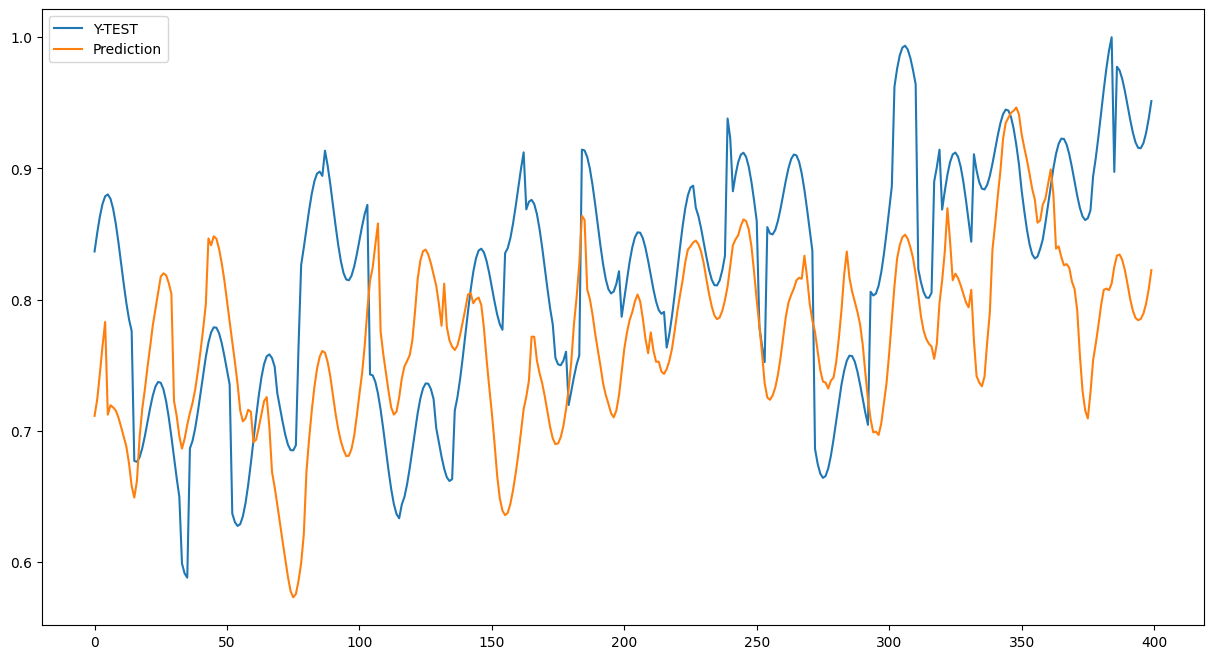

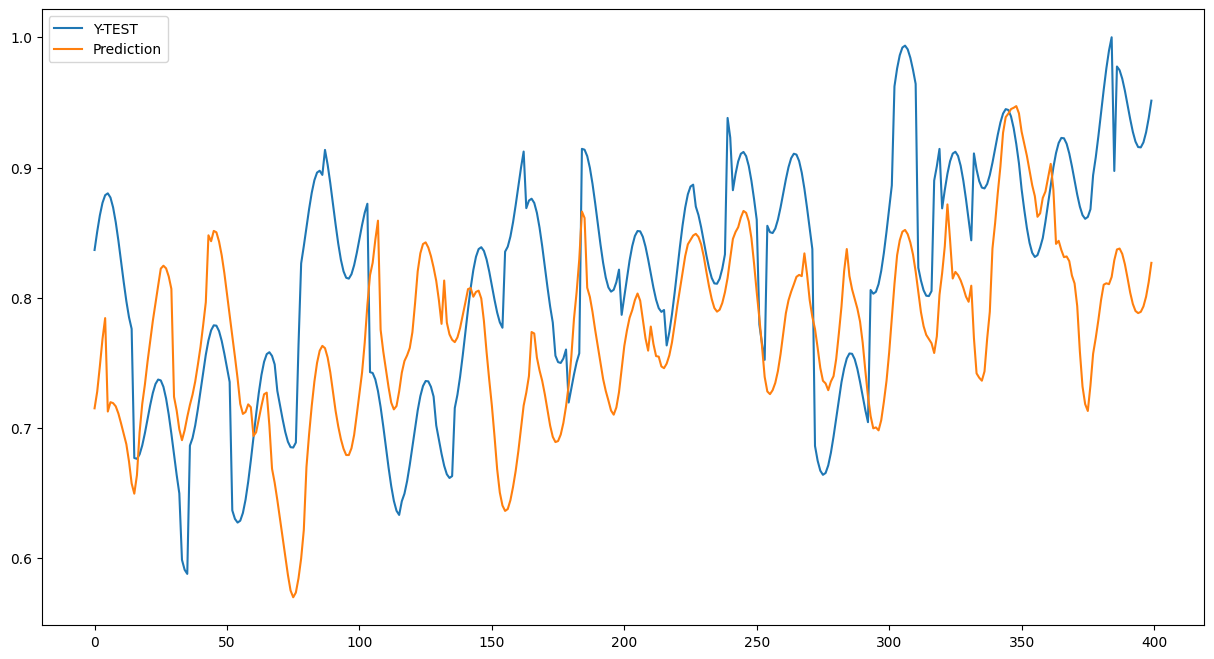

In [89]:
# Рисуем

for i in range(Ytest.shape[1]):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.show()

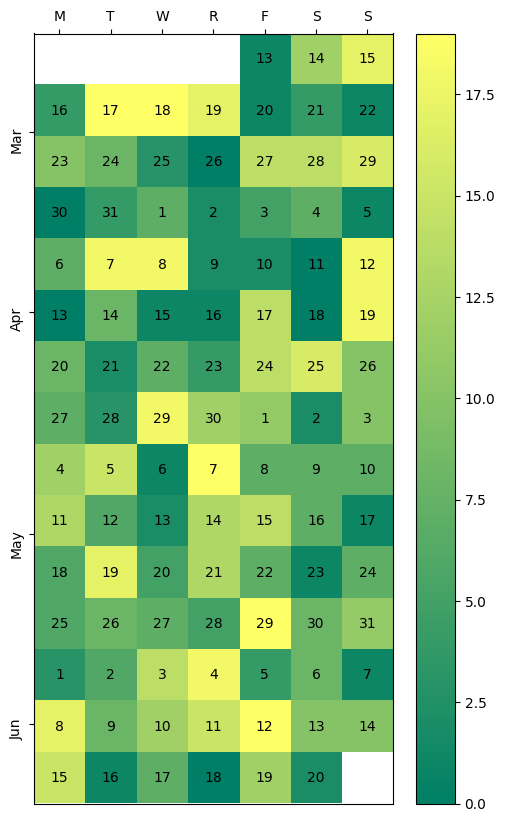

In [42]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

def main():
    dates, data = generate_data()
    fig, ax = plt.subplots(figsize=(6, 10))
    calendar_heatmap(ax, dates, data)
    plt.show()

def generate_data():
    num = 100
    data = np.random.randint(0, 20, num)
    start = dt.datetime(2015, 3, 13)
    dates = [start + dt.timedelta(days=i) for i in range(num)]
    return dates, data

def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar


def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation='none', cmap='summer')
    label_days(ax, dates, i, j, calendar)
    label_months(ax, dates, i, j, calendar)
    ax.figure.colorbar(im)

def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center')

    ax.set(xticks=np.arange(7), 
           xticklabels=['M', 'T', 'W', 'R', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

def label_months(ax, dates, i, j, calendar):
    month_labels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    months = np.array([d.month for d in dates])
    uniq_months = sorted(set(months))
    yticks = [i[months == m].mean() for m in uniq_months]
    labels = [month_labels[m - 1] for m in uniq_months]
    ax.set(yticks=yticks)
    ax.set_yticklabels(labels, rotation=90)

main()